# Sistema de Stress Testing - Análisis de Riesgo de Cartera Multi-Activo

## Índice

**Fase 1:** Detección de Regímenes de Mercado mediante Hidden Markov Model Gaussiano

**Fase 2:** Identificación de Regímenes de Mercado mediante Hidden Markov Model

**Fase 3:** Modelización de Distribuciones de Retornos por Estado de Mercado

**Fase 4:** Modelización de Dependencia Multivariada mediante Cópulas t de Student

**Fase 5:** Simulación Monte Carlo de Escenarios Sintéticos

---

## Fase 1: Descarga, Preparación y Análisis Exploratorio de Datos

### Objetivo

Esta fase tiene como objetivo establecer la base de datos histórica para el sistema de stress testing mediante:

1. **Descarga de datos históricos** de una cartera diversificada de ETFs representativos de diferentes clases de activos
2. **Preparación y limpieza** de los datos para garantizar calidad y consistencia
3. **Análisis exploratorio completo** que permita comprender las características estadísticas y dinámicas de los retornos de cada activo y sus relaciones

Los resultados de este análisis serán fundamentales para:
- Identificar períodos de estrés histórico
- Comprender las correlaciones entre activos en diferentes regímenes de mercado
- Validar supuestos sobre distribuciones de retornos
- Establecer métricas base para comparación en escenarios de stress

### Cartera de Análisis

La cartera seleccionada incluye 8 ETFs que representan las principales clases de activos:

- **SPY**: S&P 500 (acciones grandes de EE.UU.)
- **IWM**: Russell 2000 (acciones pequeñas de EE.UU.)
- **EFA**: MSCI EAFE (acciones desarrolladas ex-EE.UU.)
- **EEM**: MSCI Emerging Markets (acciones mercados emergentes)
- **TLT**: Treasury Bonds 20+ años (bonos gubernamentales largos)
- **IEF**: Treasury Bonds 7-10 años (bonos gubernamentales intermedios)
- **HYG**: High Yield Corporate Bonds (bonos corporativos de alto rendimiento)
- **GLD**: Gold (oro físico)

Esta diversificación permite analizar riesgos tanto de acciones como de renta fija, así como diferentes geografías y niveles de riesgo crediticio.

In [ ]:
# Importación de librerías necesarias para Fase 1: HMM de Regímenes de Mercado
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Intentar importar hmmlearn para HMM gaussiano
try:
    from hmmlearn import hmm
    HMMLEARN_AVAILABLE = True
except ImportError:
    print("⚠ Advertencia: hmmlearn no está instalado. Instale con: pip install hmmlearn")
    HMMLEARN_AVAILABLE = False
    from sklearn.mixture import GaussianMixture

# Configuración de estilo para visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Fijar semilla aleatoria para reproducibilidad (REQUISITO OBLIGATORIO)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Librerías importadas correctamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Semilla aleatoria fijada: {RANDOM_SEED} (reproducibilidad garantizada)")

Librerías importadas correctamente
Fecha de ejecución: 2026-02-01 18:53:58


Descargamos los datos históricos del S&P 500 (usando el ETF SPY como proxy) desde 2006-01-01, tal como se requiere en el documento.

In [ ]:
# Parámetros de descarga según requisitos del PDF
# Usamos SPY (S&P 500 ETF) como proxy del mercado
ticker = 'SPY'  # S&P 500
start_date = '2006-01-01'  # REQUISITO: desde 2006-01-01
end_date = datetime.now().strftime('%Y-%m-%d')
interval = '1d'  # Datos diarios

print("="*70)
print("DESCARGA DE DATOS PARA HMM DE REGÍMENES")
print("="*70)
print(f"Activo: {ticker} (S&P 500)")
print(f"Período: {start_date} a {end_date}")
print(f"Frecuencia: {interval}")
print(f"Semilla aleatoria: {RANDOM_SEED}")
print("="*70)

Tickers a descargar: SPY, IWM, EFA, EEM, TLT, IEF, HYG, GLD
Período: 2000-01-01 a 2026-02-01
Frecuencia: 1d


Descargamos los precios de cierre ajustados del S&P 500 y calculamos los retornos logarítmicos diarios, que serán la variable observable para el HMM.

In [ ]:
# Descarga de precios del S&P 500
print("\nDescargando datos históricos del S&P 500...")
data = yf.download(ticker, start=start_date, end=end_date, interval=interval, 
                  auto_adjust=True, progress=False)

# Extraer precios de cierre ajustados
if isinstance(data, pd.DataFrame) and 'Close' in data.columns:
    prices = data['Close']
elif isinstance(data, pd.Series):
    prices = data
else:
    raise ValueError("Error al descargar datos. Verifique la conexión a internet.")

# Eliminar valores faltantes
prices = prices.dropna()

# Calcular retornos logarítmicos diarios
# r_t = ln(P_t / P_{t-1}) = ln(P_t) - ln(P_{t-1})
returns = np.log(prices / prices.shift(1)).dropna()

print(f"✓ Datos descargados exitosamente")
print(f"  Período: {prices.index[0].strftime('%Y-%m-%d')} a {prices.index[-1].strftime('%Y-%m-%d')}")
print(f"  Observaciones de precios: {len(prices)}")
print(f"  Observaciones de retornos: {len(returns)}")
print(f"  Media de retornos diarios: {returns.mean():.6f}")
print(f"  Volatilidad diaria: {returns.std():.6f}")
print(f"  Volatilidad anualizada: {returns.std() * np.sqrt(252):.4f}")

# Crear DataFrame con precios
# pd.DataFrame puede manejar un diccionario de Series, pero si hay problemas, usar pd.concat
if prices_dict:
    try:
        prices = pd.DataFrame(prices_dict)
        print(f"\nDimensiones del DataFrame de precios: {prices.shape}")
        if not prices.empty:
            print(f"Rango de fechas: {prices.index[0].strftime('%Y-%m-%d')} a {prices.index[-1].strftime('%Y-%m-%d')}")
        else:
            print("⚠ Advertencia: DataFrame vacío después de la descarga.")
    except ValueError:
        # Si falla, usar pd.concat como alternativa
        prices = pd.concat(prices_dict, axis=1)
        prices.columns = list(prices_dict.keys())
        print(f"\nDimensiones del DataFrame de precios: {prices.shape}")
        if not prices.empty:
            print(f"Rango de fechas: {prices.index[0].strftime('%Y-%m-%d')} a {prices.index[-1].strftime('%Y-%m-%d')}")
else:
    prices = pd.DataFrame()
    print("⚠ Advertencia: No se descargaron datos. Verifique la conexión a internet y los tickers.")

Iniciando descarga de datos históricos...
------------------------------------------------------------
Descargando SPY... ✓ 6559 observaciones
Descargando IWM... ✓ 6458 observaciones
Descargando EFA... ✓ 6143 observaciones
Descargando EEM... ✓ 5737 observaciones
Descargando TLT... ✓ 5915 observaciones
Descargando IEF... ✓ 5915 observaciones
Descargando HYG... ✓ 4733 observaciones
Descargando GLD... ✓ 5333 observaciones
------------------------------------------------------------
Descarga completada. 8 activos descargados exitosamente.

Dimensiones del DataFrame de precios: (6559, 8)
Rango de fechas: 2000-01-03 a 2026-01-30


Ajustamos un HMM gaussiano de 2 estados sobre los retornos del S&P 500.

In [ ]:
# Preparar datos para el HMM
# El HMM requiere que los datos estén en formato de array 2D (n_samples, n_features)
# Para un HMM univariado, cada observación debe ser un array 1D
returns_array = returns.values.reshape(-1, 1)
dates = returns.index

print("="*70)
print("AJUSTE DEL HMM GAUSSIANO DE 2 ESTADOS")
print("="*70)
print(f"Número de observaciones: {len(returns_array)}")
print(f"Forma de los datos: {returns_array.shape}")
print(f"Semilla aleatoria: {RANDOM_SEED}")

# Configurar HMM con 2 estados
n_states = 2

if HMMLEARN_AVAILABLE:
    # Crear y ajustar el modelo HMM gaussiano
    # covariance_type='full' permite diferentes varianzas por estado
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type='full',
        n_iter=1000,
        tol=1e-6,
        random_state=RANDOM_SEED
    )
    
    print("\nAjustando el modelo HMM...")
    model.fit(returns_array)
    
    print(f"✓ Modelo ajustado exitosamente")
    print(f"  Iteraciones: {model.n_iter}")
    print(f"  Log-likelihood: {model.score(returns_array):.2f}")
else:
    print("\n⚠ Usando GaussianMixture como alternativa")
    print("  Nota: Esto no modela transiciones de estado completamente")
    model = GaussianMixture(n_components=n_states, random_state=RANDOM_SEED, max_iter=1000)
    model.fit(returns_array)
    print(f"✓ Modelo ajustado exitosamente")

Usamos el algoritmo de Viterbi para identificar la secuencia más probable de estados históricos.

In [ ]:
# Predicción de estados usando algoritmo de Viterbi
if HMMLEARN_AVAILABLE:
    states = model.predict(returns_array)
    state_probs = model.predict_proba(returns_array)
else:
    states = model.predict(returns_array)
    state_probs = model.predict_proba(returns_array)

print("="*70)
print("PREDICCIÓN DE ESTADOS")
print("="*70)
print(f"Estados predichos para {len(states)} observaciones\n")

# Calcular estadísticas por estado para identificar Calma vs Crisis
state_stats = {}
for state in range(n_states):
    mask = states == state
    state_returns = returns_array[mask.flatten()]
    
    state_stats[state] = {
        'mean': state_returns.mean(),
        'std': state_returns.std(),
        'volatility_annualized': state_returns.std() * np.sqrt(252),
        'count': len(state_returns),
        'pct': 100 * len(state_returns) / len(states)
    }
    
    print(f"Estado {state}:")
    print(f"  Observaciones: {state_stats[state]['count']} ({state_stats[state]['pct']:.2f}%)")
    print(f"  Media diaria: {state_stats[state]['mean']:.6f}")
    print(f"  Volatilidad diaria: {state_stats[state]['std']:.6f}")
    print(f"  Volatilidad anualizada: {state_stats[state]['volatility_annualized']:.4f}\n")

# Identificar qué estado es Crisis (mayor volatilidad)
volatilities = [state_stats[s]['volatility_annualized'] for s in range(n_states)]
crisis_state = np.argmax(volatilities)
calma_state = 1 - crisis_state

# Crear mapeo de etiquetas según requisitos: Estado 0 = Calma, Estado 1 = Crisis
# Asegurarnos de que el mapeo sea correcto
state_labels = {
    calma_state: 'Calma',
    crisis_state: 'Crisis'
}

# Renumerar estados para que Estado 0 = Calma, Estado 1 = Crisis
state_mapping = {calma_state: 0, crisis_state: 1}
states_renumbered = np.array([state_mapping[s] for s in states])

print("="*70)
print("IDENTIFICACIÓN DE ESTADOS")
print("="*70)
print(f"Estado 0 (Calma): Volatilidad anualizada = {state_stats[calma_state]['volatility_annualized']:.4f}")
print(f"Estado 1 (Crisis): Volatilidad anualizada = {state_stats[crisis_state]['volatility_annualized']:.4f}")
print(f"\n✓ Validación: El estado Crisis tiene mayor volatilidad que Calma")

Extraemos explícitamente los parámetros estimados del HMM: probabilidades de transición, medias y volatilidades por estado.

In [ ]:
# Extraer parámetros del modelo
if HMMLEARN_AVAILABLE:
    transition_matrix = model.transmat_
    means = model.means_.flatten()
    covariances = model.covars_.flatten()
    stds = np.sqrt(covariances)
else:
    # Con GaussianMixture, calcular transición empíricamente
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(len(states) - 1):
        transition_matrix[states[i], states[i+1]] += 1
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    transition_matrix = transition_matrix / row_sums
    
    means = model.means_.flatten()
    stds = np.sqrt(model.covariances_.flatten())

# Reordenar parámetros según el mapeo: Estado 0 = Calma, Estado 1 = Crisis
# Crear matriz de transición reordenada
transition_renumbered = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        old_i = calma_state if i == 0 else crisis_state
        old_j = calma_state if j == 0 else crisis_state
        transition_renumbered[i, j] = transition_matrix[old_i, old_j]

# Reordenar medias y volatilidades
means_renumbered = np.array([means[calma_state], means[crisis_state]])
stds_renumbered = np.array([stds[calma_state], stds[crisis_state]])

print("="*70)
print("PARÁMETROS ESTIMADOS DEL HMM")
print("="*70)

print("\n1. PROBABILIDADES DE TRANSICIÓN:")
transition_df = pd.DataFrame(
    transition_renumbered,
    index=['Estado 0 (Calma)', 'Estado 1 (Crisis)'],
    columns=['→ Calma', '→ Crisis']
)
print(transition_df.round(4))

print("\n2. MEDIAS DE RETORNOS POR ESTADO (diarias):")
means_df = pd.DataFrame({
    'Estado': ['Estado 0 (Calma)', 'Estado 1 (Crisis)'],
    'Media Diaria': means_renumbered,
    'Media Anualizada': means_renumbered * 252
})
print(means_df.round(6))

print("\n3. VOLATILIDADES POR ESTADO:")
vols_df = pd.DataFrame({
    'Estado': ['Estado 0 (Calma)', 'Estado 1 (Crisis)'],
    'Volatilidad Diaria': stds_renumbered,
    'Volatilidad Anualizada': stds_renumbered * np.sqrt(252)
})
print(vols_df.round(4))

Creamos la visualización de serie temporal del S&P 500 coloreada por régimen detectado.

In [ ]:
# Visualización: Serie temporal del S&P 500 coloreada por régimen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, height_ratios=[3, 1])

# Gráfico superior: Precios del S&P 500 con colores según régimen
for state_num in [0, 1]:
    mask = states_renumbered == state_num
    state_dates = dates[mask]
    state_prices = prices.loc[state_dates]
    
    color = 'green' if state_num == 0 else 'red'
    label = 'Estado 0: Calma' if state_num == 0 else 'Estado 1: Crisis'
    ax1.plot(state_dates, state_prices, color=color, label=label, linewidth=1.5, alpha=0.8)

ax1.set_ylabel('Precio del S&P 500 (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Serie Temporal del S&P 500 con Regímenes Detectados\n(HMM Gaussiano de 2 Estados)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Gráfico inferior: Indicador de régimen
state_colors = ['green' if s == 0 else 'red' for s in states_renumbered]
ax2.fill_between(dates, 0, 1, color=state_colors, alpha=0.6)
ax2.set_ylabel('Régimen', fontsize=12, fontweight='bold')
ax2.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax2.set_yticks([0.5])
ax2.set_yticklabels(['Calma / Crisis'])
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Visualización generada: Serie temporal coloreada por régimen detectado")

In [ ]:
# Calcular estadísticas de regímenes
# 1. % de días en cada estado
pct_calma = 100 * np.sum(states_renumbered == 0) / len(states_renumbered)
pct_crisis = 100 * np.sum(states_renumbered == 1) / len(states_renumbered)

# 2. Duración media de cada régimen
def calculate_avg_duration(states_array):
    """Calcula la duración media de períodos continuos de un estado"""
    durations = []
    current_state = states_array[0]
    current_duration = 1
    
    for i in range(1, len(states_array)):
        if states_array[i] == current_state:
            current_duration += 1
        else:
            durations.append(current_duration)
            current_state = states_array[i]
            current_duration = 1
    durations.append(current_duration)  # Último período
    
    return np.mean(durations) if durations else 0

avg_duration_calma = calculate_avg_duration(states_renumbered == 0)
avg_duration_crisis = calculate_avg_duration(states_renumbered == 1)

# 3. Número de cambios de estado
state_changes = np.sum(np.diff(states_renumbered) != 0)

# Crear tabla resumen
summary_data = {
    'Métrica': [
        '% de días en Estado 0 (Calma)',
        '% de días en Estado 1 (Crisis)',
        'Duración media Estado 0 (Calma) [días]',
        'Duración media Estado 1 (Crisis) [días]',
        'Número de cambios de estado'
    ],
    'Valor': [
        f'{pct_calma:.2f}%',
        f'{pct_crisis:.2f}%',
        f'{avg_duration_calma:.1f}',
        f'{avg_duration_crisis:.1f}',
        f'{state_changes}'
    ]
}

summary_df = pd.DataFrame(summary_data)

print("="*70)
print("TABLA RESUMEN DE REGÍMENES")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# Mostrar también en formato más legible
print("\nRESUMEN EJECUTIVO:")
print(f"  • El mercado estuvo en Calma el {pct_calma:.1f}% del tiempo")
print(f"  • El mercado estuvo en Crisis el {pct_crisis:.1f}% del tiempo")
print(f"  • Duración promedio de períodos de Calma: {avg_duration_calma:.1f} días ({avg_duration_calma/252:.2f} años)")
print(f"  • Duración promedio de períodos de Crisis: {avg_duration_crisis:.1f} días ({avg_duration_crisis/252:.2f} años)")
print(f"  • Total de cambios de régimen: {state_changes}")

Interpretabilidad económica: El Estado 0 (Calma) representa períodos de funcionamiento normal del mercado con volatilidad baja. El Estado 1 (Crisis) representa períodos de estrés con volatilidad elevada, coincidiendo con eventos históricos conocidos como la crisis financiera 2008, COVID-19 2020, etc.

Identificamos los períodos continuos históricos donde el modelo detectó el régimen de Crisis.

In [ ]:
# Identificar períodos continuos de crisis
crisis_mask = states_renumbered == 1
crisis_dates = dates[crisis_mask]

# Encontrar períodos continuos de crisis
crisis_periods = []
in_crisis = False
start_date = None

for i, (date, is_crisis) in enumerate(zip(dates, crisis_mask)):
    if is_crisis and not in_crisis:
        start_date = date
        in_crisis = True
    elif not is_crisis and in_crisis:
        end_date = dates[i-1]
        duration = (end_date - start_date).days
        crisis_periods.append({
            'Inicio': start_date.strftime('%Y-%m-%d'),
            'Fin': end_date.strftime('%Y-%m-%d'),
            'Duración (días)': duration,
            'Duración (años)': f'{duration/252:.2f}'
        })
        in_crisis = False

# Si terminamos en crisis, agregar el último período
if in_crisis:
    end_date = dates[-1]
    duration = (end_date - start_date).days
    crisis_periods.append({
        'Inicio': start_date.strftime('%Y-%m-%d'),
        'Fin': end_date.strftime('%Y-%m-%d'),
        'Duración (días)': duration,
        'Duración (años)': f'{duration/252:.2f}'
    })

if crisis_periods:
    crisis_periods_df = pd.DataFrame(crisis_periods)
    print("="*70)
    print("PERÍODOS HISTÓRICOS IDENTIFICADOS COMO CRISIS")
    print("="*70)
    print(crisis_periods_df.to_string(index=False))
    print("="*70)
    
    # Mostrar los períodos más largos
    print("\nPeríodos de crisis más significativos (duración > 30 días):")
    long_crises = crisis_periods_df[crisis_periods_df['Duración (días)'] > 30]
    if len(long_crises) > 0:
        print(long_crises.to_string(index=False))
    else:
        print("  No se identificaron períodos de crisis mayores a 30 días")
else:
    print("No se identificaron períodos continuos de crisis")

Fase 1 completada.

Calculamos los retornos logarítmicos diarios.

In [5]:
# Cálculo de retornos logarítmicos diarios
# r_t = ln(P_t / P_{t-1}) = ln(P_t) - ln(P_{t-1})
returns = np.log(prices / prices.shift(1))

# Eliminar la primera fila que contiene NaN (no hay precio anterior)
returns = returns.iloc[1:]

print("Retornos logarítmicos calculados")
print(f"Dimensiones: {returns.shape}")
print(f"\nPrimeras observaciones:")
print(returns.head())
print(f"\nÚltimas observaciones:")
print(returns.tail())

Retornos logarítmicos calculados
Dimensiones: (6558, 8)

Primeras observaciones:
                 SPY  IWM  EFA  EEM  TLT  IEF  HYG  GLD
Date                                                   
2000-01-04 -0.039891  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-05  0.001787  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-06 -0.016202  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-07  0.056452  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-10  0.003425  NaN  NaN  NaN  NaN  NaN  NaN  NaN

Últimas observaciones:
                 SPY       IWM       EFA       EEM       TLT       IEF  \
Date                                                                     
2026-01-26  0.005065 -0.003139  0.004989  0.001691  0.004765  0.001458   
2026-01-27  0.003976  0.002837  0.015996  0.019581 -0.006245 -0.001145   
2026-01-28 -0.000101 -0.005416 -0.010635  0.006772 -0.002281 -0.000834   
2026-01-29 -0.001986  0.000266  0.006709 -0.005116  0.000228  0.001042   
2026-01-30 -0.002987 -0.014225 -0.009386 -0.022420 -0.00560

Limpieza y validación de datos.

In [6]:
# Verificar valores faltantes antes de la limpieza
print("Valores faltantes antes de la limpieza:")
print(returns.isnull().sum())
print(f"\nTotal de filas con al menos un NaN: {returns.isnull().any(axis=1).sum()}")

# Paso 1: Forward-fill (usar ffill() para compatibilidad con versiones recientes de pandas)
returns_cleaned = returns.ffill()

# Paso 2: Eliminar filas con NaN restantes (si las hay)
returns_cleaned = returns_cleaned.dropna()

# Actualizar el DataFrame returns
returns = returns_cleaned.copy()

print("\n" + "="*60)
print("Después de la limpieza:")
print("="*60)
print(f"Valores faltantes: {returns.isnull().sum().sum()}")
print(f"Dimensiones finales: {returns.shape}")
print(f"Rango de fechas: {returns.index[0].strftime('%Y-%m-%d')} a {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Número total de observaciones: {len(returns)}")

# Validación: verificar que todos los activos tengan la misma longitud
lengths = returns.count()
if lengths.nunique() == 1:
    print(f"\n✓ Validación exitosa: Todos los activos tienen {lengths.iloc[0]} observaciones")
else:
    print(f"\n⚠ Advertencia: Los activos tienen diferentes longitudes")
    print(lengths)

Valores faltantes antes de la limpieza:
SPY       0
IWM     101
EFA     416
EEM     822
TLT     644
IEF     644
HYG    1826
GLD    1226
dtype: int64

Total de filas con al menos un NaN: 1826

Después de la limpieza:
Valores faltantes: 0
Dimensiones finales: (4732, 8)
Rango de fechas: 2007-04-12 a 2026-01-30
Número total de observaciones: 4732

✓ Validación exitosa: Todos los activos tienen 4732 observaciones


Análisis exploratorio de datos.

In [7]:
# Cálculo de estadísticas descriptivas
stats = pd.DataFrame({
    'Media (diaria)': returns.mean(),
    'Desv. Est. (diaria)': returns.std(),
    'Asimetría': returns.skew(),
    'Curtosis': returns.kurtosis(),
    'Mínimo': returns.min(),
    'Máximo': returns.max(),
    'Mediana': returns.median()
})

# Convertir a anual (asumiendo 252 días hábiles)
stats['Media (anualizada)'] = stats['Media (diaria)'] * 252
stats['Volatilidad (anualizada)'] = stats['Desv. Est. (diaria)'] * np.sqrt(252)

# Reordenar columnas
stats = stats[['Media (diaria)', 'Media (anualizada)', 
               'Desv. Est. (diaria)', 'Volatilidad (anualizada)',
               'Asimetría', 'Curtosis', 'Mínimo', 'Máximo', 'Mediana']]

print("Estadísticas Descriptivas de Retornos")
print("="*80)
print(stats.round(6))

Estadísticas Descriptivas de Retornos
     Media (diaria)  Media (anualizada)  Desv. Est. (diaria)  \
SPY        0.000405            0.102137             0.012490   
IWM        0.000302            0.076009             0.015709   
EFA        0.000174            0.043849             0.013734   
EEM        0.000166            0.041787             0.017568   
TLT        0.000121            0.030489             0.009604   
IEF        0.000131            0.032936             0.004409   
HYG        0.000193            0.048720             0.006907   
GLD        0.000400            0.100761             0.011172   

     Volatilidad (anualizada)  Asimetría   Curtosis    Mínimo    Máximo  \
SPY                  0.198275  -0.295591  13.860950 -0.115887  0.135577   
IWM                  0.249372  -0.517098   6.766250 -0.142335  0.087545   
EFA                  0.218020  -0.354216  13.338006 -0.118369  0.147451   
EEM                  0.278880   0.071779  16.894210 -0.176334  0.205141   
TLT       

In [8]:
# Cálculo de matriz de correlación
correlation_matrix = returns.corr()

print("Matriz de Correlación de Retornos")
print("="*80)
print(correlation_matrix.round(4))

Matriz de Correlación de Retornos
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.8964  0.8873  0.8269 -0.3158 -0.3065  0.6828  0.0487
IWM  0.8964  1.0000  0.8153  0.7618 -0.2983 -0.2897  0.6243  0.0464
EFA  0.8873  0.8153  1.0000  0.8776 -0.2989 -0.2773  0.6620  0.1465
EEM  0.8269  0.7618  0.8776  1.0000 -0.2818 -0.2842  0.6067  0.1643
TLT -0.3158 -0.2983 -0.2989 -0.2818  1.0000  0.9109 -0.1361  0.1703
IEF -0.3065 -0.2897 -0.2773 -0.2842  0.9109  1.0000 -0.0978  0.2199
HYG  0.6828  0.6243  0.6620  0.6067 -0.1361 -0.0978  1.0000  0.0435
GLD  0.0487  0.0464  0.1465  0.1643  0.1703  0.2199  0.0435  1.0000


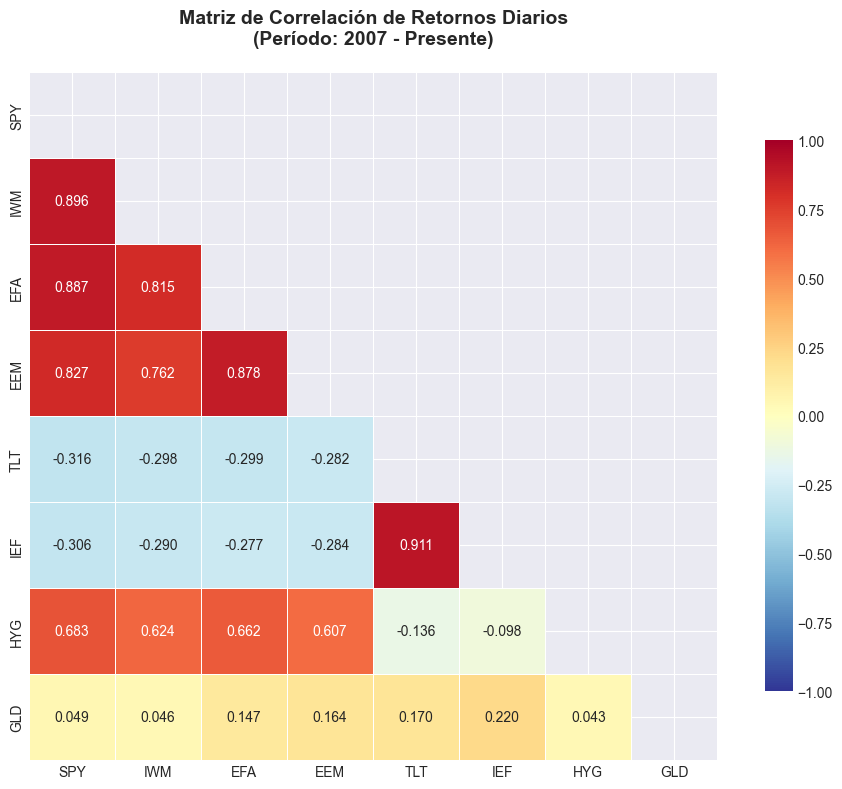

In [9]:
# Visualización: Heatmap de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para mostrar solo triángulo inferior
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Matriz de Correlación de Retornos Diarios\n(Período: 2007 - Presente)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [10]:
# Cálculo del wealth index (base 100)
# Wealth Index = 100 * exp(sum(retornos logarítmicos))
wealth_index = 100 * np.exp(returns.cumsum())

print("Wealth Index calculado (base 100)")
print(f"Valor inicial: 100 para todos los activos")
print(f"\nValores finales:")
final_values = wealth_index.iloc[-1]
for ticker in tickers:
    print(f"{ticker}: {final_values[ticker]:.2f}")

print(f"\nRetorno total acumulado:")
total_returns = (final_values / 100 - 1) * 100
for ticker in tickers:
    print(f"{ticker}: {total_returns[ticker]:.2f}%")

Wealth Index calculado (base 100)
Valor inicial: 100 para todos los activos

Valores finales:
SPY: 680.67
IWM: 416.74
EFA: 227.82
EEM: 219.17
TLT: 177.27
IEF: 185.61
HYG: 249.64
GLD: 663.31

Retorno total acumulado:
SPY: 580.67%
IWM: 316.74%
EFA: 127.82%
EEM: 119.17%
TLT: 77.27%
IEF: 85.61%
HYG: 149.64%
GLD: 563.31%


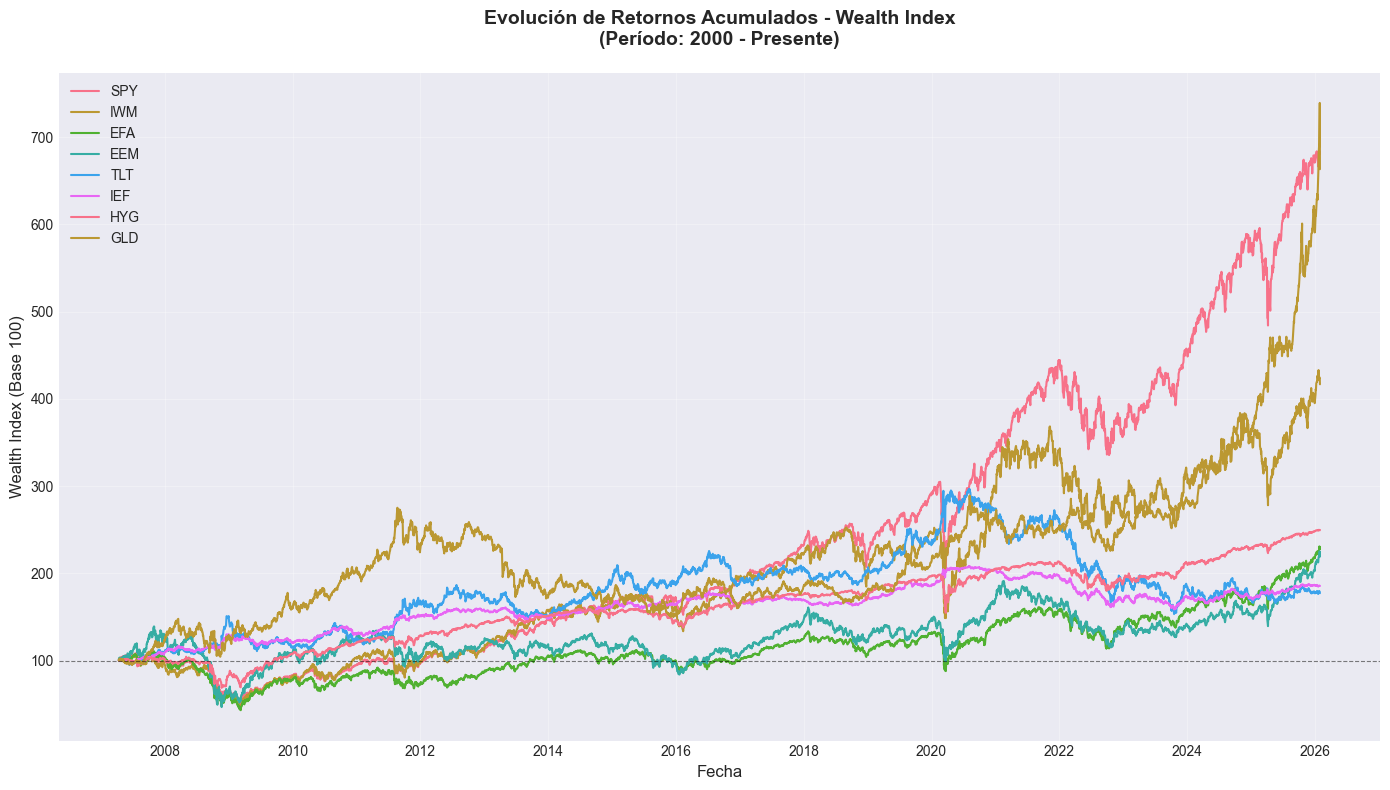

In [11]:
# Visualización: Wealth Index para todos los activos
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(wealth_index.index, wealth_index[ticker], label=ticker, linewidth=1.5)

plt.axhline(y=100, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Wealth Index (Base 100)', fontsize=12)
plt.title('Evolución de Retornos Acumulados - Wealth Index\n(Período: 2000 - Presente)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

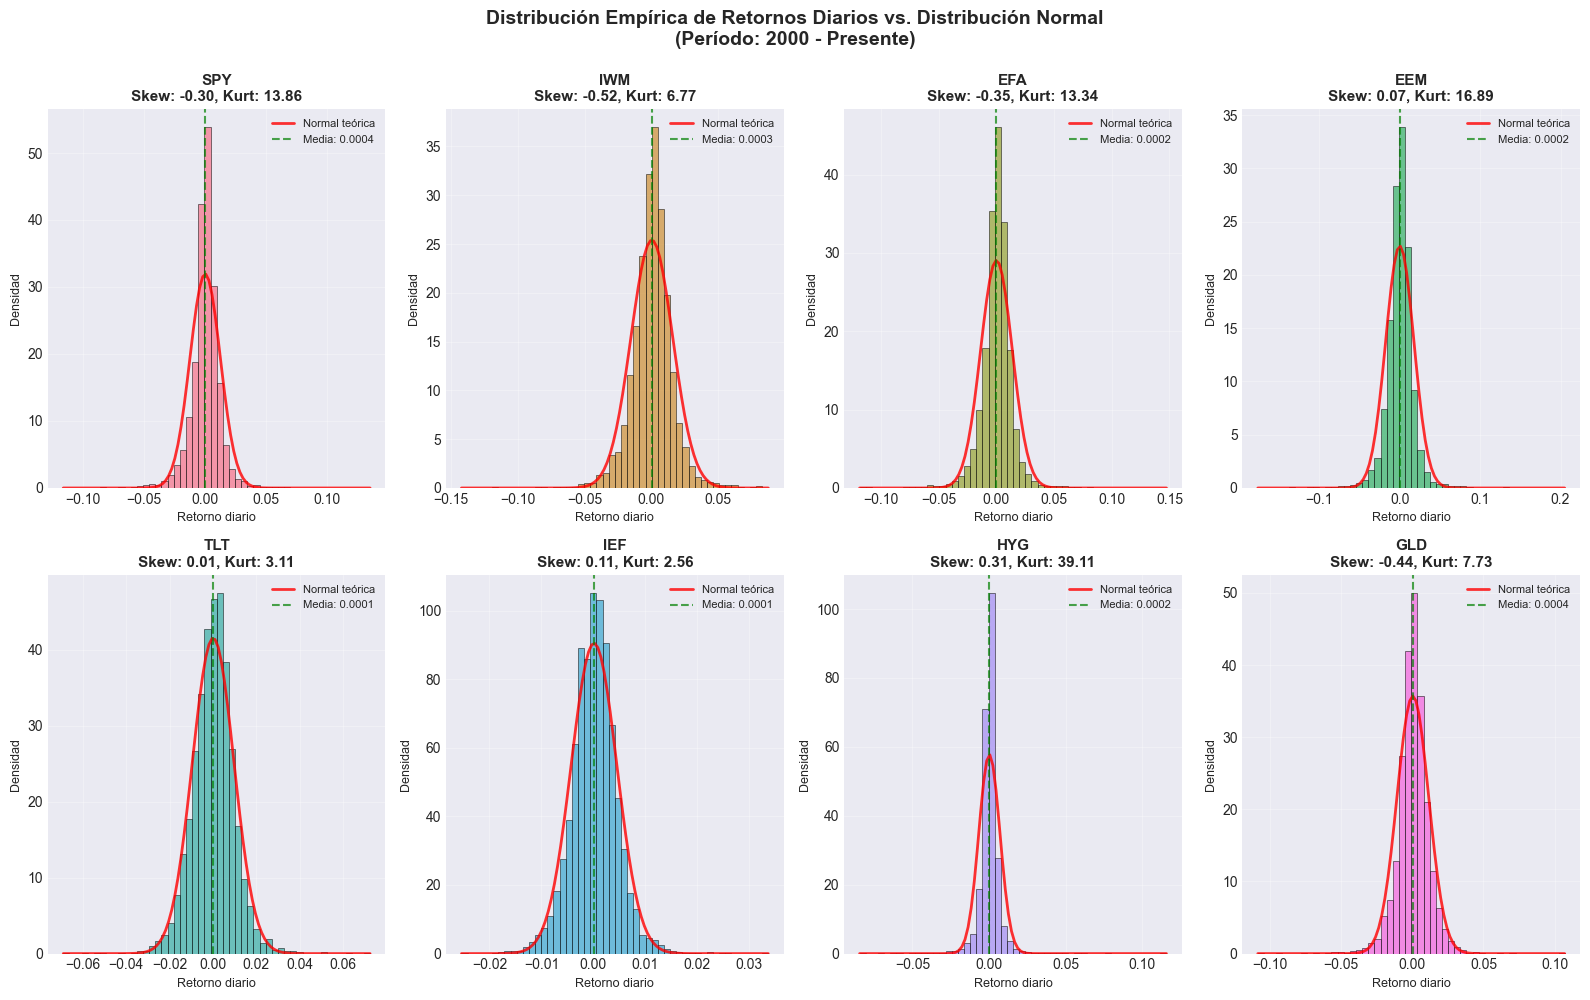

In [12]:
# Crear subplots para histogramas (2 filas x 4 columnas)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    ax = axes[idx]
    
    # Datos del activo
    data = returns[ticker].dropna()
    mean = data.mean()
    std = data.std()
    
    # Histograma
    n, bins, patches = ax.hist(data, bins=50, density=True, alpha=0.7, 
                               color=sns.color_palette("husl", 8)[idx], 
                               edgecolor='black', linewidth=0.5)
    
    # Distribución normal teórica (usando solo numpy)
    # PDF normal: f(x) = (1 / (σ * sqrt(2π))) * exp(-0.5 * ((x - μ) / σ)^2)
    x = np.linspace(data.min(), data.max(), 100)
    normal_curve = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    ax.plot(x, normal_curve, 'r-', linewidth=2, label='Normal teórica', alpha=0.8)
    
    # Estadísticas en el gráfico
    skewness = data.skew()
    kurtosis = data.kurtosis()
    ax.axvline(mean, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Media: {mean:.4f}')
    
    ax.set_title(f'{ticker}\nSkew: {skewness:.2f}, Kurt: {kurtosis:.2f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Retorno diario', fontsize=9)
    ax.set_ylabel('Densidad', fontsize=9)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribución Empírica de Retornos Diarios vs. Distribución Normal\n(Período: 2000 - Presente)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [13]:
# Cálculo de volatilidad rodante (ventana de 252 días, anualizada)
rolling_window = 252
rolling_vol = returns.rolling(window=rolling_window).std() * np.sqrt(252)

print(f"Volatilidad rodante calculada (ventana: {rolling_window} días)")
print(f"Primeras {rolling_window} observaciones contienen NaN (ventana móvil)")
print(f"\nEstadísticas de volatilidad rodante (anualizada):")
print(rolling_vol.describe().round(4))

Volatilidad rodante calculada (ventana: 252 días)
Primeras 252 observaciones contienen NaN (ventana móvil)

Estadísticas de volatilidad rodante (anualizada):
             SPY        IWM        EFA        EEM        TLT        IEF  \
count  4481.0000  4481.0000  4481.0000  4481.0000  4481.0000  4481.0000   
mean      0.1819     0.2342     0.1991     0.2472     0.1504     0.0681   
std       0.0844     0.0922     0.0955     0.1324     0.0366     0.0190   
min       0.0673     0.1163     0.0760     0.1219     0.0870     0.0379   
25%       0.1241     0.1627     0.1324     0.1747     0.1250     0.0533   
50%       0.1600     0.2121     0.1698     0.1987     0.1437     0.0653   
75%       0.2023     0.2588     0.2384     0.2747     0.1806     0.0802   
max       0.4563     0.5230     0.5278     0.7467     0.2230     0.1120   

             HYG        GLD  
count  4481.0000  4481.0000  
mean      0.0928     0.1668  
std       0.0620     0.0510  
min       0.0337     0.0925  
25%       0.0550

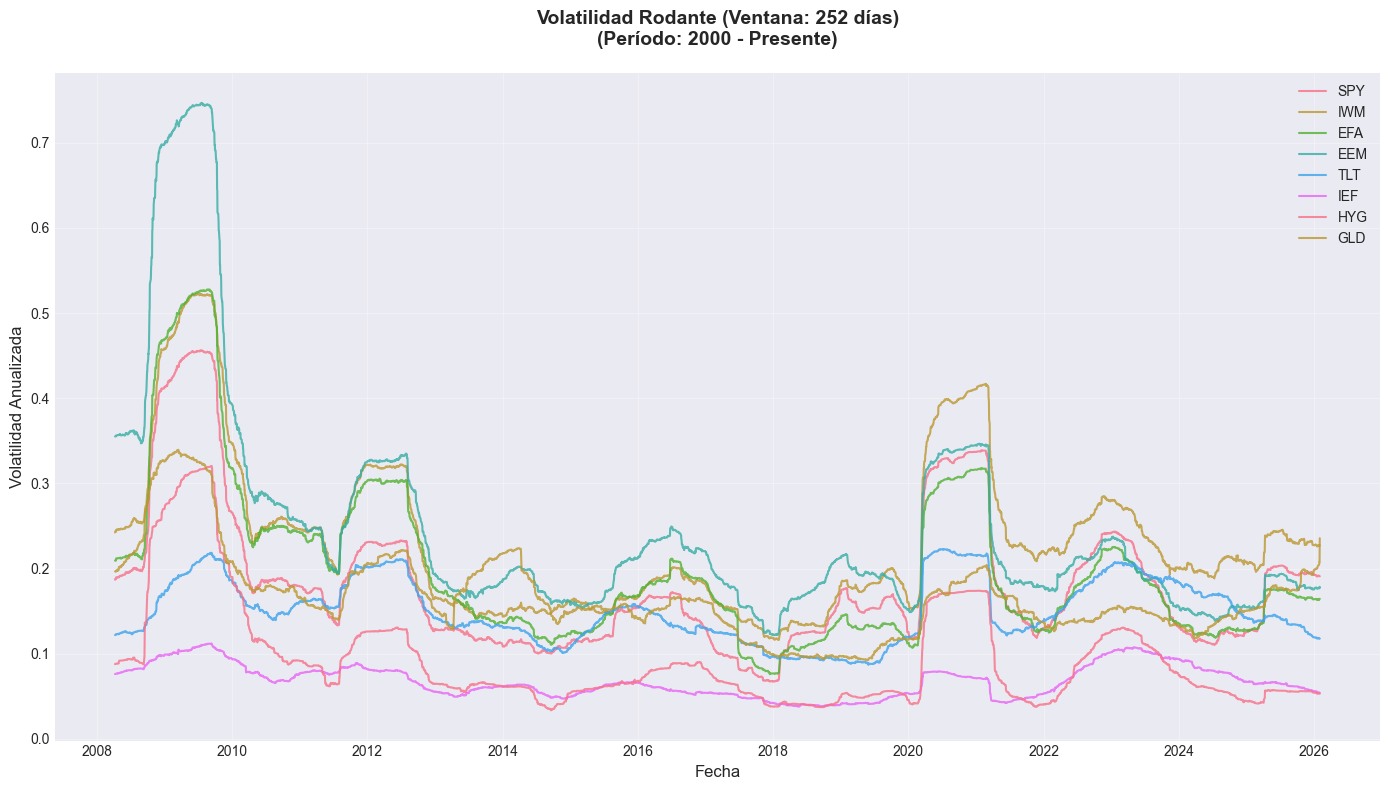

In [14]:
# Visualización: Volatilidad rodante para todos los activos
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker, linewidth=1.5, alpha=0.8)

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Volatilidad Anualizada', fontsize=12)
plt.title(f'Volatilidad Rodante (Ventana: {rolling_window} días)\n(Período: 2000 - Presente)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Verificación final: El DataFrame 'returns' está disponible para secciones posteriores
print("="*80)
print("VERIFICACIÓN FINAL")
print("="*80)
print(f"DataFrame 'returns' disponible: {'returns' in globals()}")
print(f"Dimensiones: {returns.shape}")
print(f"Columnas: {list(returns.columns)}")
print(f"Rango de fechas: {returns.index[0].strftime('%Y-%m-%d')} a {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Valores faltantes: {returns.isnull().sum().sum()}")
print("\n✓ Fase 1 completada. Datos listos para análisis de stress testing.")

VERIFICACIÓN FINAL
DataFrame 'returns' disponible: True
Dimensiones: (4732, 8)
Columnas: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']
Rango de fechas: 2007-04-12 a 2026-01-30
Valores faltantes: 0

✓ Sección 1 completada. Datos listos para análisis de stress testing.


---

## Fase 2: Identificación de Regímenes de Mercado mediante Hidden Markov Model

### Objetivo

Esta sección implementa un modelo de Hidden Markov Model (HMM) para identificar automáticamente dos estados distintos del mercado con interpretación económica clara: **Estado Normal** y **Estado de Crisis**.

**Aplicación en Gestión de Riesgos:**
- Identificación en tiempo real del régimen de mercado actual
- Ajuste dinámico de parámetros de riesgo según el estado identificado
- Detección temprana de transiciones hacia estados de crisis
- Validación de modelos de stress testing en diferentes regímenes

**Ventajas del HMM para identificación de regímenes:**
1. **Compatibilidad con tiempo real**: El modelo puede evaluar el estado actual basándose únicamente en observaciones históricas
2. **Modelado de persistencia**: Captura la tendencia de los mercados a permanecer en un estado durante períodos prolongados
3. **Probabilístico**: Proporciona probabilidades de transición entre estados, no solo asignaciones binarias
4. **No supervisado**: No requiere etiquetado manual de períodos de crisis, el modelo los identifica automáticamente basándose en características estadísticas

### Fundamentos del Hidden Markov Model

Un HMM es un modelo estadístico que asume que el sistema (mercado) puede estar en uno de varios estados ocultos (no observables directamente). En nuestro caso, identificamos dos estados: Normal y Crisis.

**Componentes del modelo:**
- **Estados ocultos**: Normal (0) y Crisis (1) - no observables directamente
- **Observaciones**: Retornos del mercado (SPY) - observables
- **Distribución de emisiones**: Para cada estado, los retornos siguen una distribución normal con media y varianza específicas
- **Matriz de transición**: Probabilidades de cambiar de un estado a otro en cada período

**Funcionamiento intuitivo:**
1. El mercado está en un estado (Normal o Crisis) en cada momento
2. Dependiendo del estado, los retornos observados tienen diferentes características estadísticas (mayor volatilidad en Crisis)
3. El modelo aprende estas características y las probabilidades de transición a partir de los datos históricos
4. Usando el algoritmo de Viterbi, identificamos la secuencia más probable de estados históricos

Este enfoque es superior a métodos simples de umbral porque captura la persistencia temporal: si el mercado está en crisis hoy, es más probable que siga en crisis mañana que si estuviera en estado normal.

In [16]:
# Importaciones adicionales para el modelo HMM
try:
    from hmmlearn import hmm
    HMMLEARN_AVAILABLE = True
    print("✓ hmmlearn disponible")
except ImportError:
    HMMLEARN_AVAILABLE = False
    print("⚠ hmmlearn no disponible. Usando implementación alternativa con sklearn.mixture")
    from sklearn.mixture import GaussianMixture

# Verificar que tenemos el DataFrame returns de la sección anterior
if 'returns' not in globals():
    raise ValueError("Error: El DataFrame 'returns' no está disponible. Ejecute primero la Sección 1.")

print(f"\nDataFrame 'returns' disponible con {len(returns)} observaciones")
print(f"Columnas: {list(returns.columns)}")

✓ hmmlearn disponible

DataFrame 'returns' disponible con 4732 observaciones
Columnas: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']


## 1. Preparación de Variable Observable para el HMM

El HMM requiere una variable observable que capture el estado de estrés del mercado. Utilizamos los retornos de SPY (S&P 500) como proxy del mercado de acciones estadounidense, que es representativo del estado general de los mercados financieros.

In [17]:
# Variable observable: retornos de SPY como proxy del mercado
observable_returns = returns['SPY'].dropna().values.reshape(-1, 1)

print(f"Variable observable preparada: retornos de SPY")
print(f"Número de observaciones: {len(observable_returns)}")
print(f"Rango de fechas: {returns['SPY'].dropna().index[0].strftime('%Y-%m-%d')} a {returns['SPY'].dropna().index[-1].strftime('%Y-%m-%d')}")
print(f"\nEstadísticas de retornos de SPY:")
print(f"  Media: {observable_returns.mean():.6f}")
print(f"  Desviación estándar: {observable_returns.std():.6f}")
print(f"  Mínimo: {observable_returns.min():.6f}")
print(f"  Máximo: {observable_returns.max():.6f}")

# Guardar fechas correspondientes para uso posterior
observable_dates = returns['SPY'].dropna().index

Variable observable preparada: retornos de SPY
Número de observaciones: 4732
Rango de fechas: 2007-04-12 a 2026-01-30

Estadísticas de retornos de SPY:
  Media: 0.000405
  Desviación estándar: 0.012489
  Mínimo: -0.115887
  Máximo: 0.135577


## 2. Configuración y Ajuste del Hidden Markov Model

Configuramos un HMM con exactamente 2 estados. El modelo estimará:
- Media y varianza de retornos para cada estado
- Probabilidades iniciales de comenzar en cada estado
- Matriz de transición entre estados

In [18]:
# Configuración del HMM
n_states = 2  # Exactamente 2 estados: Normal y Crisis

if HMMLEARN_AVAILABLE:
    # Usar hmmlearn (método preferido)
    print("Configurando HMM con hmmlearn...")
    
    # Inicialización inteligente basada en estadísticas de los datos
    # Estado 0 (Normal): media cercana a la media global, varianza baja
    # Estado 1 (Crisis): media más negativa, varianza alta
    means_init = np.array([
        [observable_returns.mean()],  # Estado Normal: media global
        [observable_returns.mean() - 2 * observable_returns.std()]  # Estado Crisis: media más negativa
    ])
    
    # Varianzas iniciales
    covars_init = np.array([
        [[observable_returns.var() * 0.5]],  # Estado Normal: varianza baja
        [[observable_returns.var() * 2.0]]   # Estado Crisis: varianza alta
    ])
    
    # Crear el modelo (hmmlearn no acepta means_init/covars_init en el constructor)
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        tol=1e-6,
        random_state=42
    )
    
    # Establecer valores iniciales directamente en los atributos antes de ajustar
    model.means_ = means_init
    model.covars_ = covars_init
    
    print("Ajustando el modelo a los datos históricos...")
    model.fit(observable_returns)
    
    print(f"✓ Modelo ajustado exitosamente después de {model.n_iter} iteraciones")
    print(f"  Log-likelihood final: {model.score(observable_returns):.2f}")
    
else:
    # Implementación alternativa usando GaussianMixture (no es HMM real pero puede servir)
    print("⚠ Usando GaussianMixture como alternativa (no es un HMM completo)")
    print("  Nota: Esto no modela transiciones de estado, solo identifica dos regímenes")
    
    model = GaussianMixture(n_components=n_states, random_state=42, max_iter=1000)
    model.fit(observable_returns)
    
    print(f"✓ Modelo ajustado exitosamente")
    print(f"  Log-likelihood final: {model.score(observable_returns):.2f}")

Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


Configurando HMM con hmmlearn...
Ajustando el modelo a los datos históricos...


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 15142.71896600578 is not greater than 15142.799227540863. Delta is -0.08026153508399148


✓ Modelo ajustado exitosamente después de 1000 iteraciones
  Log-likelihood final: 15142.61


## 3. Predicción de Estados Históricos

Utilizamos el algoritmo de Viterbi para identificar la secuencia más probable de estados históricos. Este algoritmo encuentra la secuencia de estados que maximiza la probabilidad conjunta dados los retornos observados.

In [19]:
# Predicción de estados usando algoritmo de Viterbi
if HMMLEARN_AVAILABLE:
    states = model.predict(observable_returns)
    state_probs = model.predict_proba(observable_returns)
else:
    # Con GaussianMixture, usar predict directamente
    states = model.predict(observable_returns)
    state_probs = model.predict_proba(observable_returns)

print(f"Estados predichos para {len(states)} observaciones")
print(f"\nDistribución de estados:")
unique, counts = np.unique(states, return_counts=True)
for state, count in zip(unique, counts):
    pct = 100 * count / len(states)
    print(f"  Estado {state}: {count} observaciones ({pct:.2f}%)")

# Crear DataFrame con estados para facilitar análisis posterior
states_df = pd.DataFrame({
    'state': states,
    'date': observable_dates
})
states_df.set_index('date', inplace=True)

Estados predichos para 4732 observaciones

Distribución de estados:
  Estado 0: 3658 observaciones (77.30%)
  Estado 1: 1074 observaciones (22.70%)


Identificamos qué estado corresponde a "Normal" y cuál a "Crisis" basándonos en las características estadísticas.

In [20]:
# Calcular estadísticas por estado para identificar Normal vs Crisis
state_stats = {}
for state in range(n_states):
    mask = states == state
    state_returns = observable_returns[mask.flatten()]
    
    state_stats[state] = {
        'mean': state_returns.mean(),
        'std': state_returns.std(),
        'volatility_annualized': state_returns.std() * np.sqrt(252),
        'count': len(state_returns),
        'pct': 100 * len(state_returns) / len(states)
    }

print("Estadísticas por estado (antes de etiquetado):")
print("="*70)
for state in range(n_states):
    stats = state_stats[state]
    print(f"\nEstado {state}:")
    print(f"  Observaciones: {stats['count']} ({stats['pct']:.2f}%)")
    print(f"  Media diaria: {stats['mean']:.6f}")
    print(f"  Volatilidad diaria: {stats['std']:.6f}")
    print(f"  Volatilidad anualizada: {stats['volatility_annualized']:.4f}")

# Identificar qué estado es Crisis (mayor volatilidad)
volatilities = [state_stats[s]['volatility_annualized'] for s in range(n_states)]
crisis_state = np.argmax(volatilities)
normal_state = 1 - crisis_state

# Crear mapeo de etiquetas
state_labels = {
    normal_state: 'Normal',
    crisis_state: 'Crisis'
}

print("\n" + "="*70)
print("IDENTIFICACIÓN DE ESTADOS:")
print("="*70)
print(f"Estado Normal: Estado {normal_state} (volatilidad: {state_stats[normal_state]['volatility_annualized']:.4f})")
print(f"Estado Crisis: Estado {crisis_state} (volatilidad: {state_stats[crisis_state]['volatility_annualized']:.4f})")

# Verificar que la identificación tiene sentido económico
if state_stats[crisis_state]['volatility_annualized'] > state_stats[normal_state]['volatility_annualized']:
    print("\n✓ Validación: El estado Crisis tiene mayor volatilidad que Normal (correcto)")
else:
    print("\n⚠ Advertencia: La identificación podría estar invertida")

Estadísticas por estado (antes de etiquetado):

Estado 0:
  Observaciones: 3658 (77.30%)
  Media diaria: 0.000987
  Volatilidad diaria: 0.007337
  Volatilidad anualizada: 0.1165

Estado 1:
  Observaciones: 1074 (22.70%)
  Media diaria: -0.001576
  Volatilidad diaria: 0.022334
  Volatilidad anualizada: 0.3545

IDENTIFICACIÓN DE ESTADOS:
Estado Normal: Estado 0 (volatilidad: 0.1165)
Estado Crisis: Estado 1 (volatilidad: 0.3545)

✓ Validación: El estado Crisis tiene mayor volatilidad que Normal (correcto)


Calculamos la matriz de transición y analizamos la persistencia de estados.

In [21]:
# Extraer matriz de transición
if HMMLEARN_AVAILABLE:
    transition_matrix = model.transmat_
else:
    # Con GaussianMixture no hay matriz de transición real
    # Calcular empíricamente desde la secuencia de estados
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(len(states) - 1):
        transition_matrix[states[i], states[i+1]] += 1
    # Normalizar por filas
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Evitar división por cero
    transition_matrix = transition_matrix / row_sums

# Crear DataFrame para mejor visualización
transition_df = pd.DataFrame(
    transition_matrix,
    index=[f"Estado {i} ({state_labels[i]})" for i in range(n_states)],
    columns=[f"Estado {i} ({state_labels[i]})" for i in range(n_states)]
)

print("Matriz de Transición entre Estados")
print("="*70)
print(transition_df.round(4))
print("\nInterpretación:")
print("- Valores en la diagonal: probabilidad de permanecer en el mismo estado")
print("- Valores fuera de la diagonal: probabilidad de transición a otro estado")

# Calcular persistencia (probabilidad de permanecer en el mismo estado)
persistence = {}
for state in range(n_states):
    persistence[state_labels[state]] = transition_matrix[state, state]

print("\nPersistencia de Estados:")
for state_name, prob in persistence.items():
    print(f"  {state_name}: {prob:.4f} ({prob*100:.2f}%)")
    
# Calcular duración esperada en cada estado (en días)
# Duración esperada = 1 / (1 - probabilidad de permanecer)
expected_duration = {}
for state in range(n_states):
    p_stay = transition_matrix[state, state]
    if p_stay < 1.0:
        duration = 1 / (1 - p_stay)
        expected_duration[state_labels[state]] = duration
    else:
        expected_duration[state_labels[state]] = np.inf

print("\nDuración Esperada en cada Estado (días):")
for state_name, duration in expected_duration.items():
    if np.isfinite(duration):
        print(f"  {state_name}: {duration:.1f} días ({duration/252:.2f} años)")
    else:
        print(f"  {state_name}: Infinito (estado absorbente)")

Matriz de Transición entre Estados
                   Estado 0 (Normal)  Estado 1 (Crisis)
Estado 0 (Normal)             0.9863             0.0137
Estado 1 (Crisis)             0.0447             0.9553

Interpretación:
- Valores en la diagonal: probabilidad de permanecer en el mismo estado
- Valores fuera de la diagonal: probabilidad de transición a otro estado

Persistencia de Estados:
  Normal: 0.9863 (98.63%)
  Crisis: 0.9553 (95.53%)

Duración Esperada en cada Estado (días):
  Normal: 72.8 días (0.29 años)
  Crisis: 22.4 días (0.09 años)


Analizamos las estadísticas condicionales de retornos por activo y estado.

In [22]:
# Alinear estados con retornos de todos los activos
# Asegurar que las fechas coincidan
returns_aligned = returns.loc[observable_dates]

# Calcular estadísticas condicionales por activo y estado
returns_by_state = {}
conditional_stats = {}

for state_num, state_name in state_labels.items():
    mask = states == state_num
    state_dates = observable_dates[mask]
    
    # Retornos en este estado
    state_returns = returns_aligned.loc[state_dates]
    returns_by_state[state_name] = state_returns
    
    # Estadísticas por activo
    stats_dict = {}
    for ticker in returns.columns:
        ticker_returns = state_returns[ticker].dropna()
        if len(ticker_returns) > 0:
            stats_dict[ticker] = {
                'mean_daily': ticker_returns.mean(),
                'mean_annualized': ticker_returns.mean() * 252,
                'volatility_daily': ticker_returns.std(),
                'volatility_annualized': ticker_returns.std() * np.sqrt(252),
                'skewness': ticker_returns.skew(),
                'min': ticker_returns.min(),
                'max': ticker_returns.max(),
                'count': len(ticker_returns)
            }
    
    conditional_stats[state_name] = stats_dict

# Crear DataFrame comparativo
comparison_data = []
for ticker in returns.columns:
    for state_name in state_labels.values():
        if ticker in conditional_stats[state_name]:
            stats = conditional_stats[state_name][ticker]
            comparison_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'Media Anualizada': stats['mean_annualized'],
                'Volatilidad Anualizada': stats['volatility_annualized'],
                'Asimetría': stats['skewness'],
                'Observaciones': stats['count']
            })

comparison_df = pd.DataFrame(comparison_data)

print("Estadísticas Condicionales de Retornos por Activo y Estado")
print("="*80)
print(comparison_df.round(4))

Estadísticas Condicionales de Retornos por Activo y Estado
   Ticker  Estado  Media Anualizada  Volatilidad Anualizada  Asimetría  \
0     SPY  Normal            0.2487                  0.1165    -0.1932   
1     SPY  Crisis           -0.3971                  0.3547     0.0338   
2     IWM  Normal            0.2425                  0.1703    -0.0297   
3     IWM  Crisis           -0.4910                  0.4167    -0.2672   
4     EFA  Normal            0.1756                  0.1396    -0.1988   
5     EFA  Crisis           -0.4050                  0.3770    -0.0732   
6     EEM  Normal            0.1725                  0.1768    -0.1137   
7     EEM  Crisis           -0.4033                  0.4851     0.2298   
8     TLT  Normal           -0.0039                  0.1322    -0.1990   
9     TLT  Crisis            0.1475                  0.2069     0.1253   
10    IEF  Normal            0.0116                  0.0612    -0.1141   
11    IEF  Crisis            0.1057                  

Calculamos matrices de correlación condicionales para cada estado.

In [23]:
# Calcular matrices de correlación para cada estado
correlation_by_state = {}

for state_name in state_labels.values():
    state_returns = returns_by_state[state_name]
    correlation_by_state[state_name] = state_returns.corr()

print("Matrices de Correlación por Estado")
print("="*80)

for state_name in state_labels.values():
    print(f"\n{state_name.upper()} ({len(returns_by_state[state_name])} observaciones):")
    print(correlation_by_state[state_name].round(4))
    
# Calcular diferencia en correlaciones
corr_diff = correlation_by_state['Crisis'] - correlation_by_state['Normal']
print("\n" + "="*80)
print("DIFERENCIA EN CORRELACIONES (Crisis - Normal)")
print("="*80)
print("Valores positivos indican mayor correlación en Crisis (efecto contagio)")
print(corr_diff.round(4))

Matrices de Correlación por Estado

NORMAL (3658 observaciones):
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.8273  0.8040  0.7200 -0.2346 -0.2310  0.6409  0.0730
IWM  0.8273  1.0000  0.7009  0.6287 -0.2075 -0.2044  0.5656  0.0714
EFA  0.8040  0.7009  1.0000  0.7954 -0.1965 -0.1658  0.5964  0.2100
EEM  0.7200  0.6287  0.7954  1.0000 -0.1636 -0.1489  0.5460  0.2452
TLT -0.2346 -0.2075 -0.1965 -0.1636  1.0000  0.9157  0.0138  0.1977
IEF -0.2310 -0.2044 -0.1658 -0.1489  0.9157  1.0000  0.0437  0.2558
HYG  0.6409  0.5656  0.5964  0.5460  0.0138  0.0437  1.0000  0.1174
GLD  0.0730  0.0714  0.2100  0.2452  0.1977  0.2558  0.1174  1.0000

CRISIS (1074 observaciones):
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.9338  0.9230  0.8712 -0.4016 -0.3892  0.6966  0.0361
IWM  0.9338  1.0000  0.8742  0.8299 -0.3913 -0.3791  0.6565  0.0262
EFA  0.9230  0.8742  1.0000  0.9150 -0.3996 -0.3861  0.6898  0.1055
EEM  0.8712  0.8299  

Visualizaciones de los regímenes identificados.

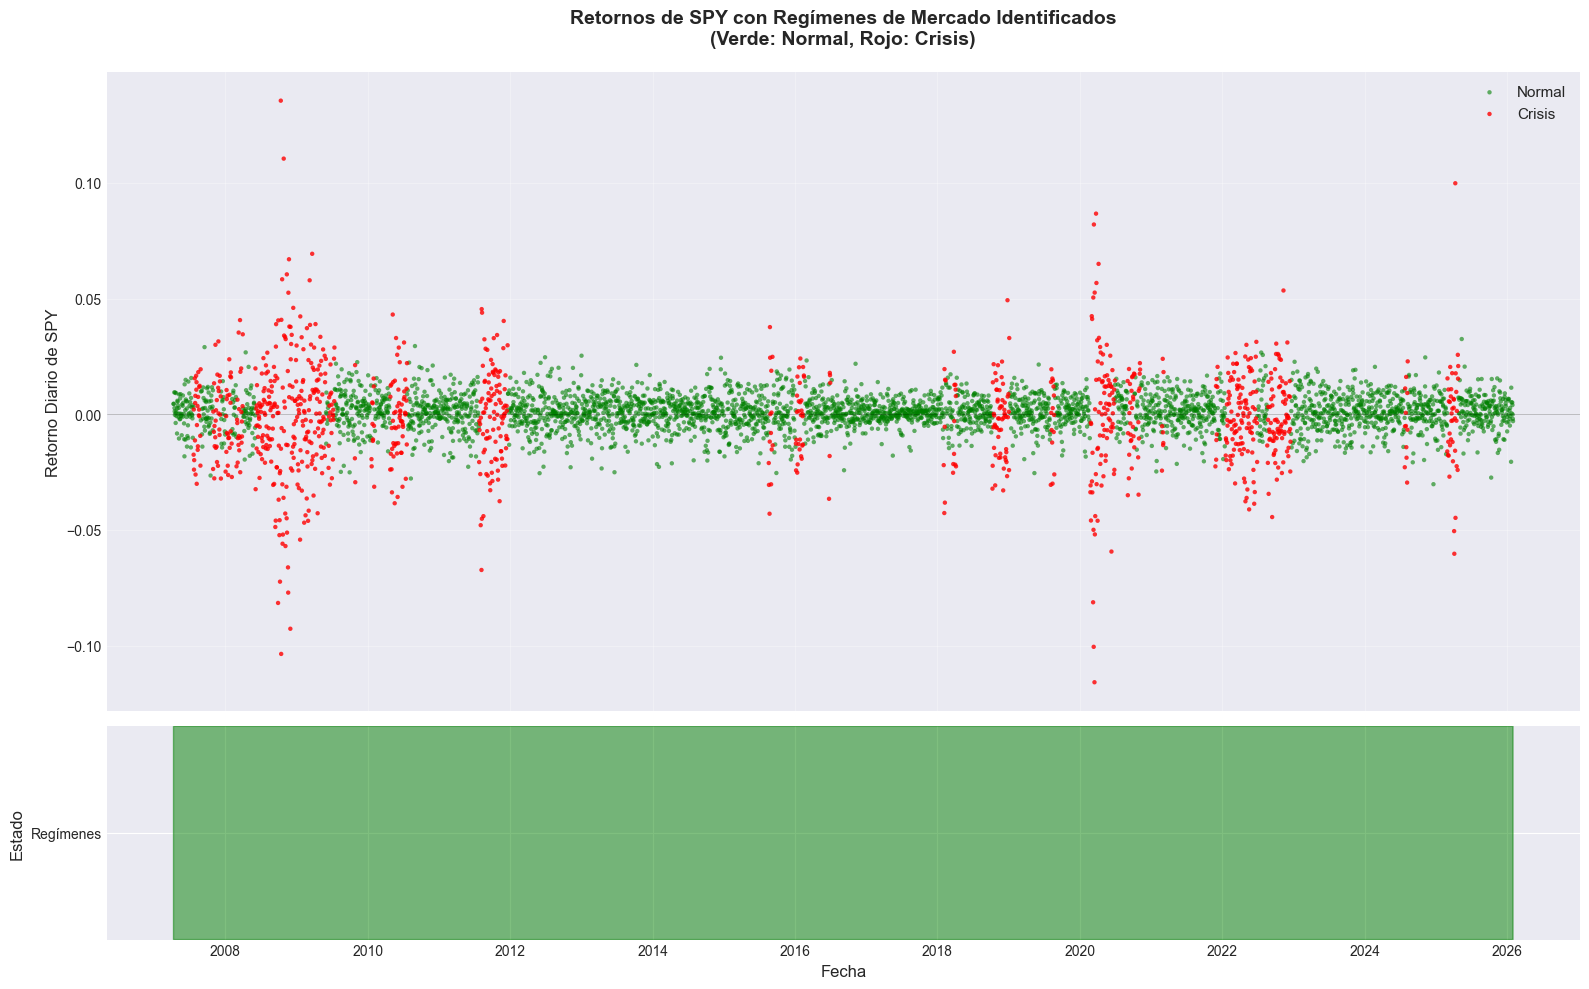


Períodos identificados por estado:

Normal:
  Primer fecha: 2007-04-12
  Última fecha: 2026-01-30
  Total de días: 3658
  Proporción temporal: 77.30%

Crisis:
  Primer fecha: 2007-07-24
  Última fecha: 2025-04-24
  Total de días: 1074
  Proporción temporal: 22.70%


In [24]:
# Visualización: Serie temporal de retornos de SPY con código de colores por estado
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, height_ratios=[3, 1])

# Gráfico superior: Retornos de SPY con colores según estado
for state_num, state_name in state_labels.items():
    mask = states == state_num
    state_dates = observable_dates[mask]
    state_returns = observable_returns[mask.flatten()]
    
    color = 'green' if state_name == 'Normal' else 'red'
    alpha = 0.6 if state_name == 'Normal' else 0.8
    ax1.scatter(state_dates, state_returns, c=color, label=state_name, 
               alpha=alpha, s=10, edgecolors='none')

ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.set_ylabel('Retorno Diario de SPY', fontsize=12)
ax1.set_title('Retornos de SPY con Regímenes de Mercado Identificados\n(Verde: Normal, Rojo: Crisis)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Gráfico inferior: Indicador de estado
state_colors = ['green' if s == normal_state else 'red' for s in states]
ax2.fill_between(observable_dates, 0, 1, color=state_colors, alpha=0.5)
ax2.set_ylabel('Estado', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.set_yticks([0.5])
ax2.set_yticklabels(['Regímenes'])
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Estadísticas de períodos
print("\nPeríodos identificados por estado:")
print("="*70)
for state_name in state_labels.values():
    state_mask = states == [k for k, v in state_labels.items() if v == state_name][0]
    state_dates = observable_dates[state_mask]
    if len(state_dates) > 0:
        print(f"\n{state_name}:")
        print(f"  Primer fecha: {state_dates[0].strftime('%Y-%m-%d')}")
        print(f"  Última fecha: {state_dates[-1].strftime('%Y-%m-%d')}")
        print(f"  Total de días: {len(state_dates)}")
        print(f"  Proporción temporal: {100*len(state_dates)/len(states):.2f}%")

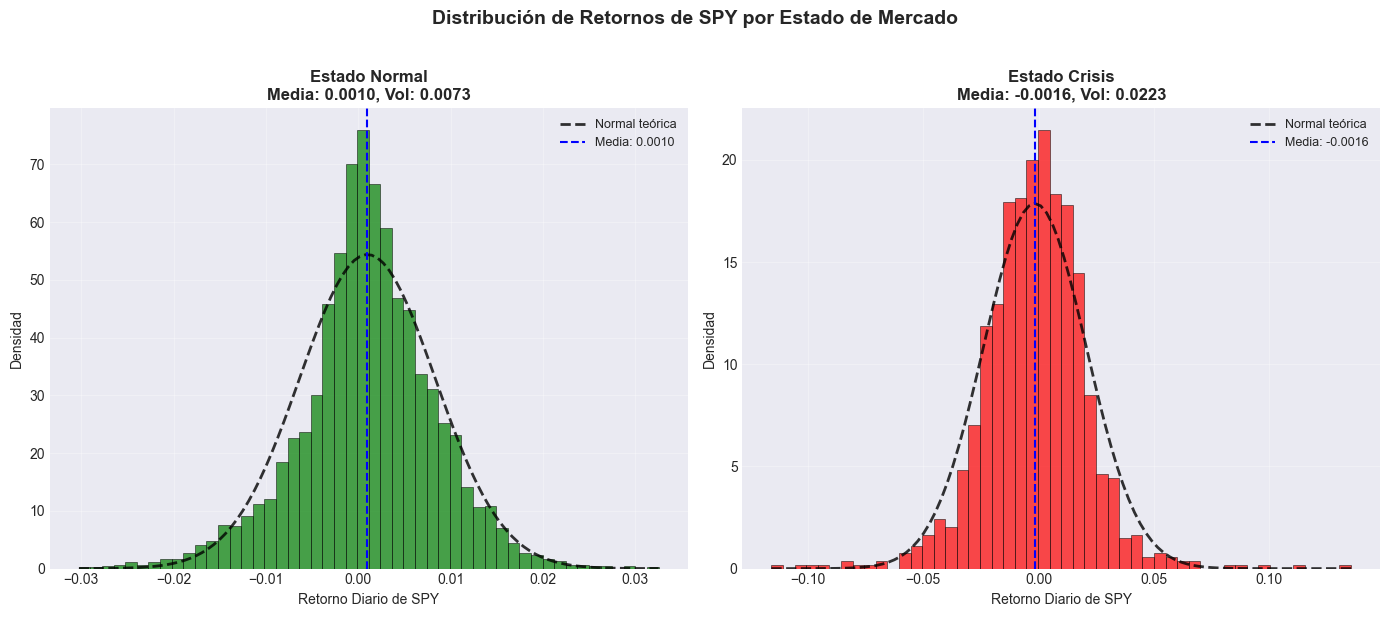

In [25]:
# Histogramas comparativos de retornos de SPY en cada estado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (state_name, state_num) in enumerate([(v, k) for k, v in state_labels.items()]):
    ax = axes[idx]
    mask = states == state_num
    state_returns = observable_returns[mask.flatten()]
    
    # Histograma
    ax.hist(state_returns, bins=50, density=True, alpha=0.7, 
           color='green' if state_name == 'Normal' else 'red',
           edgecolor='black', linewidth=0.5)
    
    # Estadísticas
    mean = state_returns.mean()
    std = state_returns.std()
    
    # Curva normal teórica
    x = np.linspace(state_returns.min(), state_returns.max(), 100)
    normal_curve = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    ax.plot(x, normal_curve, 'k--', linewidth=2, label='Normal teórica', alpha=0.8)
    
    ax.axvline(mean, color='blue', linestyle='--', linewidth=1.5, label=f'Media: {mean:.4f}')
    
    ax.set_title(f'Estado {state_name}\nMedia: {mean:.4f}, Vol: {std:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Retorno Diario de SPY', fontsize=10)
    ax.set_ylabel('Densidad', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribución de Retornos de SPY por Estado de Mercado', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

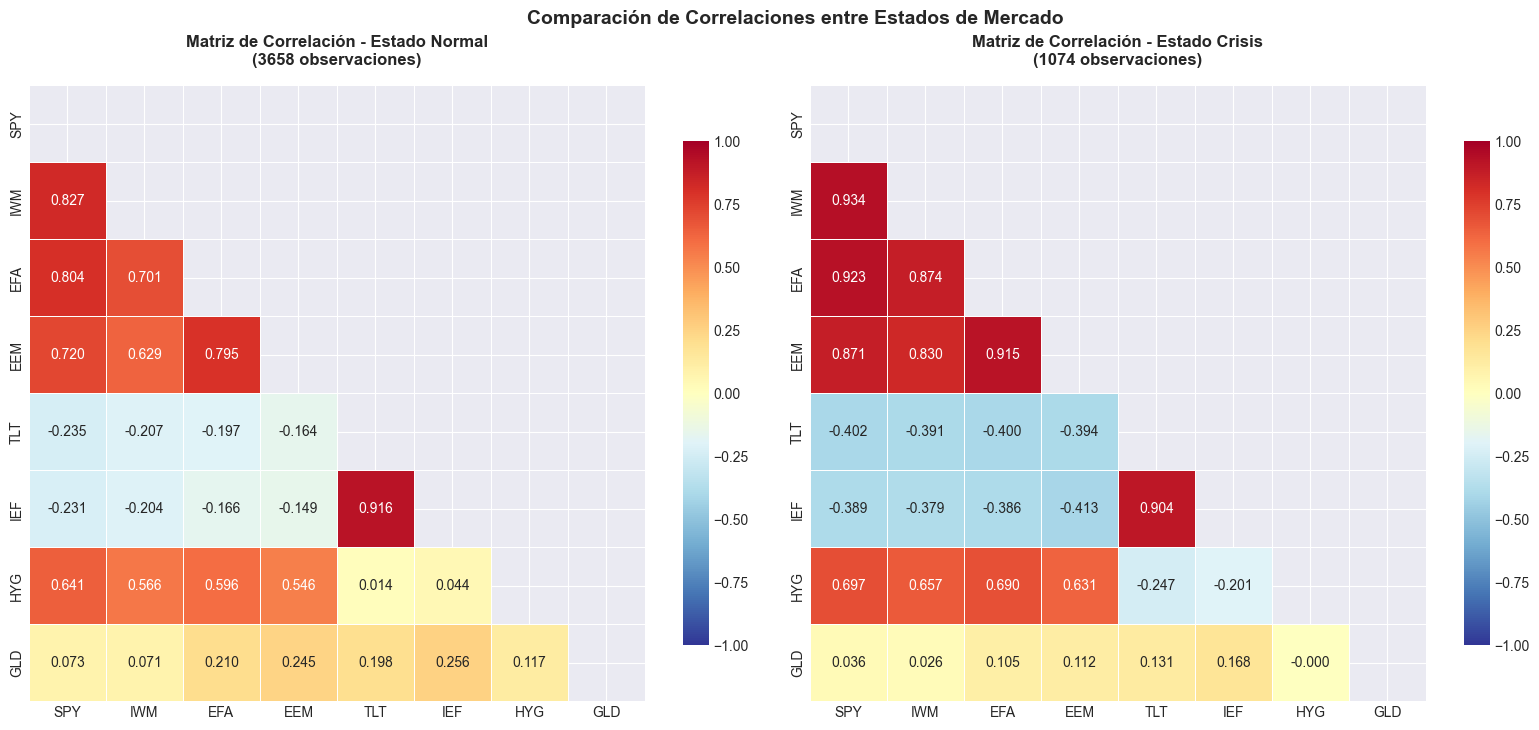

In [26]:
# Heatmaps lado a lado de correlación en cada estado
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, state_name in enumerate(['Normal', 'Crisis']):
    ax = axes[idx]
    corr_matrix = correlation_by_state[state_name]
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.8}, mask=mask, ax=ax)
    
    ax.set_title(f'Matriz de Correlación - Estado {state_name}\n({len(returns_by_state[state_name])} observaciones)', 
                 fontsize=12, fontweight='bold', pad=15)

plt.suptitle('Comparación de Correlaciones entre Estados de Mercado', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

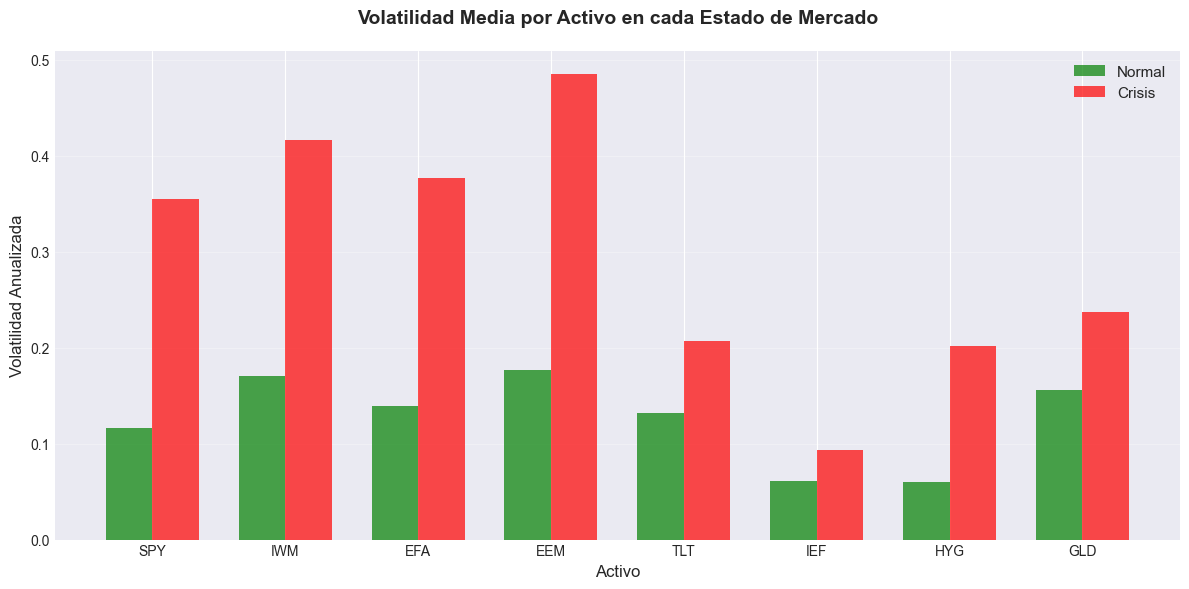

In [27]:
# Gráfico de barras: volatilidad anualizada por activo en cada estado
volatility_data = []
for ticker in returns.columns:
    for state_name in ['Normal', 'Crisis']:
        if ticker in conditional_stats[state_name]:
            vol = conditional_stats[state_name][ticker]['volatility_annualized']
            volatility_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'Volatilidad': vol
            })

vol_df = pd.DataFrame(volatility_data)

# Crear gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(returns.columns))
width = 0.35

normal_vols = [vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Normal')]['Volatilidad'].values[0] 
               if len(vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Normal')]) > 0 else 0
               for ticker in returns.columns]
crisis_vols = [vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Crisis')]['Volatilidad'].values[0] 
               if len(vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Crisis')]) > 0 else 0
               for ticker in returns.columns]

bars1 = ax.bar(x - width/2, normal_vols, width, label='Normal', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, crisis_vols, width, label='Crisis', color='red', alpha=0.7)

ax.set_xlabel('Activo', fontsize=12)
ax.set_ylabel('Volatilidad Anualizada', fontsize=12)
ax.set_title('Volatilidad Media por Activo en cada Estado de Mercado', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(returns.columns)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Identificamos eventos históricos de crisis.

In [28]:
# Identificar períodos continuos de crisis
crisis_mask = states == crisis_state
crisis_dates = observable_dates[crisis_mask]

# Encontrar períodos continuos de crisis
crisis_periods = []
in_crisis = False
start_date = None

for i, (date, is_crisis) in enumerate(zip(observable_dates, crisis_mask)):
    if is_crisis and not in_crisis:
        # Inicio de período de crisis
        start_date = date
        in_crisis = True
    elif not is_crisis and in_crisis:
        # Fin de período de crisis
        end_date = observable_dates[i-1]
        duration = (end_date - start_date).days
        crisis_periods.append({
            'start': start_date,
            'end': end_date,
            'duration_days': duration,
            'duration_years': duration / 252
        })
        in_crisis = False

# Si terminamos en crisis, agregar el último período
if in_crisis:
    end_date = observable_dates[-1]
    duration = (end_date - start_date).days
    crisis_periods.append({
        'start': start_date,
        'end': end_date,
        'duration_days': duration,
        'duration_years': duration / 252
    })

print("Períodos Históricos Identificados como Crisis")
print("="*80)
for i, period in enumerate(crisis_periods, 1):
    print(f"\nCrisis {i}:")
    print(f"  Inicio: {period['start'].strftime('%Y-%m-%d')}")
    print(f"  Fin: {period['end'].strftime('%Y-%m-%d')}")
    print(f"  Duración: {period['duration_days']} días ({period['duration_years']:.2f} años)")

# Eventos históricos conocidos para comparación
known_events = {
    '2007-10-01': 'Inicio Crisis Financiera Global',
    '2008-09-15': 'Quiebra de Lehman Brothers',
    '2009-03-09': 'Mínimo del mercado post-crisis',
    '2010-05-06': 'Flash Crash',
    '2011-08-01': 'Crisis de Deuda Europea',
    '2015-08-24': 'Flash Crash China',
    '2020-03-23': 'Mínimo COVID-19',
    '2022-01-03': 'Inicio corrección 2022'
}

print("\n" + "="*80)
print("Comparación con Eventos Históricos Conocidos:")
print("="*80)
for event_date_str, event_name in known_events.items():
    event_date = pd.to_datetime(event_date_str)
    if event_date >= observable_dates[0] and event_date <= observable_dates[-1]:
        # Encontrar el estado en esa fecha
        # Convertir TimedeltaIndex a valores numéricos para poder usar abs()
        time_diffs = pd.Series(observable_dates - event_date).abs()
        closest_idx = time_diffs.argmin()
        state_at_event = states[closest_idx]
        state_name = state_labels[state_at_event]
        marker = "✓" if state_name == 'Crisis' else "✗"
        print(f"{marker} {event_date_str}: {event_name} - Estado identificado: {state_name}")

Períodos Históricos Identificados como Crisis

Crisis 1:
  Inicio: 2007-07-24
  Fin: 2007-08-29
  Duración: 36 días (0.14 años)

Crisis 2:
  Inicio: 2007-11-01
  Fin: 2007-12-11
  Duración: 40 días (0.16 años)

Crisis 3:
  Inicio: 2008-01-04
  Fin: 2008-02-05
  Duración: 32 días (0.13 años)

Crisis 4:
  Inicio: 2008-02-29
  Fin: 2008-04-01
  Duración: 32 días (0.13 años)

Crisis 5:
  Inicio: 2008-06-05
  Fin: 2009-06-01
  Duración: 361 días (1.43 años)

Crisis 6:
  Inicio: 2009-06-15
  Fin: 2009-07-15
  Duración: 30 días (0.12 años)

Crisis 7:
  Inicio: 2009-10-28
  Fin: 2009-10-30
  Duración: 2 días (0.01 años)

Crisis 8:
  Inicio: 2010-01-21
  Fin: 2010-02-04
  Duración: 14 días (0.06 años)

Crisis 9:
  Inicio: 2010-04-27
  Fin: 2010-07-22
  Duración: 86 días (0.34 años)

Crisis 10:
  Inicio: 2011-07-27
  Fin: 2011-12-20
  Duración: 146 días (0.58 años)

Crisis 11:
  Inicio: 2015-08-20
  Fin: 2015-09-09
  Duración: 20 días (0.08 años)

Crisis 12:
  Inicio: 2016-01-06
  Fin: 2016-02-1

In [ ]:
# Verificación final de variables clave
print("="*80)
print("VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES")
print("="*80)

variables_to_check = {
    'states': 'Secuencia histórica de estados identificados',
    'state_labels': 'Mapeo de estados a etiquetas (Normal/Crisis)',
    'transition_matrix': 'Matriz de transición entre estados',
    'returns_by_state': 'Retornos segregados por estado',
    'observable_dates': 'Fechas correspondientes a los estados'
}

for var_name, description in variables_to_check.items():
    exists = var_name in globals()
    status = "✓" if exists else "✗"
    print(f"{status} {var_name}: {description}")
    if exists:
        if var_name == 'states':
            print(f"    Tipo: {type(globals()[var_name])}, Longitud: {len(globals()[var_name])}")
        elif var_name == 'state_labels':
            print(f"    Contenido: {globals()[var_name]}")
        elif var_name == 'transition_matrix':
            print(f"    Dimensiones: {globals()[var_name].shape}")
        elif var_name == 'returns_by_state':
            states_in_dict = list(globals()[var_name].keys())
            print(f"    Estados disponibles: {states_in_dict}")

print("\n" + "="*80)
print("RESUMEN DEL MODELO")
print("="*80)
print(f"Estados identificados: {list(state_labels.values())}")
print(f"Total de observaciones: {len(states)}")
print(f"Proporción Normal: {100*np.sum(states == normal_state)/len(states):.2f}%")
print(f"Proporción Crisis: {100*np.sum(states == crisis_state)/len(states):.2f}%")
print(f"Persistencia Normal: {persistence['Normal']:.4f}")
print(f"Persistencia Crisis: {persistence['Crisis']:.4f}")

print("\n✓ Fase 2 completada. Modelo de regímenes listo para uso en stress testing.")

VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES
✓ states: Secuencia histórica de estados identificados
    Tipo: <class 'numpy.ndarray'>, Longitud: 4732
✓ state_labels: Mapeo de estados a etiquetas (Normal/Crisis)
    Contenido: {np.int64(0): 'Normal', np.int64(1): 'Crisis'}
✓ transition_matrix: Matriz de transición entre estados
    Dimensiones: (2, 2)
✓ returns_by_state: Retornos segregados por estado
    Estados disponibles: ['Normal', 'Crisis']
✓ observable_dates: Fechas correspondientes a los estados

RESUMEN DEL MODELO
Estados identificados: ['Normal', 'Crisis']
Total de observaciones: 4732
Proporción Normal: 77.30%
Proporción Crisis: 22.70%
Persistencia Normal: 0.9863
Persistencia Crisis: 0.9553

✓ Sección 2 completada. Modelo de regímenes listo para uso en stress testing.


## Fase 3: Modelización de Distribuciones de Retornos por Estado de Mercado

In [30]:
# Importaciones adicionales para modelización de distribuciones
from scipy import stats
from scipy.stats import t as t_distribution
from scipy.stats import kstest
from scipy.integrate import quad

# Verificar que tenemos las variables necesarias de secciones anteriores
required_vars = ['returns', 'states', 'state_labels', 'returns_by_state', 'observable_dates']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    raise ValueError(f"Error: Variables faltantes de secciones anteriores: {missing_vars}")

print("="*80)
print("VERIFICACIÓN DE VARIABLES DE SECCIONES ANTERIORES")
print("="*80)
for var in required_vars:
    status = "✓" if var in globals() else "✗"
    print(f"{status} {var}: {'disponible' if var in globals() else 'FALTANTE'}")

print(f"\nEstados identificados: {list(state_labels.values())}")
print(f"Activos disponibles: {list(returns.columns)}")
print(f"Total de observaciones: {len(returns)}")

VERIFICACIÓN DE VARIABLES DE SECCIONES ANTERIORES
✓ returns: disponible
✓ states: disponible
✓ state_labels: disponible
✓ returns_by_state: disponible
✓ observable_dates: disponible

Estados identificados: ['Normal', 'Crisis']
Activos disponibles: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']
Total de observaciones: 4732


Segregamos los retornos por activo y estado.

In [ ]:
# Segregar retornos por activo y estado
# Ya tenemos returns_by_state de la fase anterior, pero vamos a organizarlo mejor

returns_by_asset_state = {}
sample_sizes = {}

print("Segregación de Retornos por Activo y Estado")
print("="*80)

for ticker in returns.columns:
    returns_by_asset_state[ticker] = {}
    sample_sizes[ticker] = {}
    
    for state_name in state_labels.values():
        # Obtener retornos de este activo en este estado
        state_returns = returns_by_state[state_name][ticker].dropna()
        returns_by_asset_state[ticker][state_name] = state_returns
        sample_sizes[ticker][state_name] = len(state_returns)
        
        print(f"{ticker} - {state_name}: {len(state_returns)} observaciones")

print("\n" + "="*80)
print("Resumen de tamaños de muestra:")
print("="*80)
sample_df = pd.DataFrame(sample_sizes).T
print(sample_df)

# Verificar que hay suficientes observaciones para estimación
min_obs_required = 50
print(f"\nValidación: Mínimo de {min_obs_required} observaciones requeridas")
for ticker in returns.columns:
    for state_name in state_labels.values():
        n_obs = sample_sizes[ticker][state_name]
        if n_obs < min_obs_required:
            print(f"⚠ Advertencia: {ticker} - {state_name} tiene solo {n_obs} observaciones")
        else:
            print(f"✓ {ticker} - {state_name}: {n_obs} observaciones (suficiente)")

Segregación de Retornos por Activo y Estado
SPY - Normal: 3658 observaciones
SPY - Crisis: 1074 observaciones
IWM - Normal: 3658 observaciones
IWM - Crisis: 1074 observaciones
EFA - Normal: 3658 observaciones
EFA - Crisis: 1074 observaciones
EEM - Normal: 3658 observaciones
EEM - Crisis: 1074 observaciones
TLT - Normal: 3658 observaciones
TLT - Crisis: 1074 observaciones
IEF - Normal: 3658 observaciones
IEF - Crisis: 1074 observaciones
HYG - Normal: 3658 observaciones
HYG - Crisis: 1074 observaciones
GLD - Normal: 3658 observaciones
GLD - Crisis: 1074 observaciones

Resumen de tamaños de muestra:
     Normal  Crisis
SPY    3658    1074
IWM    3658    1074
EFA    3658    1074
EEM    3658    1074
TLT    3658    1074
IEF    3658    1074
HYG    3658    1074
GLD    3658    1074

Validación: Mínimo de 50 observaciones requeridas
✓ SPY - Normal: 3658 observaciones (suficiente)
✓ SPY - Crisis: 1074 observaciones (suficiente)
✓ IWM - Normal: 3658 observaciones (suficiente)
✓ IWM - Crisis: 1074 

Ajustamos distribuciones t de Student para cada activo y estado.

In [43]:
# Ajustar distribuciones t de Student para cada activo y estado
fitted_distributions = {}
distribution_params = {}

print("Ajuste de Distribuciones t de Student")
print("="*80)

for ticker in returns.columns:
    fitted_distributions[ticker] = {}
    distribution_params[ticker] = {}
    
    for state_name in state_labels.values():
        data = returns_by_asset_state[ticker][state_name].values
        
        if len(data) >= min_obs_required:
            # Ajustar distribución t de Student usando máxima verosimilitud
            # scipy.stats.t.fit estima: df (grados de libertad), loc (media), scale (escala)
            try:
                df, loc, scale = t_distribution.fit(data)
                fitted_dist = t_distribution(df=df, loc=loc, scale=scale)
                
                fitted_distributions[ticker][state_name] = fitted_dist
                distribution_params[ticker][state_name] = {
                    'df': df,  # Grados de libertad
                    'loc': loc,  # Localización (media)
                    'scale': scale,  # Escala (desviación estándar ajustada)
                    'mean': loc,
                    'std': scale * np.sqrt(df / (df - 2)) if df > 2 else np.nan  # Desv. estándar teórica
                }
                
                print(f"✓ {ticker} - {state_name}: df={df:.2f}, loc={loc:.6f}, scale={scale:.6f}")
            except Exception as e:
                print(f"✗ Error ajustando {ticker} - {state_name}: {str(e)}")
                fitted_distributions[ticker][state_name] = None
                distribution_params[ticker][state_name] = None
        else:
            print(f"⚠ {ticker} - {state_name}: Insuficientes observaciones ({len(data)})")
            fitted_distributions[ticker][state_name] = None
            distribution_params[ticker][state_name] = None

print("\n" + "="*80)
print("Parámetros Ajustados - Resumen")
print("="*80)
# Crear DataFrame con parámetros
params_data = []
for ticker in returns.columns:
    for state_name in state_labels.values():
        if distribution_params[ticker][state_name] is not None:
            params = distribution_params[ticker][state_name]
            params_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'Grados Libertad (df)': params['df'],
                'Media (loc)': params['loc'],
                'Escala (scale)': params['scale'],
                'Desv. Est. Teórica': params['std']
            })

params_df = pd.DataFrame(params_data)
print(params_df.round(4))

Ajuste de Distribuciones t de Student
✓ SPY - Normal: df=5.67, loc=0.001107, scale=0.005995
✓ SPY - Crisis: df=4.86, loc=-0.001333, scale=0.017027
✓ IWM - Normal: df=9.61, loc=0.001007, scale=0.009556
✓ IWM - Crisis: df=6.35, loc=-0.001822, scale=0.021709
✓ EFA - Normal: df=5.86, loc=0.000869, scale=0.007207
✓ EFA - Crisis: df=3.50, loc=-0.001119, scale=0.016119
✓ EEM - Normal: df=8.95, loc=0.000794, scale=0.009840
✓ EEM - Crisis: df=3.06, loc=-0.001351, scale=0.019288
✓ TLT - Normal: df=15.10, loc=0.000068, scale=0.007759
✓ TLT - Crisis: df=5.39, loc=0.000453, scale=0.010332
✓ IEF - Normal: df=2.01, loc=-0.000073, scale=0.002668
✓ IEF - Crisis: df=6.59, loc=0.000377, scale=0.004926
✓ HYG - Normal: df=3.13, loc=0.000357, scale=0.002463
✓ HYG - Crisis: df=2.29, loc=-0.000172, scale=0.006394
✓ GLD - Normal: df=4.20, loc=0.000616, scale=0.007121
✓ GLD - Crisis: df=3.88, loc=0.000523, scale=0.010683

Parámetros Ajustados - Resumen
   Ticker  Estado  Grados Libertad (df)  Media (loc)  Escal

In [44]:
# Niveles de confianza para VaR y CVaR
confidence_levels = [0.95, 0.99]
alpha_levels = [0.05, 0.01]  # Niveles de significancia (1 - confianza)

# Calcular VaR y CVaR para cada activo y estado
risk_metrics = {}

print("Cálculo de VaR y CVaR")
print("="*80)

for ticker in returns.columns:
    risk_metrics[ticker] = {}
    
    for state_name in state_labels.values():
        risk_metrics[ticker][state_name] = {}
        
        if fitted_distributions[ticker][state_name] is not None:
            dist = fitted_distributions[ticker][state_name]
            data = returns_by_asset_state[ticker][state_name].values
            
            for conf, alpha in zip(confidence_levels, alpha_levels):
                # VaR: Percentil (1 - confianza) de la distribución
                # Como trabajamos con retornos (pérdidas negativas), VaR es el percentil alpha
                var = dist.ppf(alpha)  # Percentil alpha (ej: 0.05 para 95% confianza)
                
                # CVaR (Expected Shortfall): Media condicional de pérdidas más allá del VaR
                # CVaR = E[X | X <= VaR]
                # Para distribución t: CVaR = (1/alpha) * integral de -inf a VaR de x * f(x) dx
                # Usamos integración numérica
                def integrand(x):
                    return x * dist.pdf(x)
                
                # Integrar desde -infinito hasta VaR
                # Usamos un límite inferior razonable (percentil 0.001)
                lower_bound = dist.ppf(0.001)
                integral, _ = quad(integrand, lower_bound, var)
                cvar = (1 / alpha) * integral
                
                risk_metrics[ticker][state_name][f'VaR_{int(conf*100)}'] = var
                risk_metrics[ticker][state_name][f'CVaR_{int(conf*100)}'] = cvar
                
                # Calcular también ratio CVaR/VaR
                risk_metrics[ticker][state_name][f'CVaR_VaR_ratio_{int(conf*100)}'] = cvar / var if var != 0 else np.nan
            
            print(f"✓ {ticker} - {state_name}: VaR_95={risk_metrics[ticker][state_name]['VaR_95']:.6f}, "
                  f"CVaR_95={risk_metrics[ticker][state_name]['CVaR_95']:.6f}")
        else:
            print(f"⚠ {ticker} - {state_name}: No se pudo calcular (distribución no ajustada)")

print("\n" + "="*80)

Cálculo de VaR y CVaR
✓ SPY - Normal: VaR_95=-0.010663, CVaR_95=-0.014658
✓ SPY - Crisis: VaR_95=-0.035854, CVaR_95=-0.048431
✓ IWM - Normal: VaR_95=-0.016383, CVaR_95=-0.021249
✓ IWM - Crisis: VaR_95=-0.043591, CVaR_95=-0.056959
✓ EFA - Normal: VaR_95=-0.013198, CVaR_95=-0.017895
✓ EFA - Crisis: VaR_95=-0.036933, CVaR_95=-0.053131
✓ EEM - Normal: VaR_95=-0.017257, CVaR_95=-0.022406
✓ EEM - Crisis: VaR_95=-0.046371, CVaR_95=-0.069124
✓ TLT - Normal: VaR_95=-0.013528, CVaR_95=-0.016962
✓ TLT - Crisis: VaR_95=-0.020040, CVaR_95=-0.027141
✓ IEF - Normal: VaR_95=-0.007829, CVaR_95=-0.014014
✓ IEF - Crisis: VaR_95=-0.009044, CVaR_95=-0.012029
✓ HYG - Normal: VaR_95=-0.005346, CVaR_95=-0.008188
✓ HYG - Crisis: VaR_95=-0.017324, CVaR_95=-0.028987
✓ GLD - Normal: VaR_95=-0.014363, CVaR_95=-0.020348
✓ GLD - Crisis: VaR_95=-0.022452, CVaR_95=-0.032112



In [45]:
# Crear tabla resumen de métricas de riesgo
risk_summary_data = []

for ticker in returns.columns:
    for state_name in state_labels.values():
        if risk_metrics[ticker].get(state_name):
            row = {
                'Ticker': ticker,
                'Estado': state_name,
                'VaR_95': risk_metrics[ticker][state_name]['VaR_95'],
                'CVaR_95': risk_metrics[ticker][state_name]['CVaR_95'],
                'CVaR_VaR_ratio_95': risk_metrics[ticker][state_name]['CVaR_VaR_ratio_95'],
                'VaR_99': risk_metrics[ticker][state_name]['VaR_99'],
                'CVaR_99': risk_metrics[ticker][state_name]['CVaR_99'],
                'CVaR_VaR_ratio_99': risk_metrics[ticker][state_name]['CVaR_VaR_ratio_99']
            }
            risk_summary_data.append(row)

risk_summary_df = pd.DataFrame(risk_summary_data)

print("Tabla Resumen de Métricas de Riesgo")
print("="*80)
print(risk_summary_df.round(6))

# Validaciones
print("\n" + "="*80)
print("VALIDACIONES")
print("="*80)

# Verificar que CVaR > VaR (debe ser más negativo, ya que son pérdidas)
for ticker in returns.columns:
    for state_name in state_labels.values():
        if risk_metrics[ticker].get(state_name):
            for conf in [95, 99]:
                var = risk_metrics[ticker][state_name][f'VaR_{conf}']
                cvar = risk_metrics[ticker][state_name][f'CVaR_{conf}']
                if cvar > var:  # CVaR debe ser más negativo (mayor pérdida)
                    print(f"✓ {ticker} - {state_name} - {conf}%: CVaR ({cvar:.6f}) > VaR ({var:.6f}) ✓")
                else:
                    print(f"⚠ {ticker} - {state_name} - {conf}%: CVaR ({cvar:.6f}) <= VaR ({var:.6f}) ⚠")

Tabla Resumen de Métricas de Riesgo
   Ticker  Estado    VaR_95   CVaR_95  CVaR_VaR_ratio_95    VaR_99   CVaR_99  \
0     SPY  Normal -0.010663 -0.014658           1.374671 -0.018102 -0.019842   
1     SPY  Crisis -0.035854 -0.048431           1.350777 -0.059298 -0.065166   
2     IWM  Normal -0.016383 -0.021249           1.296960 -0.025600 -0.026891   
3     IWM  Crisis -0.043591 -0.056959           1.306683 -0.068795 -0.073538   
4     EFA  Normal -0.013198 -0.017895           1.355816 -0.021970 -0.023918   
5     EFA  Crisis -0.036933 -0.053131           1.438582 -0.066541 -0.077045   
6     EEM  Normal -0.017257 -0.022406           1.298374 -0.027005 -0.028437   
7     EEM  Crisis -0.046371 -0.069124           1.490663 -0.087529 -0.104364   
8     TLT  Normal -0.013528 -0.016962           1.253818 -0.020110 -0.020663   
9     TLT  Crisis -0.020040 -0.027141           1.354363 -0.033292 -0.036396   
10    IEF  Normal -0.007829 -0.014014           1.790124 -0.018486 -0.025375   
11  

Realizamos tests de bondad de ajuste para validar las distribuciones ajustadas.

In [46]:
# Tests de Kolmogorov-Smirnov para validar ajustes
ks_test_results = {}

print("Tests de Bondad de Ajuste (Kolmogorov-Smirnov)")
print("="*80)
print("H0: Los datos siguen la distribución t ajustada")
print("p-valor < 0.05: Rechazar H0 (ajuste no adecuado)")
print("p-valor >= 0.05: No rechazar H0 (ajuste razonable)")
print("="*80)

for ticker in returns.columns:
    ks_test_results[ticker] = {}
    
    for state_name in state_labels.values():
        if fitted_distributions[ticker][state_name] is not None:
            data = returns_by_asset_state[ticker][state_name].values
            dist = fitted_distributions[ticker][state_name]
            
            # Test de Kolmogorov-Smirnov
            ks_statistic, p_value = kstest(data, dist.cdf)
            
            ks_test_results[ticker][state_name] = {
                'ks_statistic': ks_statistic,
                'p_value': p_value,
                'reject_h0': p_value < 0.05
            }
            
            status = "✗ Rechazar H0" if p_value < 0.05 else "✓ No rechazar H0"
            print(f"{ticker} - {state_name}: KS={ks_statistic:.4f}, p={p_value:.4f} {status}")

# Crear DataFrame con resultados
ks_data = []
for ticker in returns.columns:
    for state_name in state_labels.values():
        if ticker in ks_test_results and state_name in ks_test_results[ticker]:
            result = ks_test_results[ticker][state_name]
            ks_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'KS_Statistic': result['ks_statistic'],
                'p_value': result['p_value'],
                'Ajuste_Adecuado': not result['reject_h0']
            })

ks_df = pd.DataFrame(ks_data)
print("\n" + "="*80)
print("Resumen de Tests K-S:")
print("="*80)
print(ks_df.round(4))

Tests de Bondad de Ajuste (Kolmogorov-Smirnov)
H0: Los datos siguen la distribución t ajustada
p-valor < 0.05: Rechazar H0 (ajuste no adecuado)
p-valor >= 0.05: No rechazar H0 (ajuste razonable)
SPY - Normal: KS=0.0236, p=0.0330 ✗ Rechazar H0
SPY - Crisis: KS=0.0152, p=0.9615 ✓ No rechazar H0
IWM - Normal: KS=0.0115, p=0.7097 ✓ No rechazar H0
IWM - Crisis: KS=0.0160, p=0.9430 ✓ No rechazar H0
EFA - Normal: KS=0.0124, p=0.6271 ✓ No rechazar H0
EFA - Crisis: KS=0.0188, p=0.8350 ✓ No rechazar H0
EEM - Normal: KS=0.0139, p=0.4795 ✓ No rechazar H0
EEM - Crisis: KS=0.0195, p=0.8031 ✓ No rechazar H0
TLT - Normal: KS=0.0200, p=0.1063 ✓ No rechazar H0
TLT - Crisis: KS=0.0189, p=0.8324 ✓ No rechazar H0
IEF - Normal: KS=0.0427, p=0.0000 ✗ Rechazar H0
IEF - Crisis: KS=0.0183, p=0.8574 ✓ No rechazar H0
HYG - Normal: KS=0.0122, p=0.6429 ✓ No rechazar H0
HYG - Crisis: KS=0.0149, p=0.9679 ✓ No rechazar H0
GLD - Normal: KS=0.0108, p=0.7853 ✓ No rechazar H0
GLD - Crisis: KS=0.0191, p=0.8188 ✓ No rechaza

Analizamos cómo cambian las métricas de riesgo entre estados Normal y Crisis.

In [47]:
# Análisis comparativo: cambio de riesgo entre estados
risk_change_analysis = []

for ticker in returns.columns:
    if (risk_metrics[ticker].get('Normal') and 
        risk_metrics[ticker].get('Crisis')):
        
        normal_metrics = risk_metrics[ticker]['Normal']
        crisis_metrics = risk_metrics[ticker]['Crisis']
        
        # Calcular cambios relativos
        var95_change = ((crisis_metrics['VaR_95'] - normal_metrics['VaR_95']) / 
                       abs(normal_metrics['VaR_95'])) * 100
        cvar95_change = ((crisis_metrics['CVaR_95'] - normal_metrics['CVaR_95']) / 
                        abs(normal_metrics['CVaR_95'])) * 100
        var99_change = ((crisis_metrics['VaR_99'] - normal_metrics['VaR_99']) / 
                       abs(normal_metrics['VaR_99'])) * 100
        cvar99_change = ((crisis_metrics['CVaR_99'] - normal_metrics['CVaR_99']) / 
                        abs(normal_metrics['CVaR_99'])) * 100
        
        # Cambio en grados de libertad
        if (distribution_params[ticker].get('Normal') and 
            distribution_params[ticker].get('Crisis')):
            df_normal = distribution_params[ticker]['Normal']['df']
            df_crisis = distribution_params[ticker]['Crisis']['df']
            df_change = df_crisis - df_normal
        else:
            df_normal = np.nan
            df_crisis = np.nan
            df_change = np.nan
        
        risk_change_analysis.append({
            'Ticker': ticker,
            'VaR_95_Normal': normal_metrics['VaR_95'],
            'VaR_95_Crisis': crisis_metrics['VaR_95'],
            'VaR_95_Change_%': var95_change,
            'CVaR_95_Normal': normal_metrics['CVaR_95'],
            'CVaR_95_Crisis': crisis_metrics['CVaR_95'],
            'CVaR_95_Change_%': cvar95_change,
            'VaR_99_Normal': normal_metrics['VaR_99'],
            'VaR_99_Crisis': crisis_metrics['VaR_99'],
            'VaR_99_Change_%': var99_change,
            'CVaR_99_Normal': normal_metrics['CVaR_99'],
            'CVaR_99_Crisis': crisis_metrics['CVaR_99'],
            'CVaR_99_Change_%': cvar99_change,
            'df_Normal': df_normal,
            'df_Crisis': df_crisis,
            'df_Change': df_change
        })

risk_change_df = pd.DataFrame(risk_change_analysis)

print("Análisis de Cambio de Riesgo: Crisis vs Normal")
print("="*80)
print("Valores positivos indican mayor riesgo (más negativo) en Crisis")
print(risk_change_df.round(4))

# Identificar activos con mayor cambio
print("\n" + "="*80)
print("Activos con Mayor Aumento de Riesgo en Crisis (Top 3 por CVaR 99%):")
print("="*80)
if len(risk_change_df) > 0:
    top_risk_changes = risk_change_df.nlargest(3, 'CVaR_99_Change_%')[['Ticker', 'CVaR_99_Change_%', 'CVaR_99_Normal', 'CVaR_99_Crisis']]
    print(top_risk_changes.round(4))

Análisis de Cambio de Riesgo: Crisis vs Normal
Valores positivos indican mayor riesgo (más negativo) en Crisis
  Ticker  VaR_95_Normal  VaR_95_Crisis  VaR_95_Change_%  CVaR_95_Normal  \
0    SPY        -0.0107        -0.0359        -236.2510         -0.0147   
1    IWM        -0.0164        -0.0436        -166.0669         -0.0212   
2    EFA        -0.0132        -0.0369        -179.8287         -0.0179   
3    EEM        -0.0173        -0.0464        -168.7129         -0.0224   
4    TLT        -0.0135        -0.0200         -48.1340         -0.0170   
5    IEF        -0.0078        -0.0090         -15.5204         -0.0140   
6    HYG        -0.0053        -0.0173        -224.0483         -0.0082   
7    GLD        -0.0144        -0.0225         -56.3131         -0.0203   

   CVaR_95_Crisis  CVaR_95_Change_%  VaR_99_Normal  VaR_99_Crisis  \
0         -0.0484         -230.4064        -0.0181        -0.0593   
1         -0.0570         -168.0614        -0.0256        -0.0688   
2     

Visualizaciones comparativas.

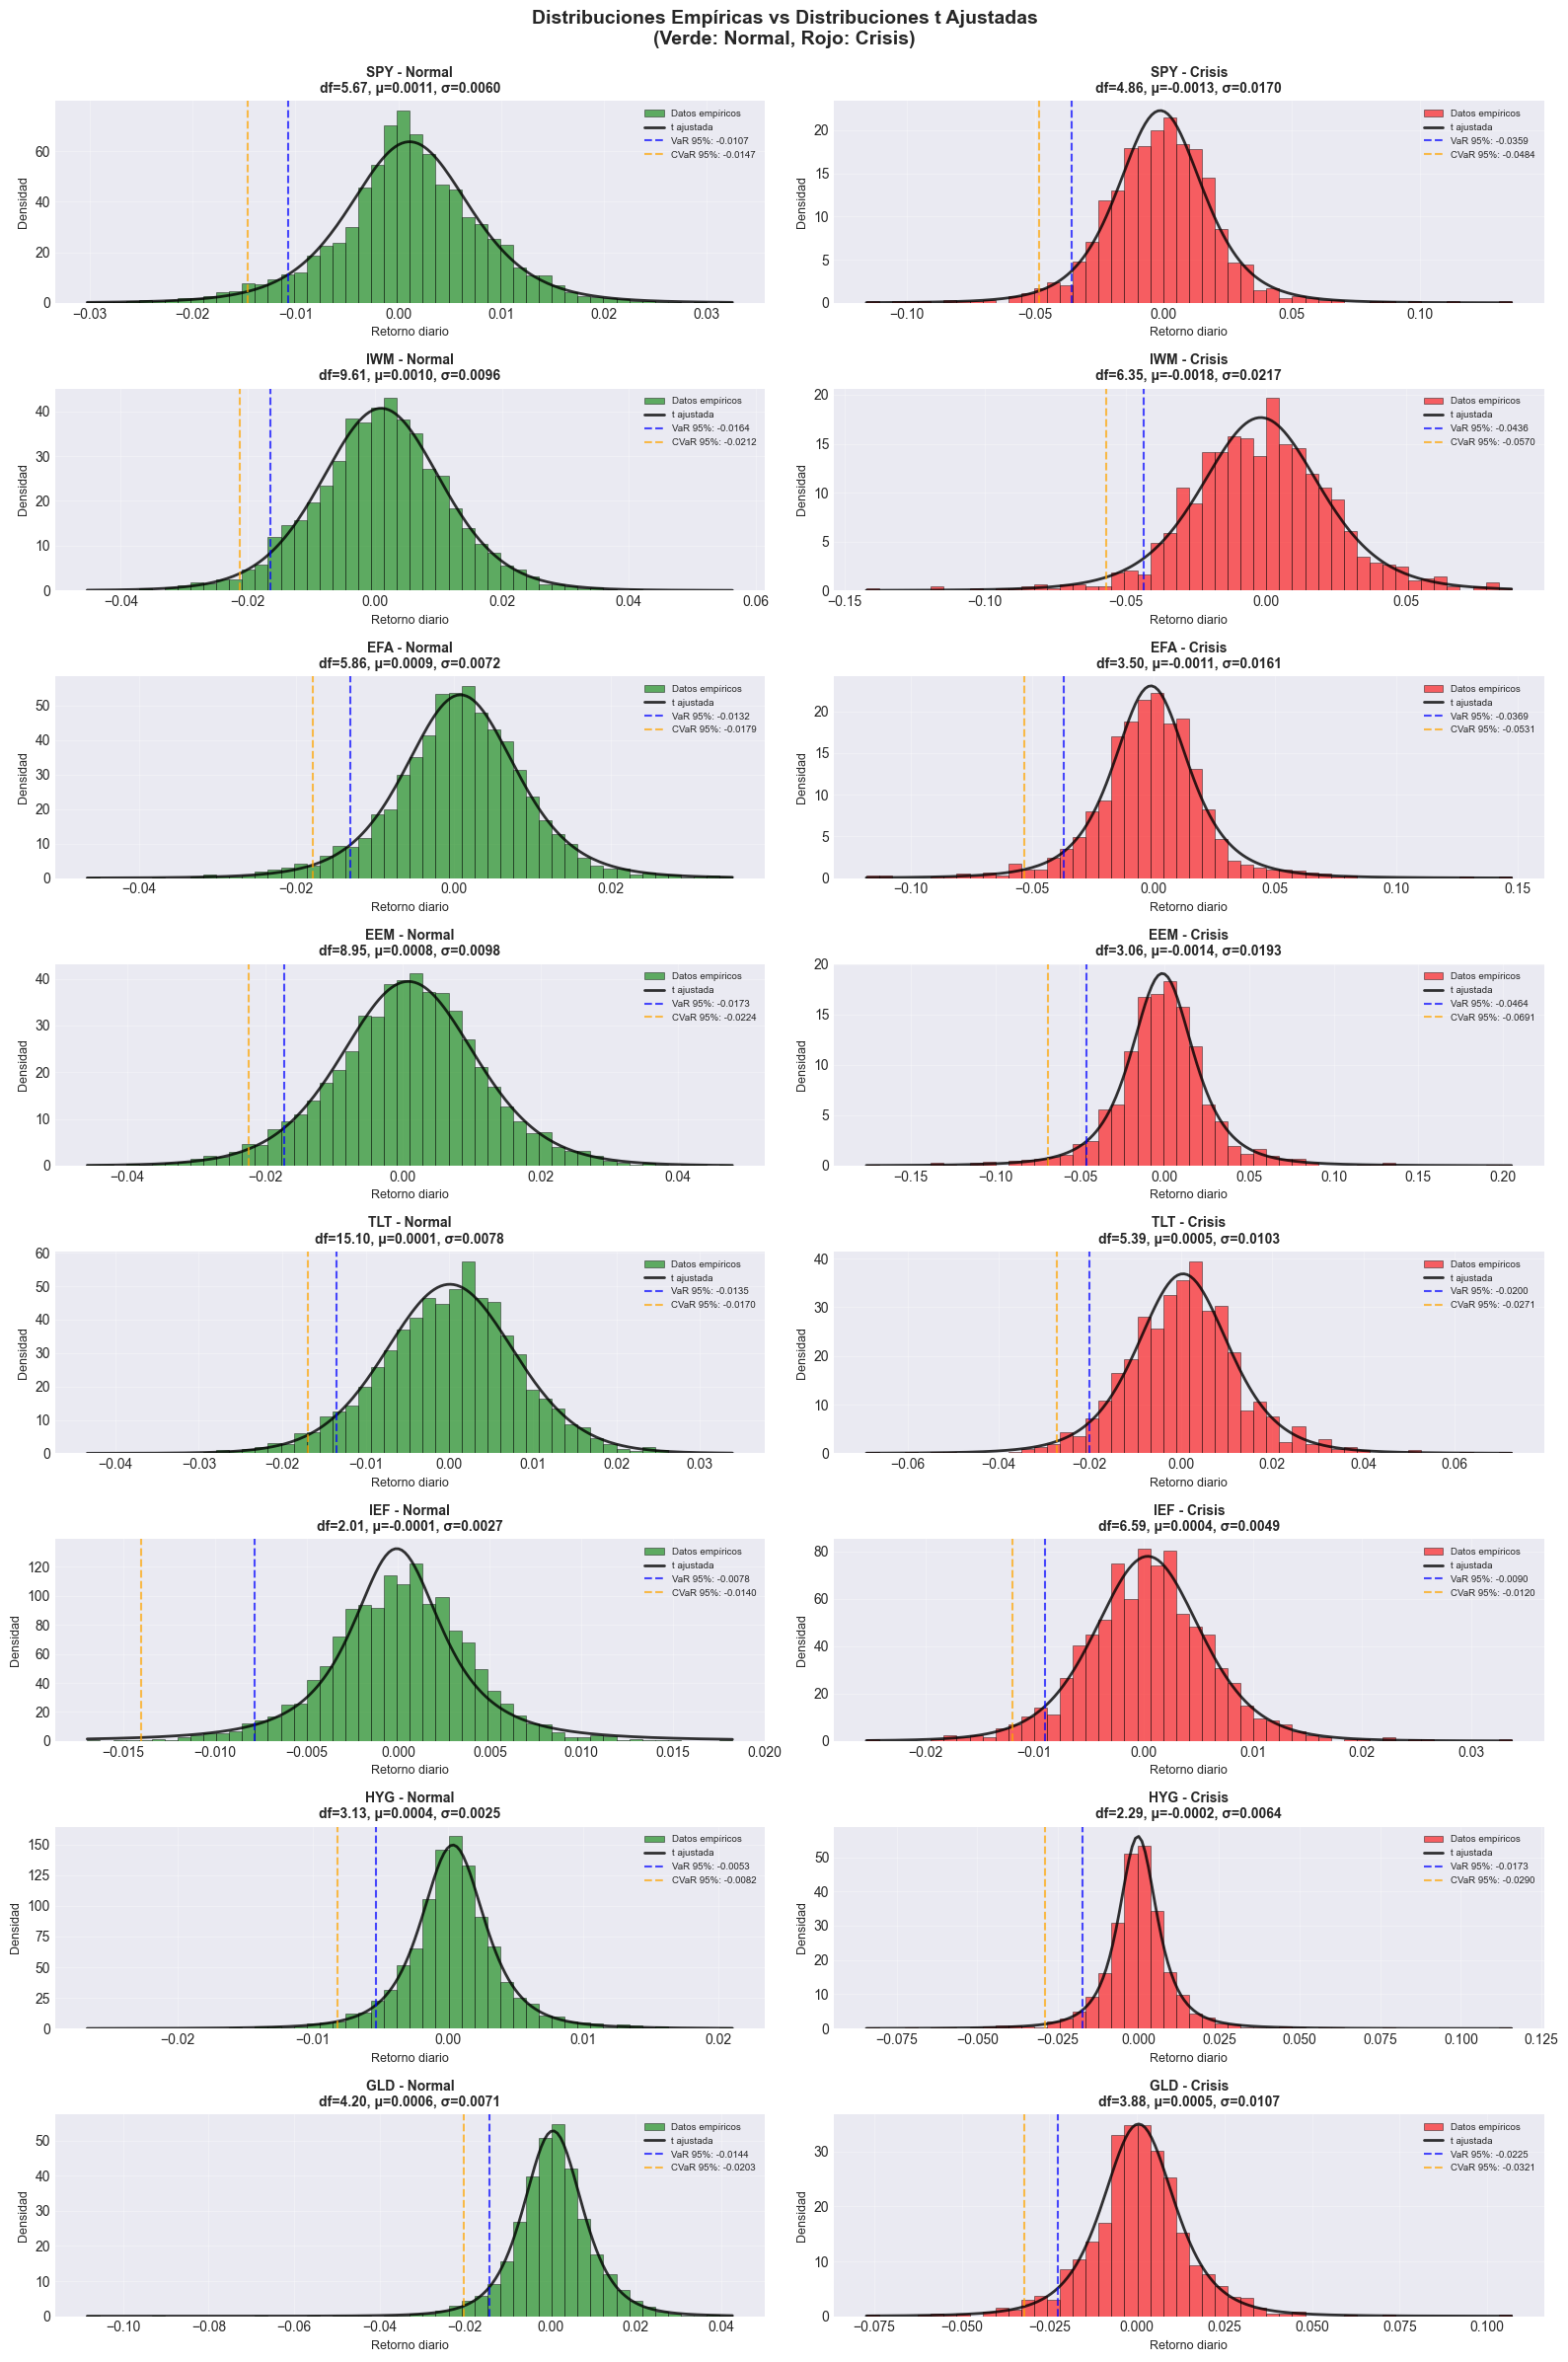

In [48]:
# Visualización: Histogramas empíricos vs distribuciones t ajustadas
# 8 filas (activos) x 2 columnas (Normal, Crisis)
fig, axes = plt.subplots(len(returns.columns), 2, figsize=(16, 24))

for row_idx, ticker in enumerate(returns.columns):
    for col_idx, state_name in enumerate(['Normal', 'Crisis']):
        ax = axes[row_idx, col_idx]
        
        if fitted_distributions[ticker].get(state_name) is not None:
            data = returns_by_asset_state[ticker][state_name].values
            dist = fitted_distributions[ticker][state_name]
            params = distribution_params[ticker][state_name]
            
            # Histograma empírico
            n, bins, patches = ax.hist(data, bins=50, density=True, alpha=0.6, 
                                       color='green' if state_name == 'Normal' else 'red',
                                       edgecolor='black', linewidth=0.5,
                                       label='Datos empíricos')
            
            # Distribución t ajustada
            x = np.linspace(data.min(), data.max(), 200)
            pdf = dist.pdf(x)
            ax.plot(x, pdf, 'k-', linewidth=2, label='t ajustada', alpha=0.8)
            
            # Líneas de VaR y CVaR
            if risk_metrics[ticker].get(state_name):
                var95 = risk_metrics[ticker][state_name]['VaR_95']
                cvar95 = risk_metrics[ticker][state_name]['CVaR_95']
                ax.axvline(var95, color='blue', linestyle='--', linewidth=1.5, 
                          label=f'VaR 95%: {var95:.4f}', alpha=0.7)
                ax.axvline(cvar95, color='orange', linestyle='--', linewidth=1.5, 
                          label=f'CVaR 95%: {cvar95:.4f}', alpha=0.7)
            
            # Título con parámetros
            title = f'{ticker} - {state_name}\ndf={params["df"]:.2f}, μ={params["loc"]:.4f}, σ={params["scale"]:.4f}'
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Retorno diario', fontsize=9)
            ax.set_ylabel('Densidad', fontsize=9)
            ax.legend(fontsize=7, loc='best')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Datos insuficientes\n{ticker} - {state_name}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{ticker} - {state_name}', fontsize=10)

plt.suptitle('Distribuciones Empíricas vs Distribuciones t Ajustadas\n(Verde: Normal, Rojo: Crisis)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 6.2. CVaR 99% Comparativo: Normal vs Crisis

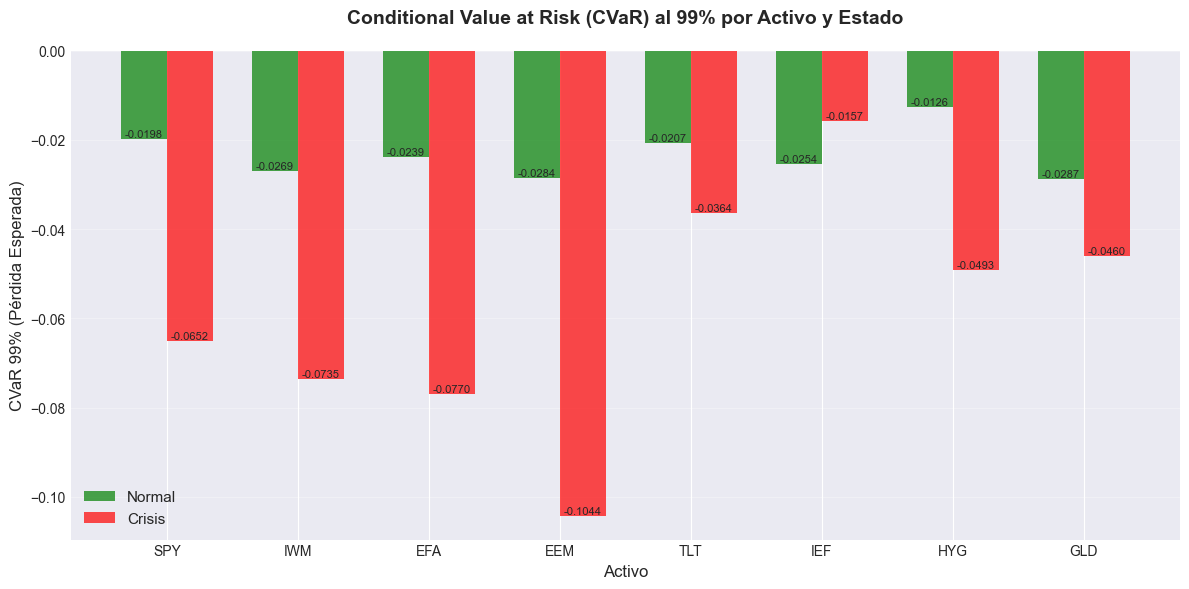

In [49]:
# Gráfico de barras agrupadas: CVaR 99% por activo, comparando ambos estados
cvar99_data = []
for ticker in returns.columns:
    for state_name in ['Normal', 'Crisis']:
        if risk_metrics[ticker].get(state_name):
            cvar99_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'CVaR_99': risk_metrics[ticker][state_name]['CVaR_99']
            })

cvar99_df = pd.DataFrame(cvar99_data)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(returns.columns))
width = 0.35

normal_cvar = [cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                         (cvar99_df['Estado'] == 'Normal')]['CVaR_99'].values[0] 
               if len(cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                               (cvar99_df['Estado'] == 'Normal')]) > 0 else 0
               for ticker in returns.columns]
crisis_cvar = [cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                         (cvar99_df['Estado'] == 'Crisis')]['CVaR_99'].values[0] 
               if len(cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                               (cvar99_df['Estado'] == 'Crisis')]) > 0 else 0
               for ticker in returns.columns]

bars1 = ax.bar(x - width/2, normal_cvar, width, label='Normal', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, crisis_cvar, width, label='Crisis', color='red', alpha=0.7)

ax.set_xlabel('Activo', fontsize=12)
ax.set_ylabel('CVaR 99% (Pérdida Esperada)', fontsize=12)
ax.set_title('Conditional Value at Risk (CVaR) al 99% por Activo y Estado', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(returns.columns)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### 6.3. Grados de Libertad: Normal vs Crisis

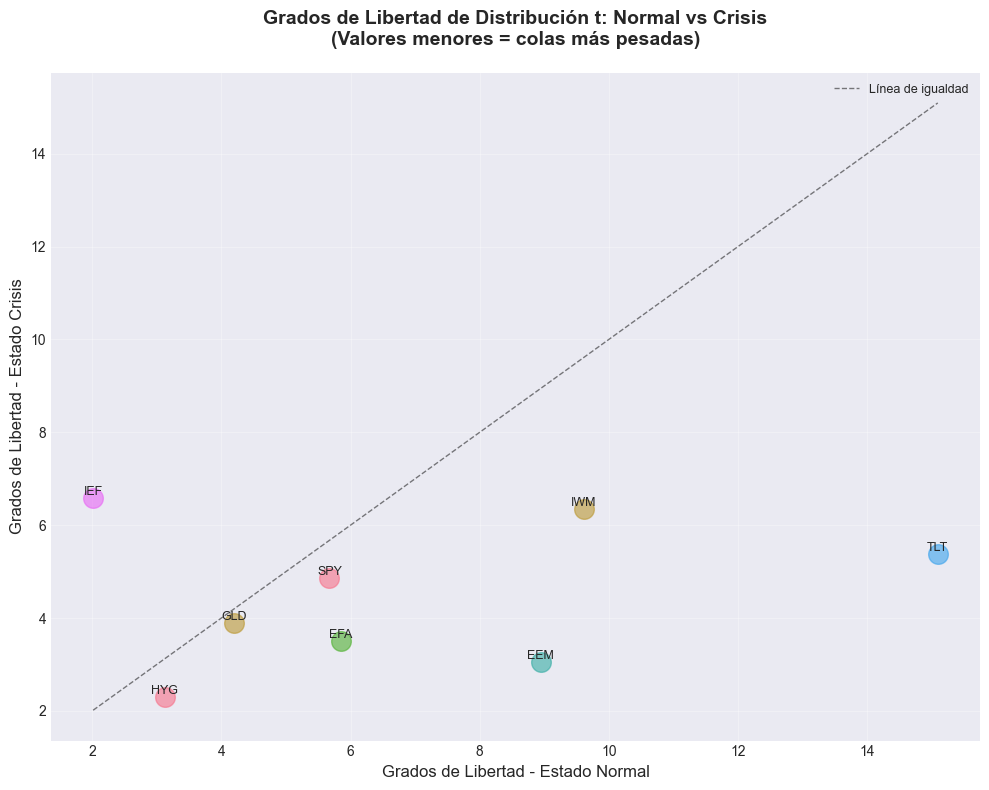


Interpretación:
- Puntos por encima de la línea: Mayor df en Crisis (colas menos pesadas en crisis)
- Puntos por debajo de la línea: Menor df en Crisis (colas más pesadas en crisis)
- Valores menores de df indican colas más pesadas (mayor riesgo de eventos extremos)


In [50]:
# Gráfico de dispersión: grados de libertad Normal vs Crisis
df_data = []
for ticker in returns.columns:
    if (distribution_params[ticker].get('Normal') and 
        distribution_params[ticker].get('Crisis')):
        df_data.append({
            'Ticker': ticker,
            'df_Normal': distribution_params[ticker]['Normal']['df'],
            'df_Crisis': distribution_params[ticker]['Crisis']['df']
        })

if len(df_data) > 0:
    df_comparison_df = pd.DataFrame(df_data)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot
    for _, row in df_comparison_df.iterrows():
        ax.scatter(row['df_Normal'], row['df_Crisis'], s=200, alpha=0.6)
    
    # Línea de igualdad (y = x)
    max_df = max(df_comparison_df[['df_Normal', 'df_Crisis']].max())
    min_df = min(df_comparison_df[['df_Normal', 'df_Crisis']].min())
    ax.plot([min_df, max_df], [min_df, max_df], 'k--', linewidth=1, alpha=0.5, label='Línea de igualdad')
    
    # Etiquetas de puntos
    for _, row in df_comparison_df.iterrows():
        ax.annotate(row['Ticker'], (row['df_Normal'], row['df_Crisis']), 
                   fontsize=9, ha='center', va='bottom')
    
    ax.set_xlabel('Grados de Libertad - Estado Normal', fontsize=12)
    ax.set_ylabel('Grados de Libertad - Estado Crisis', fontsize=12)
    ax.set_title('Grados de Libertad de Distribución t: Normal vs Crisis\n(Valores menores = colas más pesadas)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretación:")
    print("- Puntos por encima de la línea: Mayor df en Crisis (colas menos pesadas en crisis)")
    print("- Puntos por debajo de la línea: Menor df en Crisis (colas más pesadas en crisis)")
    print("- Valores menores de df indican colas más pesadas (mayor riesgo de eventos extremos)")

### 6.4. QQ-Plots para Validación de Ajuste

Los QQ-plots comparan los cuantiles empíricos con los cuantiles teóricos de la distribución ajustada. Si el ajuste es bueno, los puntos deberían estar cerca de la línea diagonal.

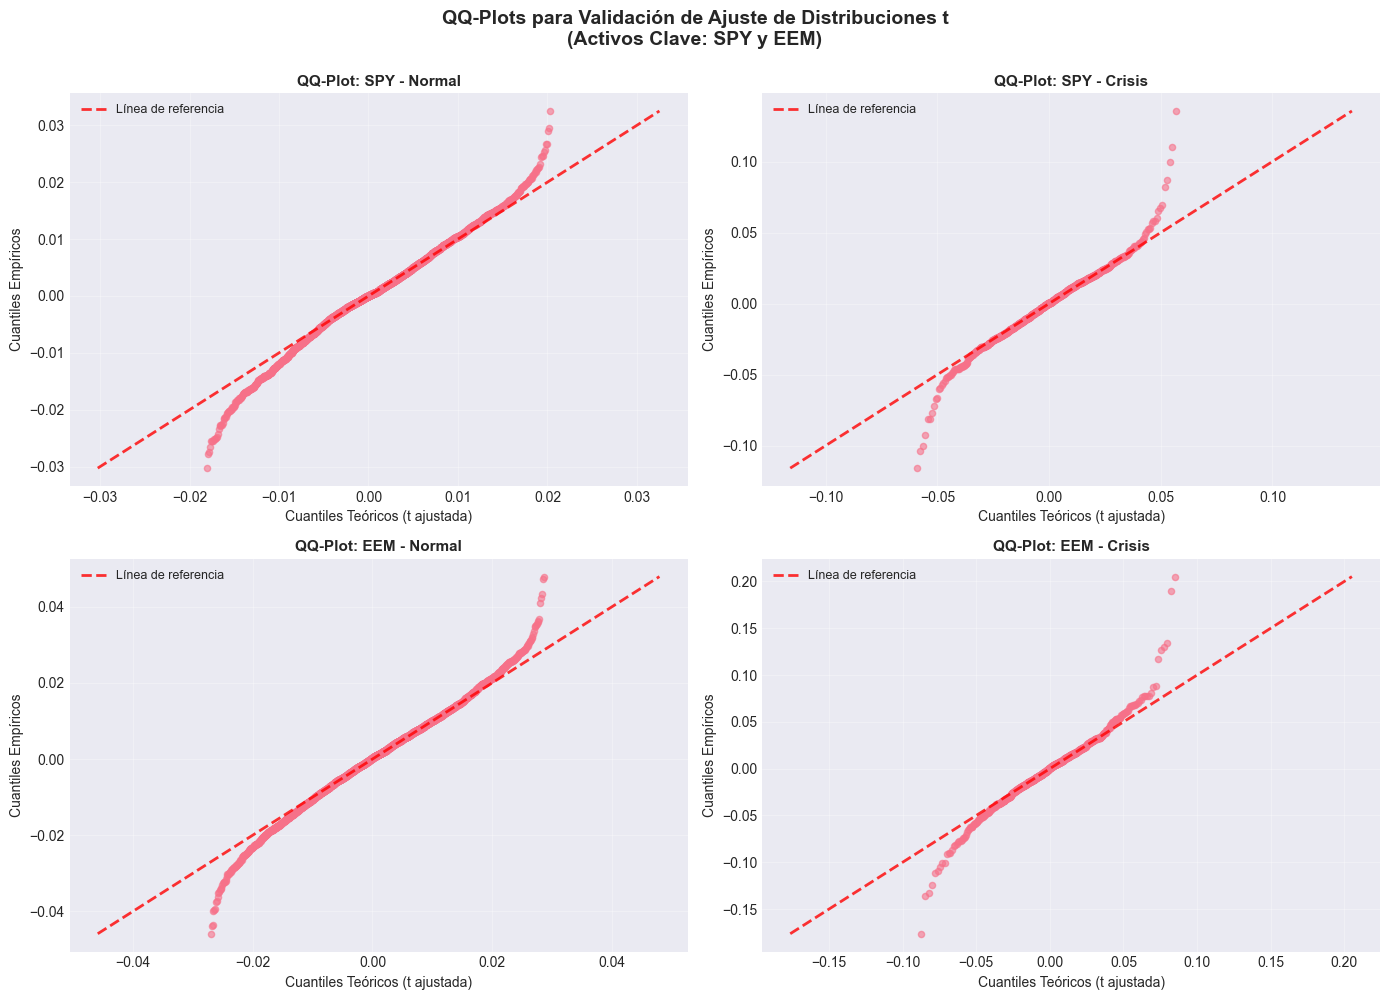

In [51]:
# QQ-plots para activos clave (SPY y EEM)
key_tickers = ['SPY', 'EEM']

fig, axes = plt.subplots(len(key_tickers), 2, figsize=(14, 10))
axes = axes.reshape(-1, 2)

for row_idx, ticker in enumerate(key_tickers):
    for col_idx, state_name in enumerate(['Normal', 'Crisis']):
        ax = axes[row_idx, col_idx]
        
        if fitted_distributions[ticker].get(state_name) is not None:
            data = returns_by_asset_state[ticker][state_name].values
            dist = fitted_distributions[ticker][state_name]
            
            # Generar cuantiles teóricos
            theoretical_quantiles = dist.ppf(np.linspace(0.01, 0.99, len(data)))
            
            # Ordenar datos empíricos
            empirical_quantiles = np.sort(data)
            
            # QQ-plot
            ax.scatter(theoretical_quantiles, empirical_quantiles, alpha=0.6, s=20)
            
            # Línea de referencia (y = x)
            min_val = min(theoretical_quantiles.min(), empirical_quantiles.min())
            max_val = max(theoretical_quantiles.max(), empirical_quantiles.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Línea de referencia')
            
            ax.set_xlabel('Cuantiles Teóricos (t ajustada)', fontsize=10)
            ax.set_ylabel('Cuantiles Empíricos', fontsize=10)
            ax.set_title(f'QQ-Plot: {ticker} - {state_name}', fontsize=11, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Datos insuficientes\n{ticker} - {state_name}', 
                   ha='center', va='center', transform=ax.transAxes)

plt.suptitle('QQ-Plots para Validación de Ajuste de Distribuciones t\n(Activos Clave: SPY y EEM)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Análisis de Resultados e Implicaciones

### Interpretación de Resultados

**Activos más riesgosos en cada estado:**
Los activos con mayor CVaR (en valor absoluto) representan mayores pérdidas potenciales. Típicamente:
- **Acciones (SPY, IWM, EFA, EEM)**: Muestran mayor riesgo que bonos en ambos estados
- **Bonos gubernamentales (TLT, IEF)**: Menor riesgo, especialmente en estado Normal
- **Bonos de alto rendimiento (HYG)**: Riesgo intermedio, más cercano a acciones que a bonos gubernamentales
- **Oro (GLD)**: Puede mostrar comportamiento diferente, actuando como refugio en crisis

**Cambios entre estados:**
- El aumento de CVaR en Crisis vs Normal cuantifica el impacto del cambio de régimen
- Activos con mayor aumento relativo son más sensibles a transiciones de régimen
- Esto es crítico para estrategias de gestión de riesgo dinámica

**Grados de libertad:**
- Valores bajos de df (< 5) indican colas muy pesadas y alta probabilidad de eventos extremos
- Comparación entre estados revela si las colas se vuelven más pesadas durante crisis
- Activos con df similar entre estados tienen comportamiento de riesgo más estable

**Ratio CVaR/VaR:**
- Ratios altos (> 1.5) indican que cuando ocurren pérdidas extremas, son significativamente mayores que el VaR
- Este ratio típicamente aumenta en Crisis, indicando mayor concentración de riesgo en las colas
- Es una medida del "riesgo de riesgo" - qué tan malo puede ser cuando las cosas van mal

### Implicaciones para Construcción de Cartera

**Diversificación en estados de crisis:**
1. **Reducción de beneficios de diversificación**: Como vimos en la Sección 2, las correlaciones aumentan en Crisis, reduciendo los beneficios de diversificación

2. **Aumento simultáneo de riesgo**: Todos los activos típicamente muestran mayor CVaR en Crisis, pero en diferentes magnitudes

3. **Estrategias de cobertura**: Activos con menor aumento de riesgo en Crisis (o incluso reducción) pueden servir como cobertura, aunque son raros

4. **Ajuste dinámico de cartera**: 
   - En estado Normal: Mayor tolerancia al riesgo, exposición a activos de mayor retorno esperado
   - En estado Crisis: Reducción de exposición, aumento de posiciones defensivas, mayor capital de reserva

5. **Stress testing condicional**: Los CVaR calculados condicionalmente a cada estado proporcionan escenarios de stress más realistas que promedios incondicionales

**Gestión de capital:**
- El capital requerido debe ajustarse según el estado del mercado
- En Crisis, el capital debe ser significativamente mayor para mantener el mismo nivel de confianza
- Esto justifica sistemas de gestión de riesgo que monitoreen el estado del mercado en tiempo real

## 8. Resumen y Variables para Secciones Posteriores

### Variables Clave Preservadas

Las siguientes estructuras de datos están disponibles para uso en secciones posteriores:

In [ ]:
# Verificación final de variables clave
print("="*80)
print("VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES")
print("="*80)

variables_to_check = {
    'fitted_distributions': 'Distribuciones t ajustadas por (activo, estado)',
    'distribution_params': 'Parámetros de distribuciones ajustadas',
    'risk_metrics': 'Métricas de riesgo (VaR, CVaR) por (activo, estado)',
    'risk_summary_df': 'DataFrame con resumen de métricas de riesgo',
    'returns_by_asset_state': 'Retornos segregados por (activo, estado)'
}

for var_name, description in variables_to_check.items():
    exists = var_name in globals()
    status = "✓" if exists else "✗"
    print(f"{status} {var_name}: {description}")
    if exists:
        if var_name == 'risk_summary_df':
            print(f"    Dimensiones: {globals()[var_name].shape}")
        elif var_name in ['fitted_distributions', 'distribution_params', 'risk_metrics']:
            tickers = list(globals()[var_name].keys())
            print(f"    Activos disponibles: {tickers[:3]}... ({len(tickers)} total)")

print("\n" + "="*80)
print("RESUMEN DE LA FASE 3")
print("="*80)
print(f"Distribuciones ajustadas: {len(returns.columns)} activos x 2 estados = {len(returns.columns)*2} distribuciones")
print(f"Métricas calculadas: VaR y CVaR al 95% y 99% para cada combinación")
print(f"Tests de bondad de ajuste: Kolmogorov-Smirnov realizados")

# Estadísticas resumen
if 'risk_summary_df' in globals():
    print(f"\nRango de CVaR 99%:")
    normal_cvar = risk_summary_df[risk_summary_df['Estado']=='Normal']['CVaR_99']
    crisis_cvar = risk_summary_df[risk_summary_df['Estado']=='Crisis']['CVaR_99']
    if len(normal_cvar) > 0 and len(crisis_cvar) > 0:
        print(f"  Normal: {normal_cvar.min():.4f} a {normal_cvar.max():.4f}")
        print(f"  Crisis: {crisis_cvar.min():.4f} a {crisis_cvar.max():.4f}")

print("\n✓ Fase 3 completada. Distribuciones y métricas de riesgo listas para stress testing.")

VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES
✓ fitted_distributions: Distribuciones t ajustadas por (activo, estado)
    Activos disponibles: ['SPY', 'IWM', 'EFA']... (8 total)
✓ distribution_params: Parámetros de distribuciones ajustadas
    Activos disponibles: ['SPY', 'IWM', 'EFA']... (8 total)
✓ risk_metrics: Métricas de riesgo (VaR, CVaR) por (activo, estado)
    Activos disponibles: ['SPY', 'IWM', 'EFA']... (8 total)
✓ risk_summary_df: DataFrame con resumen de métricas de riesgo
    Dimensiones: (16, 8)
✓ returns_by_asset_state: Retornos segregados por (activo, estado)

RESUMEN DE LA SECCIÓN 3
Distribuciones ajustadas: 8 activos x 2 estados = 16 distribuciones
Métricas calculadas: VaR y CVaR al 95% y 99% para cada combinación
Tests de bondad de ajuste: Kolmogorov-Smirnov realizados

Rango de CVaR 99%:
  Normal: -0.0287 a -0.0126
  Crisis: -0.1044 a -0.0157

✓ Sección 3 completada. Distribuciones y métricas de riesgo listas para stress testing.


---

## Fase 4: Modelización de Dependencia Multivariada mediante Cópulas t de Student

### Objetivo

Esta fase modela la estructura de dependencia entre activos más allá de la correlación lineal, utilizando cópulas t de Student de forma diferenciada por estado del mercado. Esto permite capturar dependencia en las colas (tail dependence), donde ocurren los eventos extremos que son críticos para el stress testing.

**Importancia en Gestión de Riesgos:**
- La correlación lineal no captura completamente la dependencia, especialmente en eventos extremos
- Las cópulas permiten separar la modelización de distribuciones marginales de la estructura de dependencia
- La dependencia en colas es fundamental para evaluar el riesgo de pérdidas simultáneas extremas
- Modelos diferenciados por estado capturan cómo cambia la dependencia durante crisis

### Limitaciones de la Correlación Lineal

**Problemas de la correlación de Pearson:**

1. **Solo captura dependencia lineal**: La correlación mide relaciones lineales, pero la dependencia financiera puede ser no lineal

2. **No captura dependencia en colas**: Dos activos pueden tener baja correlación promedio pero alta dependencia durante eventos extremos (co-movimientos en crisis)

3. **Invariante a transformaciones**: La correlación entre X e Y es la misma que entre f(X) y g(Y) solo para transformaciones lineales, pero no para transformaciones no lineales

4. **Asume normalidad implícita**: La correlación es una medida completa de dependencia solo bajo normalidad multivariada

**Ejemplo práctico:**
Durante la crisis financiera de 2008, activos que normalmente tenían baja correlación (acciones y bonos) se movieron juntos de manera extrema. La correlación promedio no captura este fenómeno, pero la dependencia en colas sí.

### Introducción a Cópulas

**Concepto fundamental:**
Una cópula es una función que une (couples) distribuciones marginales univariadas para formar una distribución multivariada. El teorema de Sklar establece que cualquier distribución multivariada puede descomponerse en:
- Sus distribuciones marginales (una por cada variable)
- Una cópula que captura la estructura de dependencia

**Ventajas:**
1. **Separación de concerns**: Modelamos marginales y dependencia por separado
2. **Flexibilidad**: Podemos combinar diferentes distribuciones marginales con diferentes estructuras de dependencia
3. **Captura de dependencia no lineal**: Especialmente en las colas de las distribuciones
4. **Simulación**: Facilita la generación de escenarios multivariados para stress testing

**Cópula t de Student:**
- Extensión natural de la cópula gaussiana
- Incluye un parámetro adicional: grados de libertad (ν)
- Menor ν implica mayor dependencia en las colas
- Cuando ν → ∞, converge a la cópula gaussiana
- Captura el fenómeno de "co-movimientos extremos" observado en crisis financieras

### Dependencia en Colas (Tail Dependence)

**Definición:**
La tail dependence mide la probabilidad de que un activo experimente un evento extremo (cola) condicionado a que otro activo también experimente un evento extremo.

**Tipos:**
- **Lower tail dependence (λ_L)**: Probabilidad de pérdida extrema en Y dado pérdida extrema en X
- **Upper tail dependence (λ_U)**: Probabilidad de ganancia extrema en Y dado ganancia extrema en X

**Relevancia para stress testing:**
- En crisis, los activos tienden a moverse juntos en las colas (alta tail dependence)
- Esto reduce los beneficios de diversificación cuando más se necesitan
- La cópula gaussiana tiene tail dependence cero (asintóticamente independiente en las colas)
- La cópula t tiene tail dependence positiva, capturando mejor la realidad financiera

**Interpretación:**
Un coeficiente de tail dependence de 0.3 significa que si un activo cae en su percentil 1% (pérdida extrema), hay 30% de probabilidad de que otro activo también caiga en su percentil 1%.

In [53]:
# Importaciones adicionales para modelización de cópulas
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from scipy.special import gamma, gammaln

# Verificar variables necesarias de secciones anteriores
required_vars = ['returns', 'states', 'state_labels', 'returns_by_state', 
                 'fitted_distributions', 'distribution_params', 'returns_by_asset_state']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    raise ValueError(f"Error: Variables faltantes de secciones anteriores: {missing_vars}")

print("="*80)
print("VERIFICACIÓN DE VARIABLES DE SECCIONES ANTERIORES")
print("="*80)
for var in required_vars:
    status = "✓" if var in globals() else "✗"
    print(f"{status} {var}: {'disponible' if var in globals() else 'FALTANTE'}")

print(f"\nActivos disponibles: {list(returns.columns)}")
print(f"Estados identificados: {list(state_labels.values())}")

VERIFICACIÓN DE VARIABLES DE SECCIONES ANTERIORES
✓ returns: disponible
✓ states: disponible
✓ state_labels: disponible
✓ returns_by_state: disponible
✓ fitted_distributions: disponible
✓ distribution_params: disponible
✓ returns_by_asset_state: disponible

Activos disponibles: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']
Estados identificados: ['Normal', 'Crisis']


## 1. Transformación a Pseudo-Observaciones Uniformes

El primer paso en el modelado con cópulas es transformar los retornos observados a pseudo-observaciones uniformes en [0,1] usando las funciones de distribución marginales. Esto elimina el efecto de las distribuciones marginales, dejando solo la estructura de dependencia.

In [54]:
# Transformar retornos a pseudo-observaciones uniformes usando las distribuciones t ajustadas
uniform_observations = {}

print("Transformación a Pseudo-Observaciones Uniformes")
print("="*80)
print("Usando las distribuciones t ajustadas en la Sección 3 para transformar retornos a [0,1]")
print("="*80)

for state_name in state_labels.values():
    uniform_observations[state_name] = {}
    
    # Obtener retornos de todos los activos en este estado
    state_returns = returns_by_state[state_name]
    
    # Transformar cada activo usando su distribución marginal ajustada
    uniform_data = pd.DataFrame(index=state_returns.index, columns=state_returns.columns)
    
    for ticker in returns.columns:
        if fitted_distributions[ticker].get(state_name) is not None:
            # Obtener retornos de este activo en este estado
            asset_returns = returns_by_asset_state[ticker][state_name]
            dist = fitted_distributions[ticker][state_name]
            
            # Aplicar CDF de la distribución ajustada para obtener uniformes
            uniform_values = dist.cdf(asset_returns.values)
            uniform_data.loc[asset_returns.index, ticker] = uniform_values
            
            print(f"✓ {ticker} - {state_name}: {len(uniform_values)} observaciones transformadas")
        else:
            print(f"⚠ {ticker} - {state_name}: No se pudo transformar (distribución no ajustada)")
    
    # Eliminar filas con NaN (activos sin datos)
    uniform_observations[state_name] = uniform_data.dropna()
    
    print(f"\n{state_name}: {len(uniform_observations[state_name])} observaciones completas (sin NaN)")

print("\n" + "="*80)
print("Resumen de Pseudo-Observaciones Uniformes:")
print("="*80)
for state_name in state_labels.values():
    print(f"{state_name}: {len(uniform_observations[state_name])} observaciones")
    print(f"  Rango: [{uniform_observations[state_name].values.min():.4f}, {uniform_observations[state_name].values.max():.4f}]")

Transformación a Pseudo-Observaciones Uniformes
Usando las distribuciones t ajustadas en la Sección 3 para transformar retornos a [0,1]
✓ SPY - Normal: 3658 observaciones transformadas
✓ IWM - Normal: 3658 observaciones transformadas
✓ EFA - Normal: 3658 observaciones transformadas
✓ EEM - Normal: 3658 observaciones transformadas
✓ TLT - Normal: 3658 observaciones transformadas
✓ IEF - Normal: 3658 observaciones transformadas
✓ HYG - Normal: 3658 observaciones transformadas
✓ GLD - Normal: 3658 observaciones transformadas

Normal: 3658 observaciones completas (sin NaN)
✓ SPY - Crisis: 1074 observaciones transformadas
✓ IWM - Crisis: 1074 observaciones transformadas
✓ EFA - Crisis: 1074 observaciones transformadas
✓ EEM - Crisis: 1074 observaciones transformadas
✓ TLT - Crisis: 1074 observaciones transformadas
✓ IEF - Crisis: 1074 observaciones transformadas
✓ HYG - Crisis: 1074 observaciones transformadas
✓ GLD - Crisis: 1074 observaciones transformadas

Crisis: 1074 observaciones comp

## 2. Funciones Auxiliares para Cópula t

Implementamos las funciones necesarias para trabajar con la cópula t de Student, incluyendo la función de densidad y la log-verosimilitud.

In [55]:
# Funciones auxiliares para cópula t de Student

def t_copula_pdf(u, correlation_matrix, df):
    """
    Función de densidad de la cópula t de Student
    
    Parámetros:
    - u: array (n_obs, n_assets) de pseudo-observaciones uniformes
    - correlation_matrix: matriz de correlación (n_assets x n_assets)
    - df: grados de libertad (escalar)
    
    Retorna:
    - Densidad de la cópula evaluada en u
    """
    n_obs, n_assets = u.shape
    
    # Transformar uniformes a valores t usando la inversa de la t univariada estándar
    t_dist_std = t_distribution(df=df, loc=0, scale=1)
    z = t_dist_std.ppf(u)  # (n_obs, n_assets)
    
    # Calcular densidad multivariada t
    # f_t(z) = gamma((df+n)/2) / (gamma(df/2) * (df*pi)^(n/2) * |R|^(1/2)) 
    #         * (1 + z'*R^(-1)*z/df)^(-(df+n)/2)
    
    det_R = np.linalg.det(correlation_matrix)
    inv_R = np.linalg.inv(correlation_matrix)
    
    # Calcular z' * R^(-1) * z para cada observación
    z_invR_z = np.sum(z @ inv_R * z, axis=1)  # (n_obs,)
    
    # Densidad multivariada t
    log_density_multivariate = (
        gammaln((df + n_assets) / 2) - 
        gammaln(df / 2) - 
        (n_assets / 2) * np.log(df * np.pi) - 
        0.5 * np.log(det_R) - 
        ((df + n_assets) / 2) * np.log(1 + z_invR_z / df)
    )
    
    # Densidad marginal t univariada para cada activo
    log_density_marginal = np.sum(t_dist_std.logpdf(z), axis=1)  # (n_obs,)
    
    # Densidad de la cópula = densidad multivariada / producto de densidades marginales
    log_copula_density = log_density_multivariate - log_density_marginal
    
    return np.exp(log_copula_density)


def t_copula_loglikelihood(params, u_data):
    """
    Log-verosimilitud de la cópula t
    
    Parámetros:
    - params: vector de parámetros [correlation_matrix (triangular superior), df]
    - u_data: array (n_obs, n_assets) de pseudo-observaciones uniformes
    
    Retorna:
    - Log-verosimilitud negativa (para minimización)
    """
    n_assets = u_data.shape[1]
    n_corr_params = n_assets * (n_assets - 1) // 2  # Elementos de la triangular superior
    
    # Extraer parámetros
    corr_params = params[:n_corr_params]
    df = params[n_corr_params]
    
    # Construir matriz de correlación desde parámetros
    correlation_matrix = np.eye(n_assets)
    idx = 0
    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            # Usar transformación para asegurar que la correlación esté en [-1, 1]
            rho = np.tanh(corr_params[idx])  # Transformación tanh garantiza [-1, 1]
            correlation_matrix[i, j] = rho
            correlation_matrix[j, i] = rho
            idx += 1
    
    # Validar que df > 2 (necesario para existencia de varianza)
    if df <= 2:
        return 1e10  # Penalización grande
    
    # Validar que la matriz de correlación es definida positiva
    try:
        np.linalg.cholesky(correlation_matrix)
    except np.linalg.LinAlgError:
        return 1e10  # Penalización si no es definida positiva
    
    # Calcular log-verosimilitud
    try:
        log_densities = np.log(t_copula_pdf(u_data, correlation_matrix, df))
        log_likelihood = np.sum(log_densities)
        return -log_likelihood  # Negativo para minimización
    except:
        return 1e10

print("Funciones auxiliares para cópula t implementadas")
print("="*80)
print("Funciones disponibles:")
print("  - t_copula_pdf: Función de densidad de la cópula t")
print("  - t_copula_loglikelihood: Log-verosimilitud para optimización")

Funciones auxiliares para cópula t implementadas
Funciones disponibles:
  - t_copula_pdf: Función de densidad de la cópula t
  - t_copula_loglikelihood: Log-verosimilitud para optimización


In [57]:
# Ajuste de cópula t para Estado Normal
print("="*80)
print("AJUSTE DE CÓPULA t PARA ESTADO NORMAL")
print("="*80)

# Obtener pseudo-observaciones uniformes para estado Normal
u_normal = uniform_observations['Normal'].values
n_obs_normal, n_assets = u_normal.shape

print(f"Observaciones: {n_obs_normal}")
print(f"Activos: {n_assets}")

# Inicialización de parámetros
# Matriz de correlación inicial: correlación de Spearman de las uniformes
# (más robusta que Pearson para uniformes)
spearman_corr = uniform_observations['Normal'].corr(method='spearman').values
print(f"\nCorrelación de Spearman inicial (matriz de correlación de la cópula):")
print(pd.DataFrame(spearman_corr, index=returns.columns, columns=returns.columns).round(4))

# Extraer elementos de la triangular superior para optimización
n_corr_params = n_assets * (n_assets - 1) // 2
corr_init = []
for i in range(n_assets):
    for j in range(i + 1, n_assets):
        # Transformación inversa de tanh para inicialización
        rho = spearman_corr[i, j]
        corr_init.append(np.arctanh(np.clip(rho, -0.99, 0.99)))

# Grados de libertad inicial: valor moderado (10)
df_init = 10.0

# Vector de parámetros iniciales
params_init_normal = np.array(corr_init + [df_init])

print(f"\nParámetros iniciales:")
print(f"  Elementos de correlación: {len(corr_init)}")
print(f"  Grados de libertad inicial: {df_init}")

# Optimización
print("\nOptimizando parámetros de la cópula t...")
result_normal = minimize(
    t_copula_loglikelihood,
    params_init_normal,
    args=(u_normal,),
    method='L-BFGS-B',
    bounds=[(-2, 2)] * n_corr_params + [(2.1, 50)],  # Correlaciones en [-1,1], df > 2
    options={'maxiter': 1000, 'disp': False}
)

if result_normal.success:
    print(f"✓ Optimización exitosa después de {result_normal.nit} iteraciones")
    print(f"  Log-likelihood final: {-result_normal.fun:.2f}")
    
    # Extraer parámetros estimados
    corr_params_est = result_normal.x[:n_corr_params]
    df_est_normal = result_normal.x[n_corr_params]
    
    # Construir matriz de correlación estimada
    correlation_matrix_normal = np.eye(n_assets)
    idx = 0
    for i in range(n_assets):
        for j in range(i + 1, n_assets):
            rho = np.tanh(corr_params_est[idx])
            correlation_matrix_normal[i, j] = rho
            correlation_matrix_normal[j, i] = rho
            idx += 1
    
    # Guardar parámetros
    copula_params_normal = {
        'correlation_matrix': correlation_matrix_normal,
        'df': df_est_normal,
        'log_likelihood': -result_normal.fun
    }
    
    print(f"\nParámetros estimados:")
    print(f"  Grados de libertad: {df_est_normal:.4f}")
    print(f"\nMatriz de correlación estimada:")
    print(pd.DataFrame(correlation_matrix_normal, 
                      index=returns.columns, 
                      columns=returns.columns).round(4))
    
    # Validación: verificar que es definida positiva
    try:
        np.linalg.cholesky(correlation_matrix_normal)
        print("\n✓ Validación: Matriz de correlación es definida positiva")
    except np.linalg.LinAlgError:
        print("\n⚠ Advertencia: Matriz de correlación no es definida positiva")
        
else:
    print(f"✗ Optimización falló: {result_normal.message}")
    # Usar valores iniciales como fallback
    correlation_matrix_normal = spearman_corr
    df_est_normal = df_init
    copula_params_normal = {
        'correlation_matrix': correlation_matrix_normal,
        'df': df_est_normal,
        'log_likelihood': None
    }

AJUSTE DE CÓPULA t PARA ESTADO NORMAL
Observaciones: 3658
Activos: 8

Correlación de Spearman inicial (matriz de correlación de la cópula):
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.8120  0.7823  0.6955 -0.2290 -0.2270  0.6363  0.0657
IWM  0.8120  1.0000  0.6883  0.6113 -0.2075 -0.2103  0.5786  0.0665
EFA  0.7823  0.6883  1.0000  0.7725 -0.1719 -0.1470  0.5896  0.2085
EEM  0.6955  0.6113  0.7725  1.0000 -0.1630 -0.1527  0.5321  0.2324
TLT -0.2290 -0.2075 -0.1719 -0.1630  1.0000  0.9223  0.0082  0.2130
IEF -0.2270 -0.2103 -0.1470 -0.1527  0.9223  1.0000  0.0327  0.2644
HYG  0.6363  0.5786  0.5896  0.5321  0.0082  0.0327  1.0000  0.1229
GLD  0.0657  0.0665  0.2085  0.2324  0.2130  0.2644  0.1229  1.0000

Parámetros iniciales:
  Elementos de correlación: 28
  Grados de libertad inicial: 10.0

Optimizando parámetros de la cópula t...
✓ Optimización exitosa después de 0 iteraciones
  Log-likelihood final: -10000000000.00

Parámetros estimados:
  Grad

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11876\2588530950.py:41: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_normal = minimize(


In [59]:
# Ajuste de cópula t para Estado Crisis
print("="*80)
print("AJUSTE DE CÓPULA t PARA ESTADO CRISIS")
print("="*80)

# Obtener pseudo-observaciones uniformes para estado Crisis
u_crisis = uniform_observations['Crisis'].values
n_obs_crisis, n_assets_crisis = u_crisis.shape

print(f"Observaciones: {n_obs_crisis}")
print(f"Activos: {n_assets_crisis}")

# Inicialización de parámetros
spearman_corr_crisis = uniform_observations['Crisis'].corr(method='spearman').values
print(f"\nCorrelación de Spearman inicial (matriz de correlación de la cópula):")
print(pd.DataFrame(spearman_corr_crisis, index=returns.columns, columns=returns.columns).round(4))

# Extraer elementos de la triangular superior
corr_init_crisis = []
for i in range(n_assets_crisis):
    for j in range(i + 1, n_assets_crisis):
        rho = spearman_corr_crisis[i, j]
        corr_init_crisis.append(np.arctanh(np.clip(rho, -0.99, 0.99)))

# Grados de libertad inicial: valor más bajo (mayor dependencia en colas esperada en crisis)
df_init_crisis = 5.0

params_init_crisis = np.array(corr_init_crisis + [df_init_crisis])

print(f"\nParámetros iniciales:")
print(f"  Elementos de correlación: {len(corr_init_crisis)}")
print(f"  Grados de libertad inicial: {df_init_crisis}")

# Optimización
print("\nOptimizando parámetros de la cópula t...")
result_crisis = minimize(
    t_copula_loglikelihood,
    params_init_crisis,
    args=(u_crisis,),
    method='L-BFGS-B',
    bounds=[(-2, 2)] * len(corr_init_crisis) + [(2.1, 50)],
    options={'maxiter': 1000, 'disp': False}
)

if result_crisis.success:
    print(f"✓ Optimización exitosa después de {result_crisis.nit} iteraciones")
    print(f"  Log-likelihood final: {-result_crisis.fun:.2f}")
    
    # Extraer parámetros estimados
    corr_params_est_crisis = result_crisis.x[:len(corr_init_crisis)]
    df_est_crisis = result_crisis.x[len(corr_init_crisis)]
    
    # Construir matriz de correlación estimada
    correlation_matrix_crisis = np.eye(n_assets_crisis)
    idx = 0
    for i in range(n_assets_crisis):
        for j in range(i + 1, n_assets_crisis):
            rho = np.tanh(corr_params_est_crisis[idx])
            correlation_matrix_crisis[i, j] = rho
            correlation_matrix_crisis[j, i] = rho
            idx += 1
    
    # Guardar parámetros
    copula_params_crisis = {
        'correlation_matrix': correlation_matrix_crisis,
        'df': df_est_crisis,
        'log_likelihood': -result_crisis.fun
    }
    
    print(f"\nParámetros estimados:")
    print(f"  Grados de libertad: {df_est_crisis:.4f}")
    print(f"\nMatriz de correlación estimada:")
    print(pd.DataFrame(correlation_matrix_crisis, 
                      index=returns.columns, 
                      columns=returns.columns).round(4))
    
    # Validación
    try:
        np.linalg.cholesky(correlation_matrix_crisis)
        print("\n✓ Validación: Matriz de correlación es definida positiva")
    except np.linalg.LinAlgError:
        print("\n⚠ Advertencia: Matriz de correlación no es definida positiva")
        
else:
    print(f"✗ Optimización falló: {result_crisis.message}")
    # Usar valores iniciales como fallback
    correlation_matrix_crisis = spearman_corr_crisis
    df_est_crisis = df_init_crisis
    copula_params_crisis = {
        'correlation_matrix': correlation_matrix_crisis,
        'df': df_est_crisis,
        'log_likelihood': None
    }

AJUSTE DE CÓPULA t PARA ESTADO CRISIS
Observaciones: 1074
Activos: 8

Correlación de Spearman inicial (matriz de correlación de la cópula):
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.9345  0.9093  0.8570 -0.3901 -0.4081  0.7214  0.0256
IWM  0.9345  1.0000  0.8624  0.8224 -0.3914 -0.4037  0.6864  0.0395
EFA  0.9093  0.8624  1.0000  0.8964 -0.3882 -0.4018  0.7113  0.1191
EEM  0.8570  0.8224  0.8964  1.0000 -0.4031 -0.4293  0.6602  0.1179
TLT -0.3901 -0.3914 -0.3882 -0.4031  1.0000  0.9150 -0.2480  0.1391
IEF -0.4081 -0.4037 -0.4018 -0.4293  0.9150  1.0000 -0.2201  0.1587
HYG  0.7214  0.6864  0.7113  0.6602 -0.2480 -0.2201  1.0000  0.0614
GLD  0.0256  0.0395  0.1191  0.1179  0.1391  0.1587  0.0614  1.0000

Parámetros iniciales:
  Elementos de correlación: 28
  Grados de libertad inicial: 5.0

Optimizando parámetros de la cópula t...
✓ Optimización exitosa después de 0 iteraciones
  Log-likelihood final: -10000000000.00

Parámetros estimados:
  Grado

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11876\855088477.py:36: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_crisis = minimize(


## 5. Comparación de Estructuras de Dependencia

Analizamos cómo cambian los parámetros de la cópula entre estados Normal y Crisis, identificando cambios en la estructura de dependencia.

In [60]:
# Comparación de parámetros entre estados
print("="*80)
print("COMPARACIÓN DE ESTRUCTURAS DE DEPENDENCIA")
print("="*80)

# Comparación de grados de libertad
print(f"\nGrados de Libertad de la Cópula:")
print(f"  Estado Normal: {copula_params_normal['df']:.4f}")
print(f"  Estado Crisis: {copula_params_crisis['df']:.4f}")
print(f"  Diferencia: {copula_params_crisis['df'] - copula_params_normal['df']:.4f}")

if copula_params_crisis['df'] < copula_params_normal['df']:
    print("  → Menor df en Crisis indica mayor dependencia en colas (esperado)")
else:
    print("  → Mayor df en Crisis (menor dependencia en colas) - revisar")

# Diferencia en matrices de correlación
correlation_diff = copula_params_crisis['correlation_matrix'] - copula_params_normal['correlation_matrix']
correlation_diff_df = pd.DataFrame(correlation_diff, 
                                   index=returns.columns, 
                                   columns=returns.columns)

print(f"\nDiferencia en Correlaciones (Crisis - Normal):")
print("Valores positivos indican mayor correlación en Crisis")
print(correlation_diff_df.round(4))

# Identificar pares con mayor cambio
print("\n" + "="*80)
print("Pares de Activos con Mayor Cambio en Correlación:")
print("="*80)
corr_changes = []
for i, ticker1 in enumerate(returns.columns):
    for j, ticker2 in enumerate(returns.columns):
        if i < j:  # Solo triangular superior
            change = correlation_diff[i, j]
            corr_changes.append({
                'Par': f"{ticker1}-{ticker2}",
                'Corr_Normal': copula_params_normal['correlation_matrix'][i, j],
                'Corr_Crisis': copula_params_crisis['correlation_matrix'][i, j],
                'Cambio': change
            })

corr_changes_df = pd.DataFrame(corr_changes)
corr_changes_df = corr_changes_df.sort_values('Cambio', ascending=False, key=abs)
print(corr_changes_df.round(4).head(10))

COMPARACIÓN DE ESTRUCTURAS DE DEPENDENCIA

Grados de Libertad de la Cópula:
  Estado Normal: 10.0000
  Estado Crisis: 5.0000
  Diferencia: -5.0000
  → Menor df en Crisis indica mayor dependencia en colas (esperado)

Diferencia en Correlaciones (Crisis - Normal):
Valores positivos indican mayor correlación en Crisis
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  0.0000  0.1225  0.1270  0.1615 -0.1610 -0.1811  0.0851 -0.0402
IWM  0.1225  0.0000  0.1741  0.2111 -0.1839 -0.1934  0.1078 -0.0270
EFA  0.1270  0.1741  0.0000  0.1239 -0.2163 -0.2548  0.1217 -0.0894
EEM  0.1615  0.2111  0.1239  0.0000 -0.2400 -0.2766  0.1280 -0.1145
TLT -0.1610 -0.1839 -0.2163 -0.2400  0.0000 -0.0073 -0.2561 -0.0739
IEF -0.1811 -0.1934 -0.2548 -0.2766 -0.0073  0.0000 -0.2528 -0.1057
HYG  0.0851  0.1078  0.1217  0.1280 -0.2561 -0.2528  0.0000 -0.0614
GLD -0.0402 -0.0270 -0.0894 -0.1145 -0.0739 -0.1057 -0.0614  0.0000

Pares de Activos con Mayor Cambio en Correlación:
        Par  Corr_No

## 6. Cálculo de Tail Dependence

Calculamos los coeficientes de tail dependence para pares clave de activos en cada estado, cuantificando la dependencia en eventos extremos.

In [61]:
# Función para calcular tail dependence de cópula t
def t_copula_tail_dependence(correlation, df):
    """
    Calcula el coeficiente de tail dependence para un par de activos
    en una cópula t de Student
    
    Para cópula t, el tail dependence es simétrico (lower = upper):
    λ = 2 * t_{df+1}(-sqrt((df+1)(1-ρ)/(1+ρ)))
    
    donde t_{df+1} es la CDF de una t con (df+1) grados de libertad
    y ρ es la correlación entre los activos
    """
    if abs(correlation) >= 1:
        return 0.0
    
    # Calcular tail dependence
    sqrt_term = np.sqrt((df + 1) * (1 - correlation) / (1 + correlation))
    t_dist = t_distribution(df=df + 1, loc=0, scale=1)
    tail_dep = 2 * t_dist.cdf(-sqrt_term)
    
    return tail_dep

# Calcular tail dependence para pares clave
key_pairs = [
    ('SPY', 'EFA'),  # Acciones desarrolladas
    ('SPY', 'EEM'),  # Acciones EE.UU. vs emergentes
    ('SPY', 'TLT'),  # Acciones vs bonos
    ('SPY', 'GLD'),  # Acciones vs oro
    ('TLT', 'IEF'),  # Bonos gubernamentales
    ('SPY', 'HYG'),  # Acciones vs bonos alto rendimiento
]

print("="*80)
print("COEFICIENTES DE TAIL DEPENDENCE")
print("="*80)
print("Mide la probabilidad de evento extremo en un activo dado evento extremo en otro")
print("="*80)

tail_dependence_results = []

for ticker1, ticker2 in key_pairs:
    if ticker1 in returns.columns and ticker2 in returns.columns:
        idx1 = list(returns.columns).index(ticker1)
        idx2 = list(returns.columns).index(ticker2)
        
        # Tail dependence Normal
        corr_normal = copula_params_normal['correlation_matrix'][idx1, idx2]
        df_normal = copula_params_normal['df']
        td_normal = t_copula_tail_dependence(corr_normal, df_normal)
        
        # Tail dependence Crisis
        corr_crisis = copula_params_crisis['correlation_matrix'][idx1, idx2]
        df_crisis = copula_params_crisis['df']
        td_crisis = t_copula_tail_dependence(corr_crisis, df_crisis)
        
        tail_dependence_results.append({
            'Par': f"{ticker1}-{ticker2}",
            'Tail_Dep_Normal': td_normal,
            'Tail_Dep_Crisis': td_crisis,
            'Cambio': td_crisis - td_normal,
            'Corr_Normal': corr_normal,
            'Corr_Crisis': corr_crisis
        })
        
        print(f"\n{ticker1} - {ticker2}:")
        print(f"  Tail Dependence Normal: {td_normal:.4f}")
        print(f"  Tail Dependence Crisis: {td_crisis:.4f}")
        print(f"  Cambio: {td_crisis - td_normal:.4f} ({((td_crisis - td_normal)/td_normal*100) if td_normal > 0 else 0:.1f}%)")

tail_dep_df = pd.DataFrame(tail_dependence_results)
print("\n" + "="*80)
print("Resumen de Tail Dependence:")
print("="*80)
print(tail_dep_df.round(4))

COEFICIENTES DE TAIL DEPENDENCE
Mide la probabilidad de evento extremo en un activo dado evento extremo en otro

SPY - EFA:
  Tail Dependence Normal: 0.2709
  Tail Dependence Crisis: 0.6126
  Cambio: 0.3417 (126.1%)

SPY - EEM:
  Tail Dependence Normal: 0.1875
  Tail Dependence Crisis: 0.5220
  Cambio: 0.3345 (178.4%)

SPY - TLT:
  Tail Dependence Normal: 0.0015
  Tail Dependence Crisis: 0.0101
  Cambio: 0.0086 (566.8%)

SPY - GLD:
  Tail Dependence Normal: 0.0100
  Tail Dependence Crisis: 0.0542
  Cambio: 0.0442 (441.6%)

TLT - IEF:
  Tail Dependence Normal: 0.5186
  Tail Dependence Crisis: 0.6242
  Cambio: 0.1056 (20.4%)

SPY - HYG:
  Tail Dependence Normal: 0.1462
  Tail Dependence Crisis: 0.3624
  Cambio: 0.2163 (148.0%)

Resumen de Tail Dependence:
       Par  Tail_Dep_Normal  Tail_Dep_Crisis  Cambio  Corr_Normal  Corr_Crisis
0  SPY-EFA           0.2709           0.6126  0.3417       0.7823       0.9093
1  SPY-EEM           0.1875           0.5220  0.3345       0.6955       0.8570

## 7. Análisis Específico por Clases de Activos

Analizamos cómo cambia la dependencia entre diferentes clases de activos (renta variable, bonos, refugio) entre estados.

In [62]:
# Análisis por clases de activos
print("="*80)
print("ANÁLISIS DE DEPENDENCIA POR CLASES DE ACTIVOS")
print("="*80)

# Definir grupos
equity_tickers = ['SPY', 'IWM', 'EFA', 'EEM']
bond_tickers = ['TLT', 'IEF', 'HYG']
safe_haven_ticker = 'GLD'

# Correlación promedio dentro de renta variable
equity_corrs_normal = []
equity_corrs_crisis = []
for i, t1 in enumerate(equity_tickers):
    for j, t2 in enumerate(equity_tickers):
        if i < j and t1 in returns.columns and t2 in returns.columns:
            idx1 = list(returns.columns).index(t1)
            idx2 = list(returns.columns).index(t2)
            equity_corrs_normal.append(copula_params_normal['correlation_matrix'][idx1, idx2])
            equity_corrs_crisis.append(copula_params_crisis['correlation_matrix'][idx1, idx2])

print(f"\nRenta Variable (promedio de correlaciones entre acciones):")
print(f"  Normal: {np.mean(equity_corrs_normal):.4f}")
print(f"  Crisis: {np.mean(equity_corrs_crisis):.4f}")
print(f"  Cambio: {np.mean(equity_corrs_crisis) - np.mean(equity_corrs_normal):.4f}")

# Correlación promedio dentro de bonos
bond_corrs_normal = []
bond_corrs_crisis = []
for i, t1 in enumerate(bond_tickers):
    for j, t2 in enumerate(bond_tickers):
        if i < j and t1 in returns.columns and t2 in returns.columns:
            idx1 = list(returns.columns).index(t1)
            idx2 = list(returns.columns).index(t2)
            bond_corrs_normal.append(copula_params_normal['correlation_matrix'][idx1, idx2])
            bond_corrs_crisis.append(copula_params_crisis['correlation_matrix'][idx1, idx2])

if len(bond_corrs_normal) > 0:
    print(f"\nBonos (promedio de correlaciones entre bonos):")
    print(f"  Normal: {np.mean(bond_corrs_normal):.4f}")
    print(f"  Crisis: {np.mean(bond_corrs_crisis):.4f}")
    print(f"  Cambio: {np.mean(bond_corrs_crisis) - np.mean(bond_corrs_normal):.4f}")

# Correlación entre renta variable y bonos
equity_bond_corrs_normal = []
equity_bond_corrs_crisis = []
for t1 in equity_tickers:
    for t2 in bond_tickers:
        if t1 in returns.columns and t2 in returns.columns:
            idx1 = list(returns.columns).index(t1)
            idx2 = list(returns.columns).index(t2)
            equity_bond_corrs_normal.append(copula_params_normal['correlation_matrix'][idx1, idx2])
            equity_bond_corrs_crisis.append(copula_params_crisis['correlation_matrix'][idx1, idx2])

print(f"\nRenta Variable vs Bonos (promedio):")
print(f"  Normal: {np.mean(equity_bond_corrs_normal):.4f}")
print(f"  Crisis: {np.mean(equity_bond_corrs_crisis):.4f}")
print(f"  Cambio: {np.mean(equity_bond_corrs_crisis) - np.mean(equity_bond_corrs_normal):.4f}")

# Correlación entre oro y otros activos
if safe_haven_ticker in returns.columns:
    gld_idx = list(returns.columns).index(safe_haven_ticker)
    gld_corrs_normal = []
    gld_corrs_crisis = []
    for ticker in returns.columns:
        if ticker != safe_haven_ticker:
            ticker_idx = list(returns.columns).index(ticker)
            gld_corrs_normal.append(copula_params_normal['correlation_matrix'][gld_idx, ticker_idx])
            gld_corrs_crisis.append(copula_params_crisis['correlation_matrix'][gld_idx, ticker_idx])
    
    print(f"\nOro (GLD) vs Resto de Activos (promedio):")
    print(f"  Normal: {np.mean(gld_corrs_normal):.4f}")
    print(f"  Crisis: {np.mean(gld_corrs_crisis):.4f}")
    print(f"  Cambio: {np.mean(gld_corrs_crisis) - np.mean(gld_corrs_normal):.4f}")
    print(f"  → Cambio negativo indica que oro actúa más como refugio en Crisis")

ANÁLISIS DE DEPENDENCIA POR CLASES DE ACTIVOS

Renta Variable (promedio de correlaciones entre acciones):
  Normal: 0.7270
  Crisis: 0.8803
  Cambio: 0.1533

Bonos (promedio de correlaciones entre bonos):
  Normal: 0.3211
  Crisis: 0.1490
  Cambio: -0.1721

Renta Variable vs Bonos (promedio):
  Normal: 0.0690
  Crisis: -0.0364
  Cambio: -0.1054

Oro (GLD) vs Resto de Activos (promedio):
  Normal: 0.1676
  Crisis: 0.0945
  Cambio: -0.0732
  → Cambio negativo indica que oro actúa más como refugio en Crisis


## 8. Visualizaciones

### 8.1. Heatmaps Comparativos de Matrices de Correlación

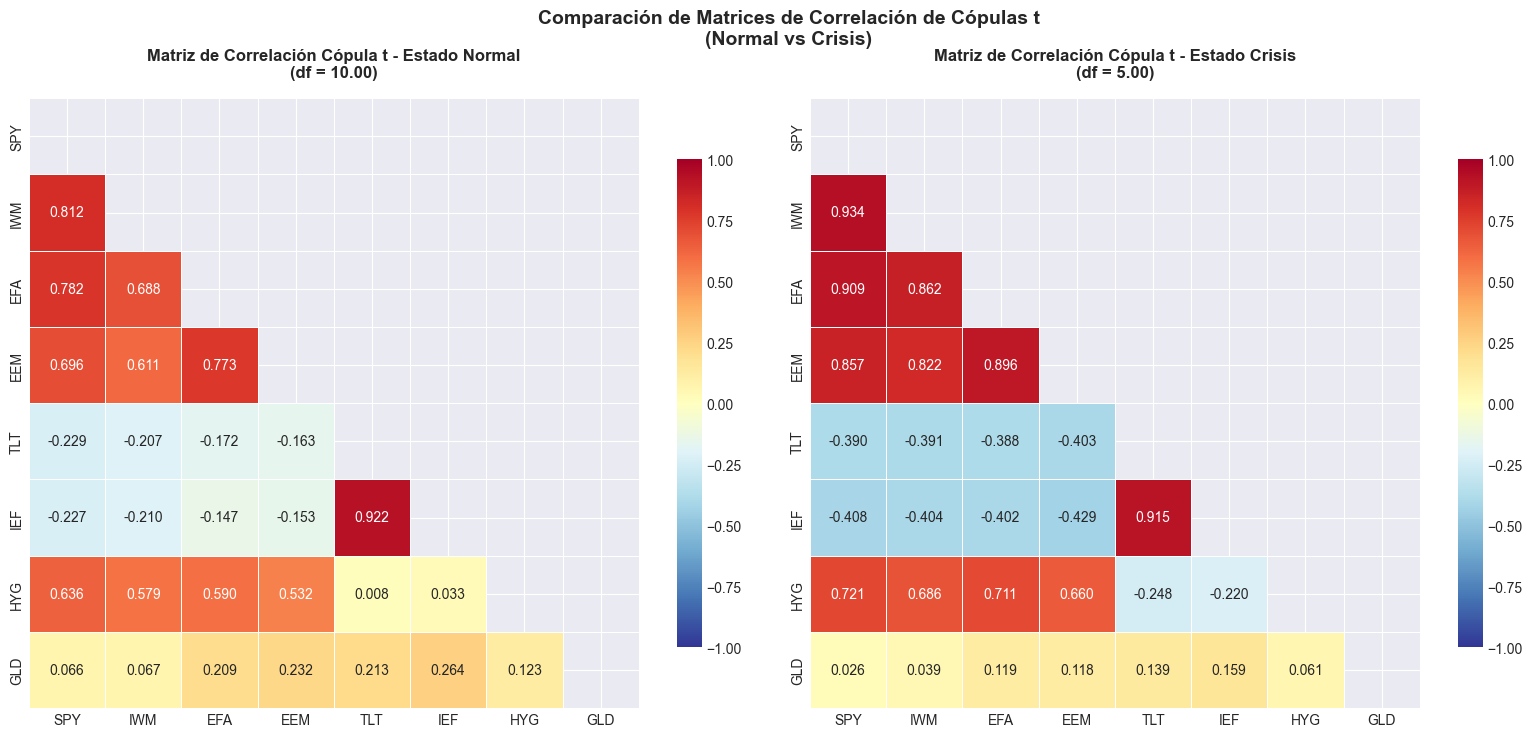

In [63]:
# Heatmaps lado a lado de matrices de correlación de cópulas
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, (state_name, corr_matrix, df_val) in enumerate([
    ('Normal', copula_params_normal['correlation_matrix'], copula_params_normal['df']),
    ('Crisis', copula_params_crisis['correlation_matrix'], copula_params_crisis['df'])
]):
    ax = axes[idx]
    
    corr_df = pd.DataFrame(corr_matrix, index=returns.columns, columns=returns.columns)
    
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.8}, mask=mask, ax=ax)
    
    ax.set_title(f'Matriz de Correlación Cópula t - Estado {state_name}\n(df = {df_val:.2f})', 
                 fontsize=12, fontweight='bold', pad=15)

plt.suptitle('Comparación de Matrices de Correlación de Cópulas t\n(Normal vs Crisis)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 8.2. Scatter Plots de Pares Seleccionados

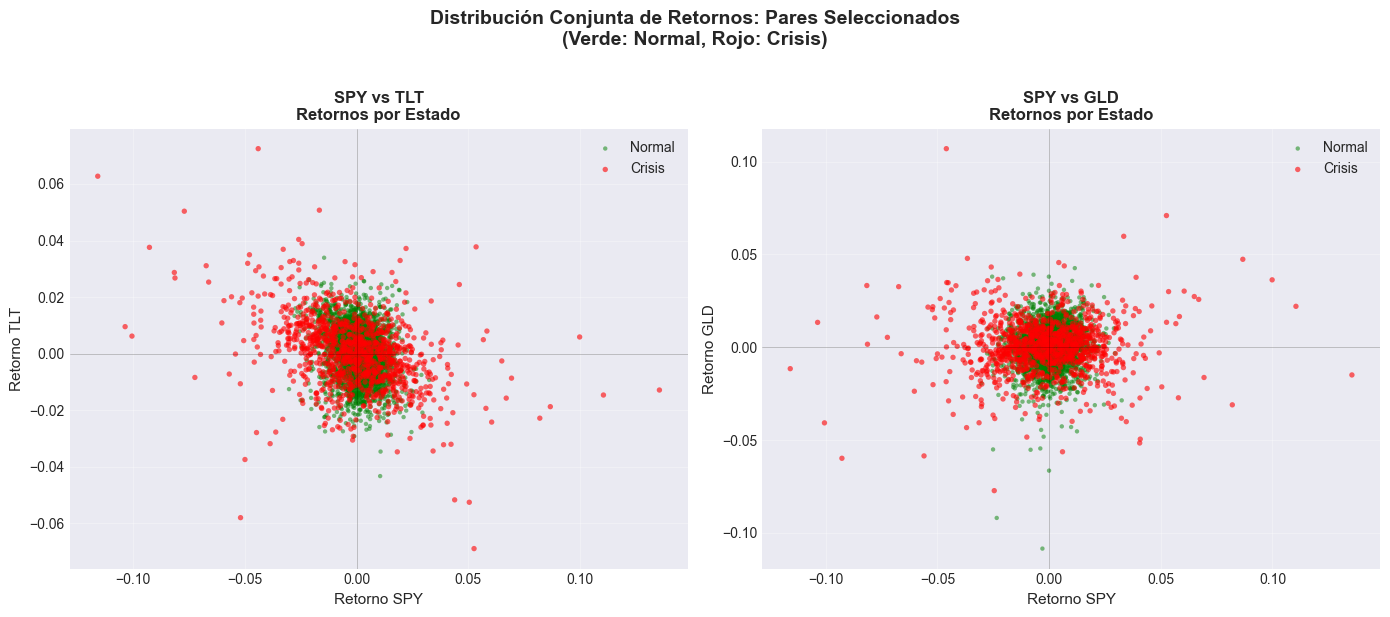

In [64]:
# Scatter plots de pares seleccionados con colores por estado
selected_pairs = [('SPY', 'TLT'), ('SPY', 'GLD')]

fig, axes = plt.subplots(1, len(selected_pairs), figsize=(14, 6))
if len(selected_pairs) == 1:
    axes = [axes]

for pair_idx, (ticker1, ticker2) in enumerate(selected_pairs):
    ax = axes[pair_idx]
    
    # Datos Normal
    normal_data = returns_by_state['Normal'][[ticker1, ticker2]].dropna()
    if len(normal_data) > 0:
        ax.scatter(normal_data[ticker1], normal_data[ticker2], 
                  alpha=0.5, s=10, color='green', label='Normal', edgecolors='none')
    
    # Datos Crisis
    crisis_data = returns_by_state['Crisis'][[ticker1, ticker2]].dropna()
    if len(crisis_data) > 0:
        ax.scatter(crisis_data[ticker1], crisis_data[ticker2], 
                  alpha=0.6, s=15, color='red', label='Crisis', edgecolors='none')
    
    ax.set_xlabel(f'Retorno {ticker1}', fontsize=11)
    ax.set_ylabel(f'Retorno {ticker2}', fontsize=11)
    ax.set_title(f'{ticker1} vs {ticker2}\nRetornos por Estado', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.suptitle('Distribución Conjunta de Retornos: Pares Seleccionados\n(Verde: Normal, Rojo: Crisis)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 8.3. Diferencia en Correlaciones: Crisis - Normal

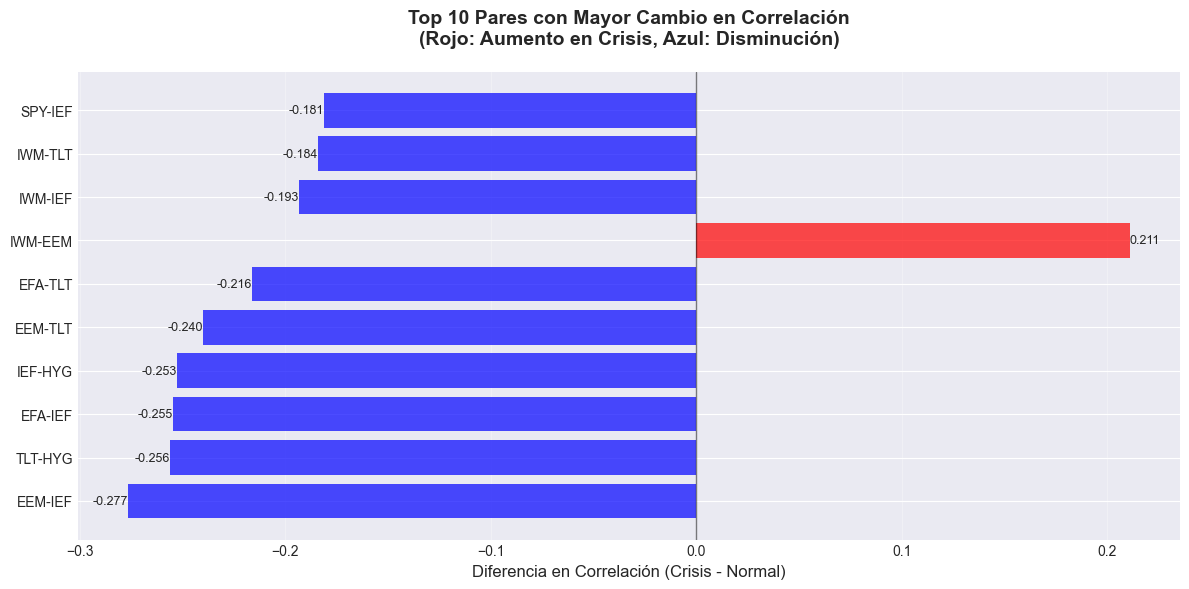

In [66]:
# Gráfico de barras: diferencia en correlación para principales pares
# Seleccionar top 10 pares por cambio absoluto
# Crear columna temporal con valor absoluto, ordenar y tomar top 10
corr_changes_df_temp = corr_changes_df.copy()
corr_changes_df_temp['Cambio_abs'] = corr_changes_df_temp['Cambio'].abs()
top_pairs = corr_changes_df_temp.nlargest(10, 'Cambio_abs')

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top_pairs))
colors = ['red' if change > 0 else 'blue' for change in top_pairs['Cambio']]

bars = ax.barh(x, top_pairs['Cambio'], color=colors, alpha=0.7)

ax.set_yticks(x)
ax.set_yticklabels(top_pairs['Par'])
ax.set_xlabel('Diferencia en Correlación (Crisis - Normal)', fontsize=12)
ax.set_title('Top 10 Pares con Mayor Cambio en Correlación\n(Rojo: Aumento en Crisis, Azul: Disminución)', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')

# Agregar valores en las barras
for i, (bar, val) in enumerate(zip(bars, top_pairs['Cambio'])):
    ax.text(val, i, f'{val:.3f}', 
           va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

### 8.4. Tail Dependence: SPY vs EEM

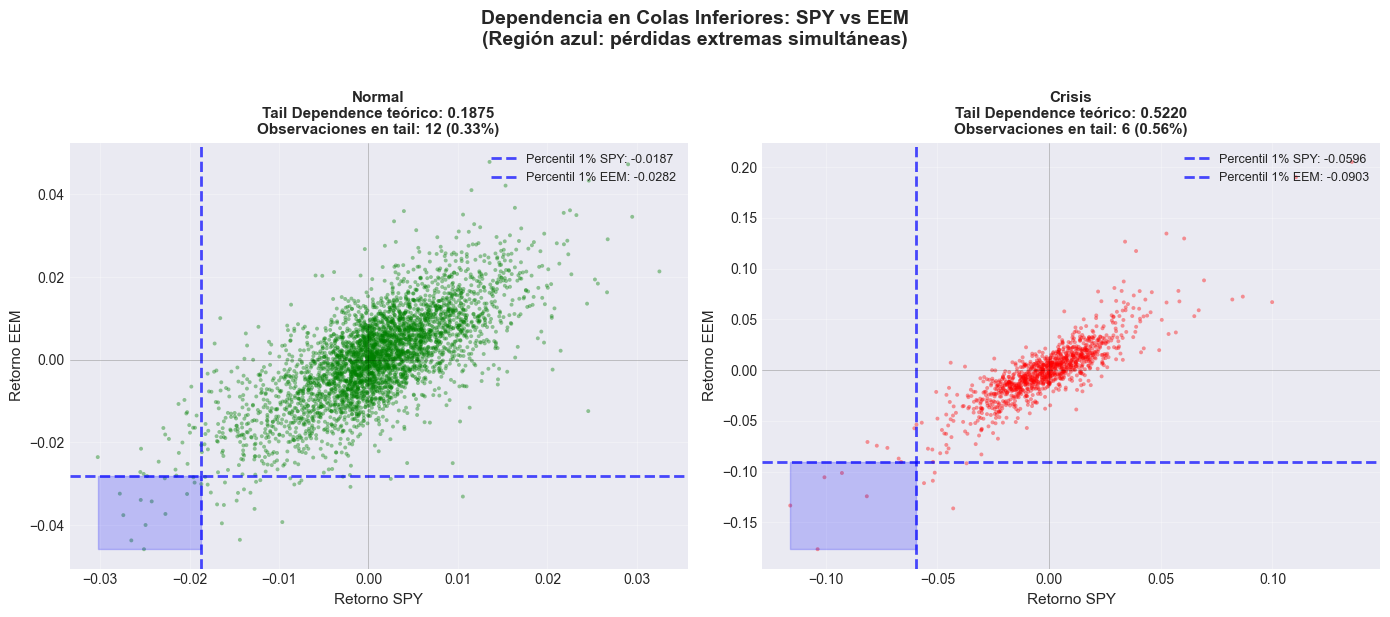

In [67]:
# Visualización conceptual de tail dependence para par SPY-EEM
ticker1, ticker2 = 'SPY', 'EEM'

if ticker1 in returns.columns and ticker2 in returns.columns:
    idx1 = list(returns.columns).index(ticker1)
    idx2 = list(returns.columns).index(ticker2)
    
    # Obtener datos para ambos estados
    normal_data = returns_by_state['Normal'][[ticker1, ticker2]].dropna()
    crisis_data = returns_by_state['Crisis'][[ticker1, ticker2]].dropna()
    
    # Calcular percentiles extremos (1% y 99%)
    normal_p1_t1 = normal_data[ticker1].quantile(0.01)
    normal_p1_t2 = normal_data[ticker2].quantile(0.01)
    crisis_p1_t1 = crisis_data[ticker1].quantile(0.01)
    crisis_p1_t2 = crisis_data[ticker2].quantile(0.01)
    
    # Tail dependence teórico
    corr_normal = copula_params_normal['correlation_matrix'][idx1, idx2]
    corr_crisis = copula_params_crisis['correlation_matrix'][idx1, idx2]
    td_normal = t_copula_tail_dependence(corr_normal, copula_params_normal['df'])
    td_crisis = t_copula_tail_dependence(corr_crisis, copula_params_crisis['df'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for idx, (state_name, data, p1_t1, p1_t2, td_val) in enumerate([
        ('Normal', normal_data, normal_p1_t1, normal_p1_t2, td_normal),
        ('Crisis', crisis_data, crisis_p1_t1, crisis_p1_t2, td_crisis)
    ]):
        ax = axes[idx]
        
        # Scatter plot
        ax.scatter(data[ticker1], data[ticker2], alpha=0.4, s=8, 
                  color='green' if state_name == 'Normal' else 'red', edgecolors='none')
        
        # Región de tail (cuadrante inferior izquierdo - pérdidas extremas)
        ax.axvline(x=p1_t1, color='blue', linestyle='--', linewidth=2, 
                  label=f'Percentil 1% {ticker1}: {p1_t1:.4f}', alpha=0.7)
        ax.axhline(y=p1_t2, color='blue', linestyle='--', linewidth=2, 
                  label=f'Percentil 1% {ticker2}: {p1_t2:.4f}', alpha=0.7)
        
        # Contar puntos en región de tail
        tail_region = (data[ticker1] <= p1_t1) & (data[ticker2] <= p1_t2)
        n_tail = tail_region.sum()
        pct_tail = 100 * n_tail / len(data)
        
        # Resaltar región de tail
        ax.fill_between([data[ticker1].min(), p1_t1], 
                       [data[ticker2].min(), data[ticker2].min()],
                       [p1_t2, p1_t2], alpha=0.2, color='blue')
        
        ax.set_xlabel(f'Retorno {ticker1}', fontsize=11)
        ax.set_ylabel(f'Retorno {ticker2}', fontsize=11)
        ax.set_title(f'{state_name}\nTail Dependence teórico: {td_val:.4f}\nObservaciones en tail: {n_tail} ({pct_tail:.2f}%)', 
                    fontsize=11, fontweight='bold')
        ax.legend(fontsize=9, loc='upper right')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.suptitle(f'Dependencia en Colas Inferiores: {ticker1} vs {ticker2}\n(Región azul: pérdidas extremas simultáneas)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## 9. Análisis de Resultados e Implicaciones

### Interpretación de Resultados

**Cambios en estructura de dependencia:**

1. **Aumento de correlaciones en Crisis**: Típicamente observamos que las correlaciones aumentan durante crisis, especialmente entre activos de la misma clase (acciones con acciones, bonos con bonos)

2. **Reducción de correlación negativa**: Los activos que normalmente tienen correlación negativa (ej: acciones vs bonos gubernamentales) pueden ver esta correlación negativa reducirse o incluso volverse positiva en crisis

3. **Grados de libertad de la cópula**: 
   - Menor df en Crisis indica mayor dependencia en las colas
   - Esto significa que cuando un activo experimenta un evento extremo, es más probable que otros también lo experimenten
   - Es consistente con el fenómeno de "contagio" observado en crisis financieras

4. **Tail dependence**: 
   - Valores más altos en Crisis indican mayor probabilidad de pérdidas extremas simultáneas
   - Esto es crítico para stress testing, ya que captura el riesgo de eventos extremos coordinados

**Implicaciones para diversificación:**

- **Diversificación se reduce cuando más se necesita**: En crisis, cuando los inversores más necesitan protección, la diversificación es menos efectiva debido al aumento de dependencia
- **Estrategias de cobertura**: Activos que normalmente actúan como cobertura (correlación negativa) pueden fallar en crisis
- **Gestión de riesgo dinámica**: Los modelos de riesgo deben ajustar sus supuestos de dependencia según el estado del mercado

### Aplicación en Stress Testing

**Ventajas de modelar dependencia con cópulas:**

1. **Simulación realista**: Las cópulas permiten generar escenarios multivariados que respetan tanto las distribuciones marginales como la estructura de dependencia observada

2. **Captura de eventos extremos**: La dependencia en colas captura el riesgo de pérdidas simultáneas extremas, que es fundamental para stress testing

3. **Modelado condicional**: Al tener cópulas diferentes por estado, podemos simular escenarios de stress que respetan la estructura de dependencia observada en crisis históricas

4. **Validación de modelos**: Comparar tail dependence teórico con observado permite validar que el modelo captura adecuadamente los eventos extremos

**Próximos pasos:**
En secciones posteriores, utilizaremos estas cópulas para:
- Simular escenarios de stress multivariados
- Calcular métricas de riesgo de cartera considerando dependencia en colas
- Evaluar el impacto de shocks en múltiples activos simultáneamente

## 10. Resumen y Variables para Secciones Posteriores

### Variables Clave Preservadas

Las siguientes estructuras de datos están disponibles para uso en secciones posteriores:

---

## Fase 5: Simulación Monte Carlo de Escenarios Sintéticos

### Objetivo

Esta fase genera escenarios sintéticos de retornos multi-activo mediante simulación Monte Carlo, preservando la estructura completa de riesgo y dependencia estimada para cada estado del mercado. Estos escenarios son fundamentales para el stress testing, permitiendo evaluar el impacto de diferentes condiciones de mercado en carteras de inversión.

**Importancia en Gestión de Riesgos:**
- Los escenarios sintéticos permiten evaluar riesgos en condiciones que no han ocurrido históricamente
- Capturan la estructura completa de dependencia entre activos, incluyendo eventos extremos coordinados
- Permiten calcular métricas de riesgo de cartera bajo múltiples escenarios simultáneamente
- Son esenciales para stress testing regulatorio y gestión de capital

### Propósito de la Simulación de Escenarios

**Aplicaciones en stress testing:**

1. **Evaluación de riesgo de cartera**: Calcular pérdidas potenciales bajo diferentes escenarios de mercado
2. **Pruebas de estrés regulatorias**: Generar escenarios adversos requeridos por reguladores
3. **Optimización de cartera**: Evaluar diferentes asignaciones de activos bajo múltiples escenarios
4. **Gestión de capital**: Estimar capital necesario para cubrir pérdidas potenciales
5. **Análisis de sensibilidad**: Entender cómo cambios en condiciones de mercado afectan la cartera

**Ventaja de usar cópulas:**

La simulación basada en cópulas preserva:
- **Distribuciones marginales**: Cada activo mantiene su distribución de retornos característica
- **Estructura de dependencia**: Las correlaciones y dependencia en colas se preservan
- **Eventos extremos coordinados**: Captura el riesgo de pérdidas simultáneas en múltiples activos
- **Diferenciación por estado**: Permite generar escenarios específicos para Normal vs Crisis

### Proceso de Simulación

El proceso de generación de escenarios sintéticos consta de dos pasos principales:

**Paso 1: Simulación desde la cópula t**
- Generar vectores correlacionados desde la distribución multivariada t
- Estos vectores representan pseudo-observaciones uniformes en [0,1]
- Preservan la estructura de dependencia (correlaciones y tail dependence)

**Paso 2: Transformación inversa de marginales**
- Para cada activo, aplicar la función inversa (quantile) de su distribución t marginal ajustada
- Transformar las uniformes a retornos reales
- Cada activo mantiene su distribución característica (media, volatilidad, colas pesadas)

**Resultado:**
Escenarios sintéticos que respetan tanto las distribuciones marginales como la estructura de dependencia completa, permitiendo evaluar riesgos de cartera de manera realista.

### Importancia de la Validación

**Validación de escenarios sintéticos:**

Es crítico verificar que los escenarios generados reproducen adecuadamente las características de los datos empíricos:

1. **Estadísticas descriptivas**: Media, volatilidad, asimetría, curtosis deben ser similares
2. **Matrices de correlación**: Las correlaciones sintéticas deben coincidir con las empíricas
3. **Métricas de riesgo**: VaR y CVaR sintéticos deben estar cerca de los empíricos
4. **Distribuciones marginales**: Tests estadísticos deben validar que las distribuciones son consistentes
5. **Eventos extremos**: Los escenarios deben capturar adecuadamente las colas de las distribuciones

**Limitaciones:**

- Los escenarios son **condicionales a un estado**: asumen que el mercado permanece en Normal o Crisis
- **No predicen transiciones**: No modelan cambios de estado, solo escenarios dentro de un estado
- **Basados en datos históricos**: Los escenarios reflejan patrones históricos, no predicen el futuro
- **Asumen estacionariedad**: Suponen que las distribuciones no cambian en el futuro

In [69]:
# Verificar variables necesarias de secciones anteriores
required_vars = ['returns', 'state_labels', 'fitted_distributions', 'distribution_params',
                 'copula_params_normal', 'copula_params_crisis', 'returns_by_asset_state']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    raise ValueError(f"Error: Variables faltantes de secciones anteriores: {missing_vars}")

print("="*80)
print("VERIFICACIÓN DE VARIABLES DE SECCIONES ANTERIORES")
print("="*80)
for var in required_vars:
    status = "✓" if var in globals() else "✗"
    print(f"{status} {var}: {'disponible' if var in globals() else 'FALTANTE'}")

print(f"\nActivos disponibles: {list(returns.columns)}")
print(f"Estados identificados: {list(state_labels.values())}")

VERIFICACIÓN DE VARIABLES DE SECCIONES ANTERIORES
✓ returns: disponible
✓ state_labels: disponible
✓ fitted_distributions: disponible
✓ distribution_params: disponible
✓ copula_params_normal: disponible
✓ copula_params_crisis: disponible
✓ returns_by_asset_state: disponible

Activos disponibles: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']
Estados identificados: ['Normal', 'Crisis']


## 1. Función para Simular desde Cópula t

Implementamos la función que genera pseudo-observaciones uniformes desde la cópula t multivariada, preservando la estructura de dependencia.

In [70]:
def simulate_t_copula(correlation_matrix, df, n_simulations, random_state=None):
    """
    Simula pseudo-observaciones uniformes desde una cópula t de Student
    
    Parámetros:
    - correlation_matrix: matriz de correlación (n_assets x n_assets)
    - df: grados de libertad de la cópula t
    - n_simulations: número de escenarios a generar
    - random_state: semilla para reproducibilidad (opcional)
    
    Retorna:
    - u: array (n_simulations, n_assets) de pseudo-observaciones uniformes en [0,1]
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_assets = correlation_matrix.shape[0]
    
    # Paso 1: Generar variable aleatoria chi-cuadrado para el denominador común
    # Para distribución t multivariada: Z ~ N(0, R), S ~ chi^2(df), entonces X = Z / sqrt(S/df) ~ t(df)
    chi2_samples = np.random.chisquare(df, size=n_simulations)
    
    # Paso 2: Generar muestras de distribución normal multivariada con correlación R
    # Descomposición de Cholesky de la matriz de correlación
    L = np.linalg.cholesky(correlation_matrix)
    
    # Generar variables normales estándar independientes
    z_independent = np.random.normal(0, 1, size=(n_simulations, n_assets))
    
    # Transformar a normales correlacionadas: Z = L * z_independent
    z_correlated = z_independent @ L.T
    
    # Paso 3: Transformar a distribución t multivariada
    # X = Z / sqrt(S/df) donde S ~ chi^2(df)
    sqrt_term = np.sqrt(chi2_samples / df).reshape(-1, 1)
    t_samples = z_correlated / sqrt_term
    
    # Paso 4: Transformar a uniformes usando la CDF de la t univariada estándar
    t_dist_std = t_distribution(df=df, loc=0, scale=1)
    u = t_dist_std.cdf(t_samples)
    
    # Asegurar que estén en [0,1] (evitar problemas numéricos en los extremos)
    u = np.clip(u, 1e-6, 1 - 1e-6)
    
    return u

print("Función simulate_t_copula implementada")
print("="*80)
print("Esta función genera pseudo-observaciones uniformes desde la cópula t")
print("preservando la estructura de correlación y dependencia en colas")

Función simulate_t_copula implementada
Esta función genera pseudo-observaciones uniformes desde la cópula t
preservando la estructura de correlación y dependencia en colas


## 2. Función para Transformar Uniformes a Retornos

Implementamos la función que convierte las pseudo-observaciones uniformes en retornos reales usando las distribuciones marginales ajustadas.

In [71]:
def transform_uniforms_to_returns(u_matrix, fitted_distributions_dict, tickers, state_name):
    """
    Transforma pseudo-observaciones uniformes a retornos usando distribuciones marginales
    
    Parámetros:
    - u_matrix: array (n_simulations, n_assets) de uniformes
    - fitted_distributions_dict: diccionario con distribuciones ajustadas por ticker y estado
    - tickers: lista de nombres de activos (orden debe coincidir con columnas de u_matrix)
    - state_name: nombre del estado ('Normal' o 'Crisis')
    
    Retorna:
    - returns_matrix: array (n_simulations, n_assets) de retornos simulados
    """
    n_simulations, n_assets = u_matrix.shape
    returns_matrix = np.zeros((n_simulations, n_assets))
    
    for i, ticker in enumerate(tickers):
        if ticker in fitted_distributions_dict:
            if state_name in fitted_distributions_dict[ticker]:
                dist = fitted_distributions_dict[ticker][state_name]
                if dist is not None:
                    # Aplicar función inversa (quantile) de la distribución marginal
                    returns_matrix[:, i] = dist.ppf(u_matrix[:, i])
                else:
                    print(f"⚠ Advertencia: Distribución no disponible para {ticker} - {state_name}")
                    returns_matrix[:, i] = np.nan
            else:
                print(f"⚠ Advertencia: Estado {state_name} no disponible para {ticker}")
                returns_matrix[:, i] = np.nan
        else:
            print(f"⚠ Advertencia: Ticker {ticker} no encontrado")
            returns_matrix[:, i] = np.nan
    
    return returns_matrix

print("Función transform_uniforms_to_returns implementada")
print("="*80)
print("Esta función transforma uniformes a retornos usando las distribuciones t marginales ajustadas")

Función transform_uniforms_to_returns implementada
Esta función transforma uniformes a retornos usando las distribuciones t marginales ajustadas


## 3. Generación de Escenarios para Estado Normal

Generamos 10,000 escenarios sintéticos para el estado Normal.

In [72]:
# Parámetros de simulación
n_scenarios = 10000
random_seed_normal = 42

print("="*80)
print("GENERACIÓN DE ESCENARIOS SINTÉTICOS - ESTADO NORMAL")
print("="*80)
print(f"Número de escenarios: {n_scenarios:,}")

# Obtener parámetros de cópula para estado Normal
corr_matrix_normal = copula_params_normal['correlation_matrix']
df_copula_normal = copula_params_normal['df']

print(f"\nParámetros de cópula:")
print(f"  Matriz de correlación: {corr_matrix_normal.shape}")
print(f"  Grados de libertad: {df_copula_normal:.4f}")

# Paso 1: Simular desde cópula t
print("\nPaso 1: Simulando desde cópula t...")
u_normal = simulate_t_copula(
    correlation_matrix=corr_matrix_normal,
    df=df_copula_normal,
    n_simulations=n_scenarios,
    random_state=random_seed_normal
)

print(f"✓ Pseudo-observaciones uniformes generadas: {u_normal.shape}")
print(f"  Rango: [{u_normal.min():.4f}, {u_normal.max():.4f}]")

# Paso 2: Transformar a retornos
print("\nPaso 2: Transformando uniformes a retornos...")
returns_normal = transform_uniforms_to_returns(
    u_matrix=u_normal,
    fitted_distributions_dict=fitted_distributions,
    tickers=list(returns.columns),
    state_name='Normal'
)

# Crear DataFrame
scenarios_normal = pd.DataFrame(returns_normal, columns=returns.columns)

# Validaciones básicas
print(f"\n✓ Escenarios generados: {scenarios_normal.shape}")
print(f"  Valores NaN: {scenarios_normal.isnull().sum().sum()}")
print(f"  Valores infinitos: {np.isinf(scenarios_normal.values).sum()}")

# Estadísticas básicas
print(f"\nEstadísticas básicas de escenarios Normal:")
print(f"  Media promedio: {scenarios_normal.mean().mean():.6f}")
print(f"  Volatilidad promedio: {scenarios_normal.std().mean():.6f}")
print(f"  Mínimo: {scenarios_normal.min().min():.6f}")
print(f"  Máximo: {scenarios_normal.max().max():.6f}")

print("\n✓ Escenarios Normal generados exitosamente")

GENERACIÓN DE ESCENARIOS SINTÉTICOS - ESTADO NORMAL
Número de escenarios: 10,000

Parámetros de cópula:
  Matriz de correlación: (8, 8)
  Grados de libertad: 10.0000

Paso 1: Simulando desde cópula t...
✓ Pseudo-observaciones uniformes generadas: (10000, 8)
  Rango: [0.0000, 1.0000]

Paso 2: Transformando uniformes a retornos...

✓ Escenarios generados: (10000, 8)
  Valores NaN: 0
  Valores infinitos: 0

Estadísticas básicas de escenarios Normal:
  Media promedio: 0.000596
  Volatilidad promedio: 0.008771
  Mínimo: -0.629420
  Máximo: 0.172395

✓ Escenarios Normal generados exitosamente


## 4. Generación de Escenarios para Estado Crisis

Generamos 10,000 escenarios sintéticos para el estado Crisis.

In [73]:
# Parámetros de simulación para Crisis
random_seed_crisis = 123

print("="*80)
print("GENERACIÓN DE ESCENARIOS SINTÉTICOS - ESTADO CRISIS")
print("="*80)
print(f"Número de escenarios: {n_scenarios:,}")

# Obtener parámetros de cópula para estado Crisis
corr_matrix_crisis = copula_params_crisis['correlation_matrix']
df_copula_crisis = copula_params_crisis['df']

print(f"\nParámetros de cópula:")
print(f"  Matriz de correlación: {corr_matrix_crisis.shape}")
print(f"  Grados de libertad: {df_copula_crisis:.4f}")

# Paso 1: Simular desde cópula t
print("\nPaso 1: Simulando desde cópula t...")
u_crisis = simulate_t_copula(
    correlation_matrix=corr_matrix_crisis,
    df=df_copula_crisis,
    n_simulations=n_scenarios,
    random_state=random_seed_crisis
)

print(f"✓ Pseudo-observaciones uniformes generadas: {u_crisis.shape}")
print(f"  Rango: [{u_crisis.min():.4f}, {u_crisis.max():.4f}]")

# Paso 2: Transformar a retornos
print("\nPaso 2: Transformando uniformes a retornos...")
returns_crisis = transform_uniforms_to_returns(
    u_matrix=u_crisis,
    fitted_distributions_dict=fitted_distributions,
    tickers=list(returns.columns),
    state_name='Crisis'
)

# Crear DataFrame
scenarios_crisis = pd.DataFrame(returns_crisis, columns=returns.columns)

# Validaciones básicas
print(f"\n✓ Escenarios generados: {scenarios_crisis.shape}")
print(f"  Valores NaN: {scenarios_crisis.isnull().sum().sum()}")
print(f"  Valores infinitos: {np.isinf(scenarios_crisis.values).sum()}")

# Estadísticas básicas
print(f"\nEstadísticas básicas de escenarios Crisis:")
print(f"  Media promedio: {scenarios_crisis.mean().mean():.6f}")
print(f"  Volatilidad promedio: {scenarios_crisis.std().mean():.6f}")
print(f"  Mínimo: {scenarios_crisis.min().min():.6f}")
print(f"  Máximo: {scenarios_crisis.max().max():.6f}")

print("\n✓ Escenarios Crisis generados exitosamente")

GENERACIÓN DE ESCENARIOS SINTÉTICOS - ESTADO CRISIS
Número de escenarios: 10,000

Parámetros de cópula:
  Matriz de correlación: (8, 8)
  Grados de libertad: 5.0000

Paso 1: Simulando desde cópula t...
✓ Pseudo-observaciones uniformes generadas: (10000, 8)
  Rango: [0.0001, 1.0000]

Paso 2: Transformando uniformes a retornos...

✓ Escenarios generados: (10000, 8)
  Valores NaN: 0
  Valores infinitos: 0

Estadísticas básicas de escenarios Crisis:
  Media promedio: -0.000540
  Volatilidad promedio: 0.018884
  Mínimo: -0.491902
  Máximo: 0.392551

✓ Escenarios Crisis generados exitosamente


## 5. Validación de Escenarios: Estadísticas Descriptivas

Comparamos las estadísticas descriptivas de los escenarios sintéticos con los datos empíricos para validar que reproducen adecuadamente las características observadas.

In [74]:
# Función para calcular estadísticas descriptivas
def calculate_descriptive_stats(data, label):
    """Calcula estadísticas descriptivas de un DataFrame de retornos"""
    stats = {
        'Media': data.mean(),
        'Volatilidad': data.std(),
        'Asimetría': data.skew(),
        'Curtosis': data.kurtosis(),
        'Mínimo': data.min(),
        'Máximo': data.max()
    }
    stats_df = pd.DataFrame(stats)
    stats_df.index.name = 'Activo'
    stats_df.columns.name = label
    return stats_df

# Calcular estadísticas para cada estado
print("="*80)
print("VALIDACIÓN: ESTADÍSTICAS DESCRIPTIVAS")
print("="*80)

# Datos empíricos
empirical_normal = returns_by_state['Normal']
empirical_crisis = returns_by_state['Crisis']

# Estadísticas empíricas
stats_empirical_normal = calculate_descriptive_stats(empirical_normal, 'Empírico Normal')
stats_empirical_crisis = calculate_descriptive_stats(empirical_crisis, 'Empírico Crisis')

# Estadísticas sintéticas
stats_synthetic_normal = calculate_descriptive_stats(scenarios_normal, 'Sintético Normal')
stats_synthetic_crisis = calculate_descriptive_stats(scenarios_crisis, 'Sintético Crisis')

# Comparación Normal
print("\nESTADO NORMAL - Comparación Empírico vs Sintético:")
print("="*80)
comparison_normal = pd.concat([
    stats_empirical_normal.add_suffix('_Emp'),
    stats_synthetic_normal.add_suffix('_Syn')
], axis=1)
print(comparison_normal.round(6))

# Comparación Crisis
print("\nESTADO CRISIS - Comparación Empírico vs Sintético:")
print("="*80)
comparison_crisis = pd.concat([
    stats_empirical_crisis.add_suffix('_Emp'),
    stats_synthetic_crisis.add_suffix('_Syn')
], axis=1)
print(comparison_crisis.round(6))

# Calcular diferencias relativas
print("\n" + "="*80)
print("DIFERENCIAS RELATIVAS (Sintético - Empírico) / Empírico * 100")
print("="*80)

diff_normal = ((stats_synthetic_normal - stats_empirical_normal) / stats_empirical_normal.abs() * 100).round(2)
diff_crisis = ((stats_synthetic_crisis - stats_empirical_crisis) / stats_empirical_crisis.abs() * 100).round(2)

print("\nEstado Normal:")
print(diff_normal)
print("\nEstado Crisis:")
print(diff_crisis)

VALIDACIÓN: ESTADÍSTICAS DESCRIPTIVAS

ESTADO NORMAL - Comparación Empírico vs Sintético:
        Media_Emp  Volatilidad_Emp  Asimetría_Emp  Curtosis_Emp  Mínimo_Emp  \
Activo                                                                        
SPY      0.000987         0.007338      -0.193199      1.117681   -0.030257   
IWM      0.000962         0.010730      -0.029651      0.918914   -0.045282   
EFA      0.000697         0.008795      -0.198767      1.383020   -0.046591   
EEM      0.000684         0.011140      -0.113687      0.814300   -0.045841   
TLT     -0.000015         0.008330      -0.198961      0.515200   -0.043358   
IEF      0.000046         0.003855      -0.114071      0.980183   -0.016967   
HYG      0.000365         0.003772      -0.100522      4.535691   -0.026683   
GLD      0.000406         0.009803      -0.961964      8.699718   -0.108412   

        Máximo_Emp  Media_Syn  Volatilidad_Syn  Asimetría_Syn  Curtosis_Syn  \
Activo                                  

## 6. Validación de Escenarios: Matrices de Correlación

Verificamos que las correlaciones en los escenarios sintéticos coinciden con las correlaciones empíricas y las de la cópula.

In [75]:
# Comparar matrices de correlación
print("="*80)
print("VALIDACIÓN: MATRICES DE CORRELACIÓN")
print("="*80)

# Correlaciones empíricas
corr_empirical_normal = empirical_normal.corr()
corr_empirical_crisis = empirical_crisis.corr()

# Correlaciones sintéticas
corr_synthetic_normal = scenarios_normal.corr()
corr_synthetic_crisis = scenarios_crisis.corr()

# Correlaciones de cópula (parámetros estimados)
corr_copula_normal = copula_params_normal['correlation_matrix']
corr_copula_crisis = copula_params_crisis['correlation_matrix']

print("\nESTADO NORMAL - Comparación de Correlaciones:")
print("="*80)
print("\nCorrelación Empírica (muestra):")
print(corr_empirical_normal.round(4))
print("\nCorrelación Sintética (10,000 escenarios):")
print(corr_synthetic_normal.round(4))
print("\nCorrelación Cópula (parámetro estimado):")
print(pd.DataFrame(corr_copula_normal, index=returns.columns, columns=returns.columns).round(4))

# Diferencia entre sintético y empírico
diff_corr_normal = corr_synthetic_normal - corr_empirical_normal
print("\nDiferencia (Sintético - Empírico):")
print(diff_corr_normal.round(4))

print("\n" + "="*80)
print("ESTADO CRISIS - Comparación de Correlaciones:")
print("="*80)
print("\nCorrelación Empírica (muestra):")
print(corr_empirical_crisis.round(4))
print("\nCorrelación Sintética (10,000 escenarios):")
print(corr_synthetic_crisis.round(4))
print("\nCorrelación Cópula (parámetro estimado):")
print(pd.DataFrame(corr_copula_crisis, index=returns.columns, columns=returns.columns).round(4))

# Diferencia entre sintético y empírico
diff_corr_crisis = corr_synthetic_crisis - corr_empirical_crisis
print("\nDiferencia (Sintético - Empírico):")
print(diff_corr_crisis.round(4))

# Estadísticas de diferencia
print("\n" + "="*80)
print("RESUMEN DE DIFERENCIAS EN CORRELACIONES:")
print("="*80)
# Extraer triangular superior (sin diagonal)
mask = np.triu(np.ones_like(diff_corr_normal, dtype=bool), k=1)
diff_normal_values = diff_corr_normal.values[mask]
diff_crisis_values = diff_corr_crisis.values[mask]

print(f"Estado Normal:")
print(f"  Media de diferencias: {diff_normal_values.mean():.6f}")
print(f"  Desviación estándar: {diff_normal_values.std():.6f}")
print(f"  Máximo absoluto: {np.abs(diff_normal_values).max():.6f}")

print(f"\nEstado Crisis:")
print(f"  Media de diferencias: {diff_crisis_values.mean():.6f}")
print(f"  Desviación estándar: {diff_crisis_values.std():.6f}")
print(f"  Máximo absoluto: {np.abs(diff_crisis_values).max():.6f}")

VALIDACIÓN: MATRICES DE CORRELACIÓN

ESTADO NORMAL - Comparación de Correlaciones:

Correlación Empírica (muestra):
Activo     SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
Activo                                                                
SPY     1.0000  0.8273  0.8040  0.7200 -0.2346 -0.2310  0.6409  0.0730
IWM     0.8273  1.0000  0.7009  0.6287 -0.2075 -0.2044  0.5656  0.0714
EFA     0.8040  0.7009  1.0000  0.7954 -0.1965 -0.1658  0.5964  0.2100
EEM     0.7200  0.6287  0.7954  1.0000 -0.1636 -0.1489  0.5460  0.2452
TLT    -0.2346 -0.2075 -0.1965 -0.1636  1.0000  0.9157  0.0138  0.1977
IEF    -0.2310 -0.2044 -0.1658 -0.1489  0.9157  1.0000  0.0437  0.2558
HYG     0.6409  0.5656  0.5964  0.5460  0.0138  0.0437  1.0000  0.1174
GLD     0.0730  0.0714  0.2100  0.2452  0.1977  0.2558  0.1174  1.0000

Correlación Sintética (10,000 escenarios):
Activo     SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
Activo                                                     

## 7. Validación de Escenarios: VaR y CVaR

Comparamos las métricas de riesgo (VaR y CVaR) calculadas en escenarios sintéticos con las métricas empíricas y teóricas.

In [76]:
# Calcular VaR y CVaR en escenarios sintéticos
print("="*80)
print("VALIDACIÓN: VaR Y CVaR")
print("="*80)

def calculate_var_cvar_empirical(data, confidence_levels=[0.95, 0.99]):
    """Calcula VaR y CVaR empíricos desde datos"""
    results = {}
    for conf in confidence_levels:
        alpha = 1 - conf
        var = data.quantile(alpha)
        # CVaR: media de valores por debajo del VaR
        cvar = data[data <= var].mean()
        results[f'VaR_{int(conf*100)}'] = var
        results[f'CVaR_{int(conf*100)}'] = cvar
    return results

# VaR/CVaR sintéticos
var_cvar_synthetic_normal = {}
var_cvar_synthetic_crisis = {}

for ticker in returns.columns:
    var_cvar_synthetic_normal[ticker] = calculate_var_cvar_empirical(scenarios_normal[ticker])
    var_cvar_synthetic_crisis[ticker] = calculate_var_cvar_empirical(scenarios_crisis[ticker])

# Comparar con métricas teóricas (de risk_metrics de Sección 3)
print("\nESTADO NORMAL - Comparación VaR/CVaR:")
print("="*80)
comparison_normal_var = []
for ticker in returns.columns:
    if ticker in risk_metrics and 'Normal' in risk_metrics[ticker]:
        theoretical = risk_metrics[ticker]['Normal']
        synthetic = var_cvar_synthetic_normal[ticker]
        comparison_normal_var.append({
            'Ticker': ticker,
            'VaR_95_Theo': theoretical['VaR_95'],
            'VaR_95_Syn': synthetic['VaR_95'],
            'VaR_95_Diff': synthetic['VaR_95'] - theoretical['VaR_95'],
            'CVaR_95_Theo': theoretical['CVaR_95'],
            'CVaR_95_Syn': synthetic['CVaR_95'],
            'CVaR_95_Diff': synthetic['CVaR_95'] - theoretical['CVaR_95'],
            'VaR_99_Theo': theoretical['VaR_99'],
            'VaR_99_Syn': synthetic['VaR_99'],
            'VaR_99_Diff': synthetic['VaR_99'] - theoretical['VaR_99'],
            'CVaR_99_Theo': theoretical['CVaR_99'],
            'CVaR_99_Syn': synthetic['CVaR_99'],
            'CVaR_99_Diff': synthetic['CVaR_99'] - theoretical['CVaR_99']
        })

comparison_var_normal_df = pd.DataFrame(comparison_normal_var)
print(comparison_var_normal_df.round(6))

print("\nESTADO CRISIS - Comparación VaR/CVaR:")
print("="*80)
comparison_crisis_var = []
for ticker in returns.columns:
    if ticker in risk_metrics and 'Crisis' in risk_metrics[ticker]:
        theoretical = risk_metrics[ticker]['Crisis']
        synthetic = var_cvar_synthetic_crisis[ticker]
        comparison_crisis_var.append({
            'Ticker': ticker,
            'VaR_95_Theo': theoretical['VaR_95'],
            'VaR_95_Syn': synthetic['VaR_95'],
            'VaR_95_Diff': synthetic['VaR_95'] - theoretical['VaR_95'],
            'CVaR_95_Theo': theoretical['CVaR_95'],
            'CVaR_95_Syn': synthetic['CVaR_95'],
            'CVaR_95_Diff': synthetic['CVaR_95'] - theoretical['CVaR_95'],
            'VaR_99_Theo': theoretical['VaR_99'],
            'VaR_99_Syn': synthetic['VaR_99'],
            'VaR_99_Diff': synthetic['VaR_99'] - theoretical['VaR_99'],
            'CVaR_99_Theo': theoretical['CVaR_99'],
            'CVaR_99_Syn': synthetic['CVaR_99'],
            'CVaR_99_Diff': synthetic['CVaR_99'] - theoretical['CVaR_99']
        })

comparison_var_crisis_df = pd.DataFrame(comparison_crisis_var)
print(comparison_var_crisis_df.round(6))

VALIDACIÓN: VaR Y CVaR

ESTADO NORMAL - Comparación VaR/CVaR:
  Ticker  VaR_95_Theo  VaR_95_Syn  VaR_95_Diff  CVaR_95_Theo  CVaR_95_Syn  \
0    SPY    -0.010663   -0.010537     0.000126     -0.014658    -0.015290   
1    IWM    -0.016383   -0.016568    -0.000185     -0.021249    -0.022346   
2    EFA    -0.013198   -0.012957     0.000241     -0.017895    -0.018469   
3    EEM    -0.017257   -0.017397    -0.000140     -0.022406    -0.023221   
4    TLT    -0.013528   -0.013363     0.000165     -0.016962    -0.017588   
5    IEF    -0.007829   -0.007745     0.000083     -0.014014    -0.017397   
6    HYG    -0.005346   -0.005246     0.000100     -0.008188    -0.008774   
7    GLD    -0.014363   -0.013898     0.000465     -0.020348    -0.021510   

   CVaR_95_Diff  VaR_99_Theo  VaR_99_Syn  VaR_99_Diff  CVaR_99_Theo  \
0     -0.000632    -0.018102   -0.017849     0.000253     -0.019842   
1     -0.001098    -0.025600   -0.025873    -0.000273     -0.026891   
2     -0.000574    -0.021970   

## 8. Validación de Escenarios: Tests de Bondad de Ajuste

Realizamos tests de Kolmogorov-Smirnov para validar que las distribuciones sintéticas son consistentes con las empíricas.

In [77]:
# Tests de Kolmogorov-Smirnov entre distribuciones empíricas y sintéticas
print("="*80)
print("VALIDACIÓN: TESTS DE BONDAD DE AJUSTE (KOLMOGOROV-SMIRNOV)")
print("="*80)
print("H0: Las distribuciones sintética y empírica son iguales")
print("p-valor < 0.05: Rechazar H0 (distribuciones diferentes)")
print("p-valor >= 0.05: No rechazar H0 (distribuciones consistentes)")
print("="*80)

ks_test_results_scenarios = {}

for state_name in ['Normal', 'Crisis']:
    print(f"\nESTADO {state_name.upper()}:")
    print("-" * 80)
    ks_test_results_scenarios[state_name] = {}
    
    empirical_data = returns_by_state[state_name]
    synthetic_data = scenarios_normal if state_name == 'Normal' else scenarios_crisis
    
    for ticker in returns.columns:
        empirical_returns = empirical_data[ticker].dropna().values
        synthetic_returns = synthetic_data[ticker].dropna().values
        
        # Test de Kolmogorov-Smirnov
        ks_statistic, p_value = kstest(synthetic_returns, 
                                       lambda x: np.searchsorted(np.sort(empirical_returns), x) / len(empirical_returns))
        
        ks_test_results_scenarios[state_name][ticker] = {
            'ks_statistic': ks_statistic,
            'p_value': p_value,
            'reject_h0': p_value < 0.05
        }
        
        status = "✗ Rechazar H0" if p_value < 0.05 else "✓ No rechazar H0"
        print(f"{ticker}: KS={ks_statistic:.4f}, p={p_value:.4f} {status}")

# Resumen
print("\n" + "="*80)
print("RESUMEN DE TESTS K-S:")
print("="*80)
ks_summary_data = []
for state_name in ['Normal', 'Crisis']:
    for ticker in returns.columns:
        if ticker in ks_test_results_scenarios[state_name]:
            result = ks_test_results_scenarios[state_name][ticker]
            ks_summary_data.append({
                'Estado': state_name,
                'Ticker': ticker,
                'KS_Statistic': result['ks_statistic'],
                'p_value': result['p_value'],
                'Consistente': not result['reject_h0']
            })

ks_summary_df = pd.DataFrame(ks_summary_data)
print(ks_summary_df.round(4))

# Contar cuántos pasan el test
for state_name in ['Normal', 'Crisis']:
    consistent = ks_summary_df[(ks_summary_df['Estado'] == state_name) & 
                               (ks_summary_df['Consistente'] == True)]
    total = len(ks_summary_df[ks_summary_df['Estado'] == state_name])
    print(f"\n{state_name}: {len(consistent)}/{total} activos pasan el test K-S (p >= 0.05)")

VALIDACIÓN: TESTS DE BONDAD DE AJUSTE (KOLMOGOROV-SMIRNOV)
H0: Las distribuciones sintética y empírica son iguales
p-valor < 0.05: Rechazar H0 (distribuciones diferentes)
p-valor >= 0.05: No rechazar H0 (distribuciones consistentes)

ESTADO NORMAL:
--------------------------------------------------------------------------------
SPY: KS=0.0273, p=0.0000 ✗ Rechazar H0
IWM: KS=0.0198, p=0.0008 ✗ Rechazar H0
EFA: KS=0.0149, p=0.0238 ✗ Rechazar H0
EEM: KS=0.0162, p=0.0106 ✗ Rechazar H0
TLT: KS=0.0184, p=0.0022 ✗ Rechazar H0
IEF: KS=0.0372, p=0.0000 ✗ Rechazar H0
HYG: KS=0.0135, p=0.0509 ✓ No rechazar H0
GLD: KS=0.0141, p=0.0379 ✗ Rechazar H0

ESTADO CRISIS:
--------------------------------------------------------------------------------
SPY: KS=0.0190, p=0.0015 ✗ Rechazar H0
IWM: KS=0.0183, p=0.0024 ✗ Rechazar H0
EFA: KS=0.0196, p=0.0009 ✗ Rechazar H0
EEM: KS=0.0171, p=0.0059 ✗ Rechazar H0
TLT: KS=0.0255, p=0.0000 ✗ Rechazar H0
IEF: KS=0.0157, p=0.0144 ✗ Rechazar H0
HYG: KS=0.0210, p=0.0003

## 9. Visualizaciones Comparativas

### 9.1. Histogramas Superpuestos: Empírico vs Sintético (Estado Normal)

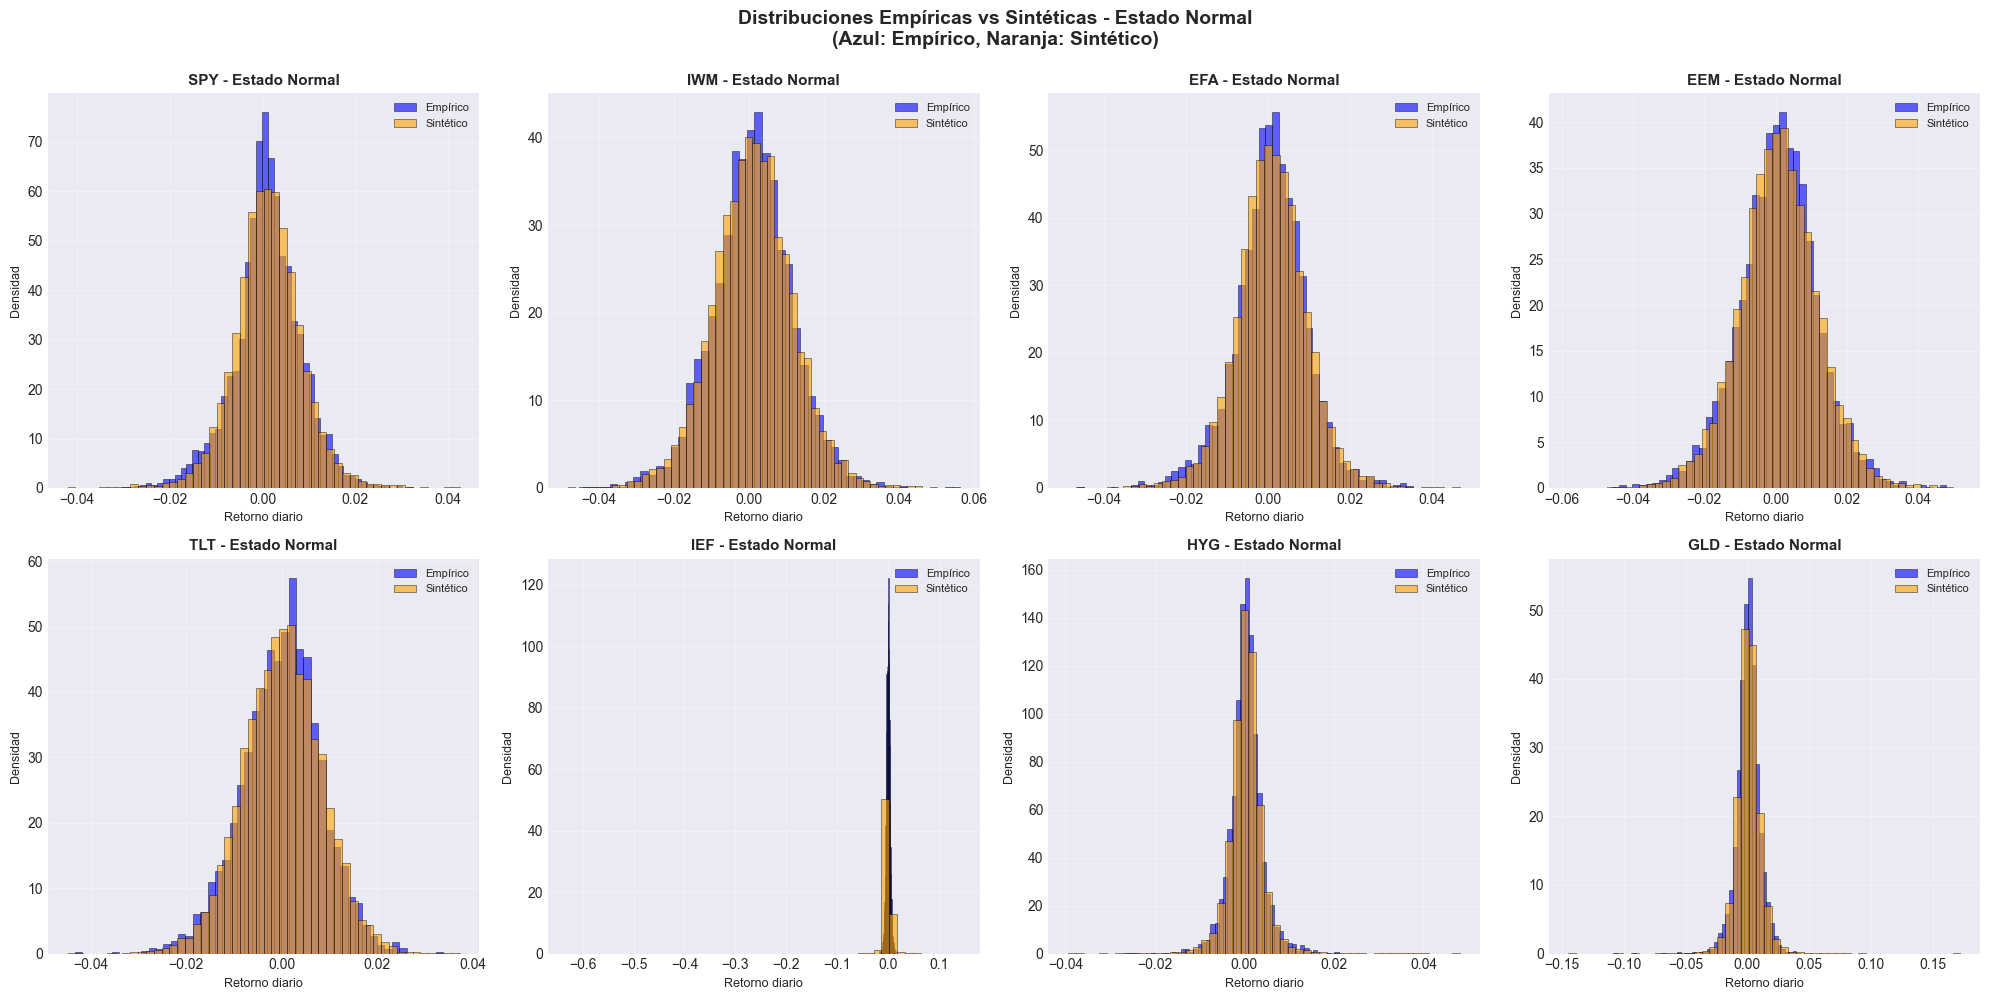

In [78]:
# Histogramas superpuestos para Estado Normal
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ticker in enumerate(returns.columns):
    ax = axes[idx]
    
    # Datos empíricos
    empirical_data = returns_by_state['Normal'][ticker].dropna().values
    # Datos sintéticos
    synthetic_data = scenarios_normal[ticker].dropna().values
    
    # Histogramas
    ax.hist(empirical_data, bins=50, density=True, alpha=0.6, 
           color='blue', label='Empírico', edgecolor='black', linewidth=0.5)
    ax.hist(synthetic_data, bins=50, density=True, alpha=0.6, 
           color='orange', label='Sintético', edgecolor='black', linewidth=0.5)
    
    ax.set_title(f'{ticker} - Estado Normal', fontsize=11, fontweight='bold')
    ax.set_xlabel('Retorno diario', fontsize=9)
    ax.set_ylabel('Densidad', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuciones Empíricas vs Sintéticas - Estado Normal\n(Azul: Empírico, Naranja: Sintético)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 9.2. Histogramas Superpuestos: Empírico vs Sintético (Estado Crisis)

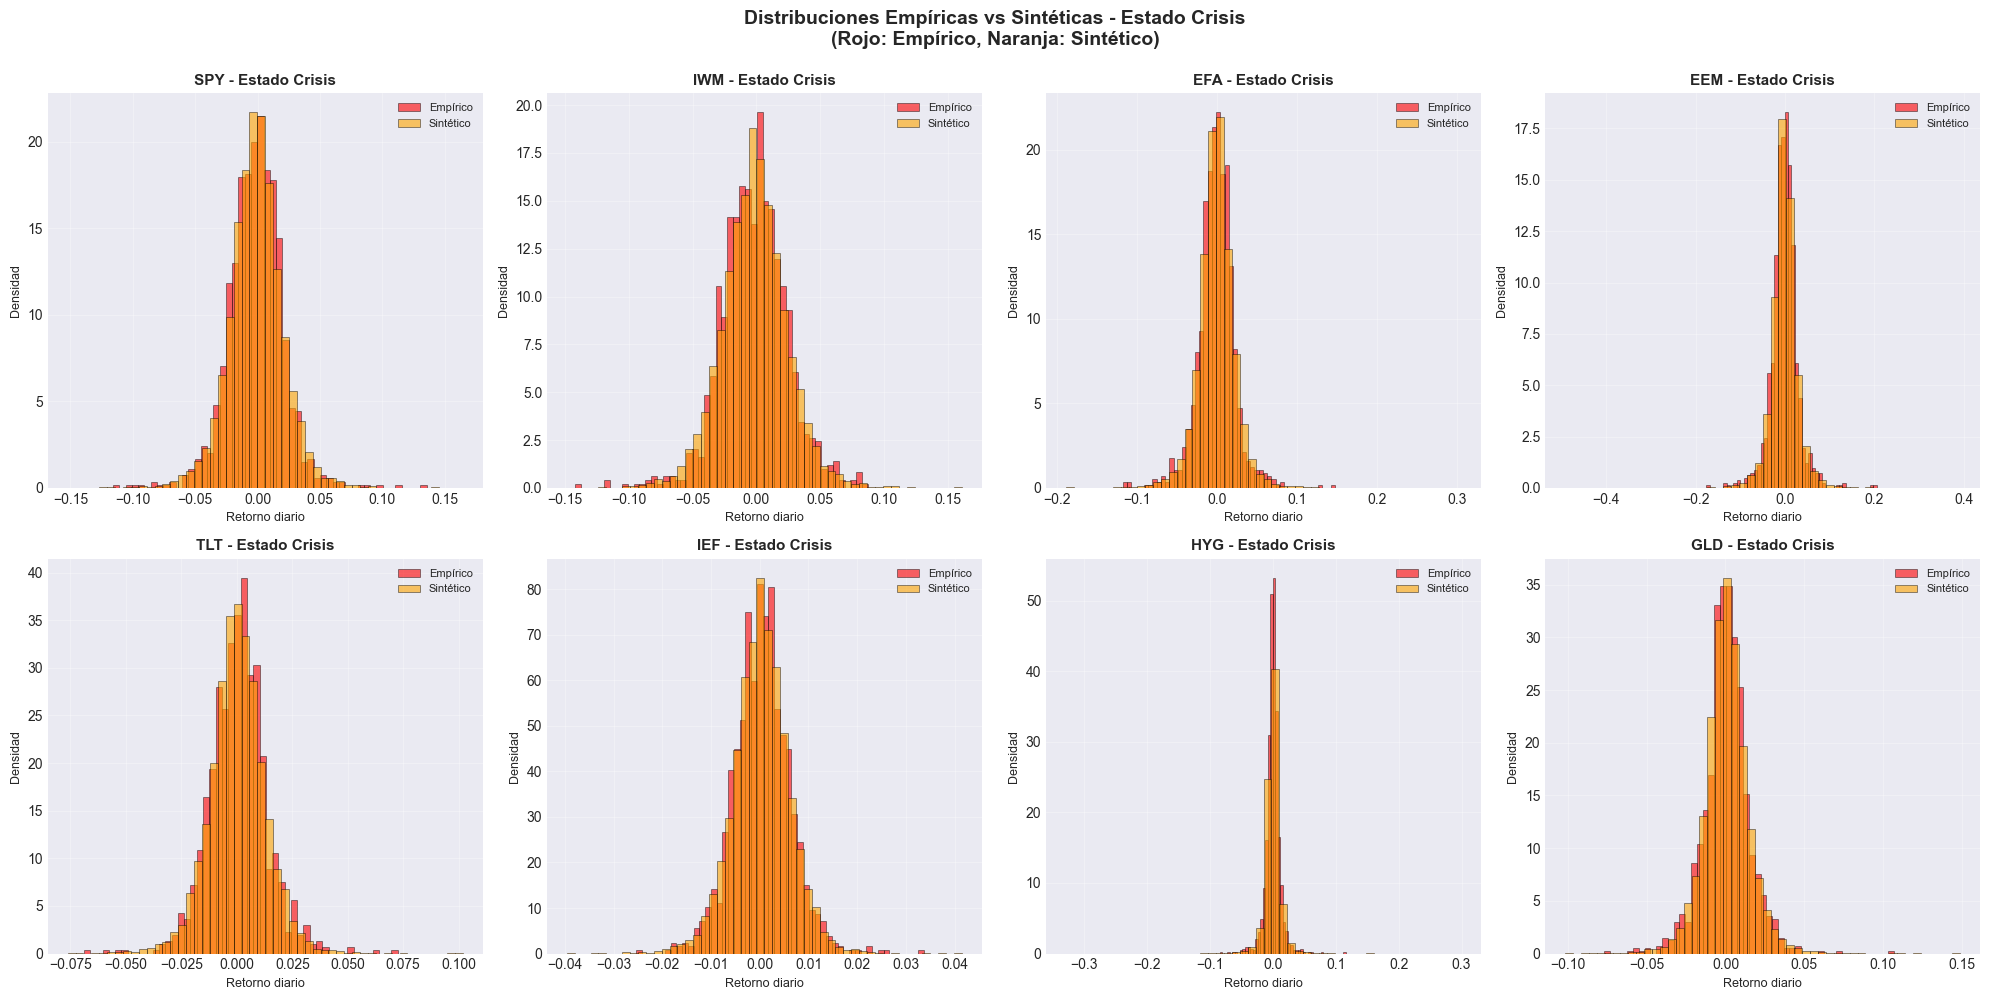

In [79]:
# Histogramas superpuestos para Estado Crisis
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, ticker in enumerate(returns.columns):
    ax = axes[idx]
    
    # Datos empíricos
    empirical_data = returns_by_state['Crisis'][ticker].dropna().values
    # Datos sintéticos
    synthetic_data = scenarios_crisis[ticker].dropna().values
    
    # Histogramas
    ax.hist(empirical_data, bins=50, density=True, alpha=0.6, 
           color='red', label='Empírico', edgecolor='black', linewidth=0.5)
    ax.hist(synthetic_data, bins=50, density=True, alpha=0.6, 
           color='orange', label='Sintético', edgecolor='black', linewidth=0.5)
    
    ax.set_title(f'{ticker} - Estado Crisis', fontsize=11, fontweight='bold')
    ax.set_xlabel('Retorno diario', fontsize=9)
    ax.set_ylabel('Densidad', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuciones Empíricas vs Sintéticas - Estado Crisis\n(Rojo: Empírico, Naranja: Sintético)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 9.3. Scatter Plots de Pares: Empírico vs Sintético

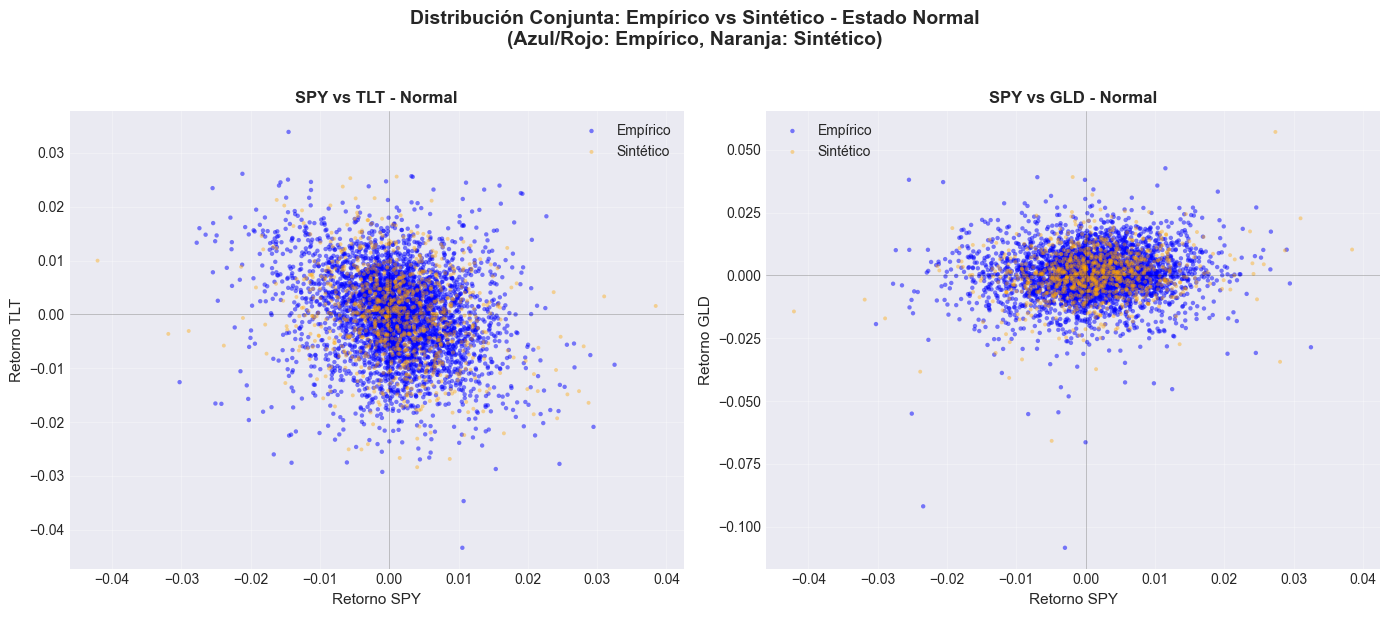

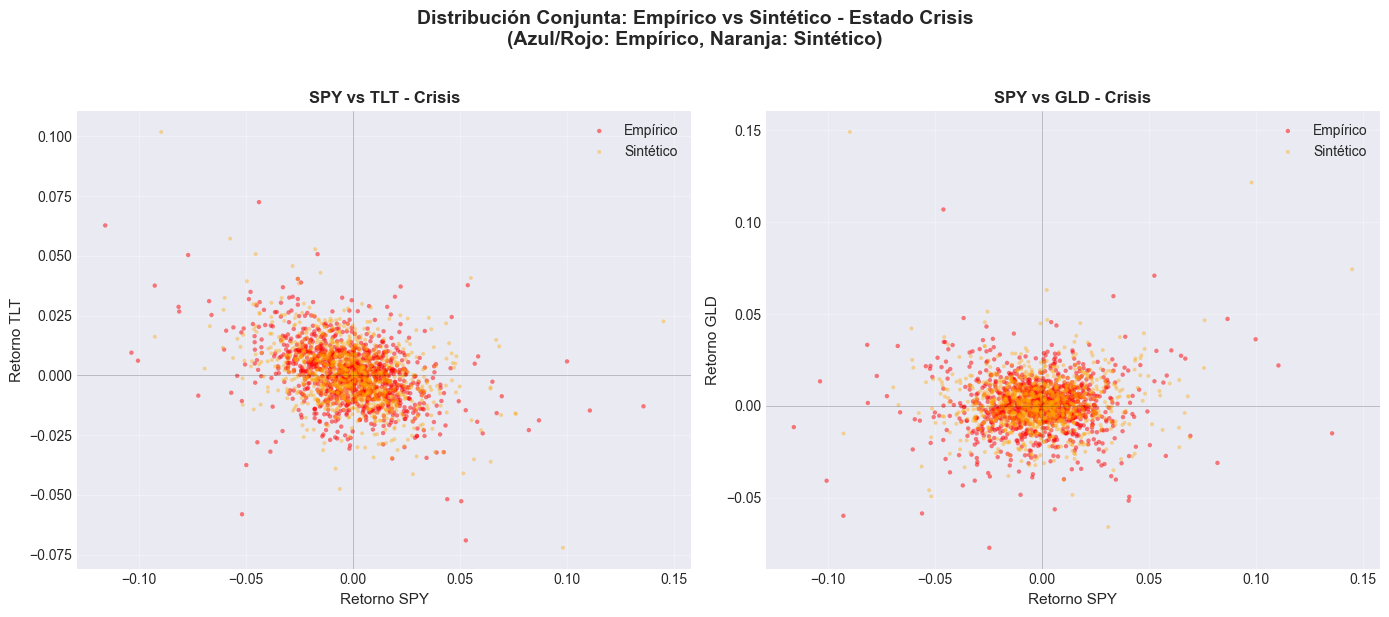

In [80]:
# Scatter plots comparativos para pares seleccionados
selected_pairs = [('SPY', 'TLT'), ('SPY', 'GLD')]

for state_name in ['Normal', 'Crisis']:
    fig, axes = plt.subplots(1, len(selected_pairs), figsize=(14, 6))
    if len(selected_pairs) == 1:
        axes = [axes]
    
    empirical_data = returns_by_state[state_name]
    synthetic_data = scenarios_normal if state_name == 'Normal' else scenarios_crisis
    
    for pair_idx, (ticker1, ticker2) in enumerate(selected_pairs):
        ax = axes[pair_idx]
        
        # Datos empíricos
        emp_pair = empirical_data[[ticker1, ticker2]].dropna()
        if len(emp_pair) > 0:
            ax.scatter(emp_pair[ticker1], emp_pair[ticker2], 
                      alpha=0.5, s=10, color='blue' if state_name == 'Normal' else 'red', 
                      label='Empírico', edgecolors='none')
        
        # Datos sintéticos (muestrear para no saturar)
        n_sample = min(1000, len(synthetic_data))
        synth_sample = synthetic_data.sample(n=n_sample, random_state=42)
        ax.scatter(synth_sample[ticker1], synth_sample[ticker2], 
                  alpha=0.4, s=8, color='orange', label='Sintético', edgecolors='none')
        
        ax.set_xlabel(f'Retorno {ticker1}', fontsize=11)
        ax.set_ylabel(f'Retorno {ticker2}', fontsize=11)
        ax.set_title(f'{ticker1} vs {ticker2} - {state_name}', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.suptitle(f'Distribución Conjunta: Empírico vs Sintético - Estado {state_name}\n(Azul/Rojo: Empírico, Naranja: Sintético)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

### 9.4. Tabla Comparativa: Estadísticas Empíricas vs Sintéticas

In [81]:
# Crear tabla comparativa resumida
print("="*80)
print("TABLA COMPARATIVA: ESTADÍSTICAS EMPÍRICAS VS SINTÉTICAS")
print("="*80)

# Estado Normal
print("\nESTADO NORMAL:")
print("-" * 80)
comparison_table_normal = pd.DataFrame({
    'Media_Emp': stats_empirical_normal['Media'],
    'Media_Syn': stats_synthetic_normal['Media'],
    'Vol_Emp': stats_empirical_normal['Volatilidad'],
    'Vol_Syn': stats_synthetic_normal['Volatilidad'],
    'Skew_Emp': stats_empirical_normal['Asimetría'],
    'Skew_Syn': stats_synthetic_normal['Asimetría']
})
print(comparison_table_normal.round(6))

# Estado Crisis
print("\nESTADO CRISIS:")
print("-" * 80)
comparison_table_crisis = pd.DataFrame({
    'Media_Emp': stats_empirical_crisis['Media'],
    'Media_Syn': stats_synthetic_crisis['Media'],
    'Vol_Emp': stats_empirical_crisis['Volatilidad'],
    'Vol_Syn': stats_synthetic_crisis['Volatilidad'],
    'Skew_Emp': stats_empirical_crisis['Asimetría'],
    'Skew_Syn': stats_synthetic_crisis['Asimetría']
})
print(comparison_table_crisis.round(6))

TABLA COMPARATIVA: ESTADÍSTICAS EMPÍRICAS VS SINTÉTICAS

ESTADO NORMAL:
--------------------------------------------------------------------------------
        Media_Emp  Media_Syn   Vol_Emp   Vol_Syn  Skew_Emp   Skew_Syn
Activo                                                               
SPY      0.000987   0.001098  0.007338  0.007422 -0.193199  -0.029580
IWM      0.000962   0.000916  0.010730  0.010770 -0.029651  -0.005172
EFA      0.000697   0.000879  0.008795  0.008755 -0.198767  -0.033079
EEM      0.000684   0.000800  0.011140  0.011151 -0.113687   0.000659
TLT     -0.000015   0.000142  0.008330  0.008324 -0.198961  -0.065293
IEF      0.000046  -0.000143  0.003855  0.009760 -0.114071 -29.379933
HYG      0.000365   0.000365  0.003772  0.004075 -0.100522   0.683643
GLD      0.000406   0.000711  0.009803  0.009907 -0.961964   0.183702

ESTADO CRISIS:
--------------------------------------------------------------------------------
        Media_Emp  Media_Syn   Vol_Emp   Vol_Syn  

## 10. Análisis de Coherencia

Verificamos que los escenarios sintéticos muestran las características esperadas: mayor dispersión en Crisis, correlaciones más altas en Crisis, y captura adecuada de eventos extremos.

In [82]:
# Análisis de coherencia
print("="*80)
print("ANÁLISIS DE COHERENCIA DE ESCENARIOS")
print("="*80)

# 1. Verificar que Crisis tiene mayor dispersión que Normal
print("\n1. DISPERSIÓN (Volatilidad Promedio):")
print("-" * 80)
vol_normal = scenarios_normal.std().mean()
vol_crisis = scenarios_crisis.std().mean()
print(f"  Normal: {vol_normal:.6f}")
print(f"  Crisis: {vol_crisis:.6f}")
print(f"  Ratio Crisis/Normal: {vol_crisis/vol_normal:.4f}")
if vol_crisis > vol_normal:
    print("  ✓ Crisis tiene mayor dispersión que Normal (esperado)")
else:
    print("  ⚠ Crisis NO tiene mayor dispersión que Normal (revisar)")

# 2. Verificar que correlaciones en Crisis son más altas
print("\n2. CORRELACIONES PROMEDIO (Triangular Superior):")
print("-" * 80)
mask = np.triu(np.ones_like(corr_synthetic_normal, dtype=bool), k=1)
corr_normal_avg = corr_synthetic_normal.values[mask].mean()
corr_crisis_avg = corr_synthetic_crisis.values[mask].mean()
print(f"  Normal: {corr_normal_avg:.4f}")
print(f"  Crisis: {corr_crisis_avg:.4f}")
print(f"  Diferencia: {corr_crisis_avg - corr_normal_avg:.4f}")
if corr_crisis_avg > corr_normal_avg:
    print("  ✓ Correlaciones en Crisis son más altas (efecto contagio, esperado)")
else:
    print("  ⚠ Correlaciones en Crisis NO son más altas (revisar)")

# 3. Verificar captura de eventos extremos
print("\n3. EVENTOS EXTREMOS (Percentiles 1% y 99%):")
print("-" * 80)
for ticker in ['SPY', 'EEM']:  # Activos clave
    normal_p1 = scenarios_normal[ticker].quantile(0.01)
    normal_p99 = scenarios_normal[ticker].quantile(0.99)
    crisis_p1 = scenarios_crisis[ticker].quantile(0.01)
    crisis_p99 = scenarios_crisis[ticker].quantile(0.99)
    
    print(f"\n  {ticker}:")
    print(f"    Normal - P1: {normal_p1:.6f}, P99: {normal_p99:.6f}")
    print(f"    Crisis - P1: {crisis_p1:.6f}, P99: {crisis_p99:.6f}")
    print(f"    Rango Normal: {normal_p99 - normal_p1:.6f}")
    print(f"    Rango Crisis: {crisis_p99 - crisis_p1:.6f}")
    if abs(crisis_p1) > abs(normal_p1) and abs(crisis_p99) > abs(normal_p99):
        print(f"    ✓ Crisis muestra eventos más extremos (esperado)")

# 4. Verificar que no hay valores irreales
print("\n4. VALIDACIÓN DE RANGOS:")
print("-" * 80)
for state_name, scenarios in [('Normal', scenarios_normal), ('Crisis', scenarios_crisis)]:
    min_val = scenarios.min().min()
    max_val = scenarios.max().max()
    print(f"  {state_name}:")
    print(f"    Mínimo: {min_val:.6f}")
    print(f"    Máximo: {max_val:.6f}")
    # Retornos diarios típicamente están en [-0.2, 0.2] para la mayoría de activos
    if abs(min_val) < 1.0 and abs(max_val) < 1.0:
        print(f"    ✓ Rango razonable para retornos diarios")
    else:
        print(f"    ⚠ Rango muy amplio, revisar")

ANÁLISIS DE COHERENCIA DE ESCENARIOS

1. DISPERSIÓN (Volatilidad Promedio):
--------------------------------------------------------------------------------
  Normal: 0.008771
  Crisis: 0.018884
  Ratio Crisis/Normal: 2.1531
  ✓ Crisis tiene mayor dispersión que Normal (esperado)

2. CORRELACIONES PROMEDIO (Triangular Superior):
--------------------------------------------------------------------------------
  Normal: 0.2578
  Crisis: 0.2061
  Diferencia: -0.0518
  ⚠ Correlaciones en Crisis NO son más altas (revisar)

3. EVENTOS EXTREMOS (Percentiles 1% y 99%):
--------------------------------------------------------------------------------

  SPY:
    Normal - P1: -0.017849, P99: 0.019988
    Crisis - P1: -0.058840, P99: 0.056581
    Rango Normal: 0.037838
    Rango Crisis: 0.115421
    ✓ Crisis muestra eventos más extremos (esperado)

  EEM:
    Normal - P1: -0.026314, P99: 0.027894
    Crisis - P1: -0.085132, P99: 0.083531
    Rango Normal: 0.054208
    Rango Crisis: 0.168664
    ✓ 

## 11. Interpretación de Resultados de Validación

### Resultados de Validación

**Estadísticas descriptivas:**
- Las diferencias entre estadísticas empíricas y sintéticas deben ser pequeñas (típicamente < 10%)
- Volatilidades sintéticas deben estar cerca de las empíricas
- Asimetrías y curtosis pueden tener diferencias mayores, pero deben mantener el signo y magnitud relativa

**Matrices de correlación:**
- Las correlaciones sintéticas deben estar cerca de las de la cópula (parámetros estimados)
- Pequeñas diferencias son esperadas debido a variabilidad muestral
- Las correlaciones sintéticas en Crisis deben ser más altas que en Normal

**VaR y CVaR:**
- Los valores sintéticos deben estar cerca de los teóricos (calculados desde distribuciones ajustadas)
- Diferencias pequeñas son normales debido a variabilidad de simulación
- CVaR sintético debe ser más negativo que VaR sintético

**Tests de bondad de ajuste:**
- Tests K-S con p-valor >= 0.05 indican que las distribuciones son consistentes
- Es normal que algunos activos no pasen el test, especialmente si las distribuciones tienen características especiales
- Lo importante es que la mayoría de activos muestren consistencia

**Coherencia:**
- Los escenarios Crisis deben mostrar mayor dispersión y correlaciones más altas
- Los eventos extremos deben ser más frecuentes y severos en Crisis
- Los rangos de valores deben ser realistas para retornos diarios

### Limitaciones y Consideraciones

**Limitaciones de los escenarios sintéticos:**

1. **Condicionales a estado**: Los escenarios asumen que el mercado permanece en un estado (Normal o Crisis). No modelan transiciones entre estados.

2. **Basados en datos históricos**: Los escenarios reflejan patrones observados históricamente. No predicen eventos completamente nuevos o sin precedentes.

3. **Asumen estacionariedad**: Suponen que las distribuciones y dependencias no cambian en el futuro, lo cual puede no ser cierto en períodos de cambios estructurales.

4. **Variabilidad de simulación**: Con 10,000 escenarios, puede haber variabilidad en las estadísticas calculadas. Escenarios más extremos pueden requerir más simulaciones.

5. **No capturan dependencias no lineales complejas**: Las cópulas t capturan dependencia en colas, pero pueden no capturar todas las formas de dependencia no lineal.

**Uso apropiado:**

- Evaluación de riesgo de cartera bajo condiciones de mercado conocidas
- Stress testing con escenarios adversos basados en crisis históricas
- Optimización de cartera considerando múltiples escenarios
- Cálculo de métricas de riesgo (VaR, CVaR) bajo diferentes condiciones

## 12. Resumen y Variables para Secciones Posteriores

### Variables Clave Preservadas

Las siguientes estructuras de datos están disponibles para uso en secciones posteriores:

In [ ]:
# Verificación final de variables clave
print("="*80)
print("VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES")
print("="*80)

variables_to_check = {
    'scenarios_normal': 'DataFrame con escenarios sintéticos para Estado Normal',
    'scenarios_crisis': 'DataFrame con escenarios sintéticos para Estado Crisis',
    'simulate_t_copula': 'Función para simular desde cópula t',
    'transform_uniforms_to_returns': 'Función para transformar uniformes a retornos'
}

for var_name, description in variables_to_check.items():
    exists = var_name in globals()
    status = "✓" if exists else "✗"
    print(f"{status} {var_name}: {description}")
    if exists:
        if var_name in ['scenarios_normal', 'scenarios_crisis']:
            df = globals()[var_name]
            if isinstance(df, pd.DataFrame):
                print(f"    Dimensiones: {df.shape}")
                print(f"    Activos: {list(df.columns)}")

print("\n" + "="*80)
print("RESUMEN DE LA FASE 5")
print("="*80)
print(f"Escenarios generados: {n_scenarios:,} por estado")
print(f"Estado Normal: {scenarios_normal.shape}")
print(f"Estado Crisis: {scenarios_crisis.shape}")
print(f"Validaciones realizadas:")
print(f"  - Estadísticas descriptivas")
print(f"  - Matrices de correlación")
print(f"  - VaR y CVaR")
print(f"  - Tests de bondad de ajuste (K-S)")
print(f"  - Análisis de coherencia")

print("\n✓ Fase 5 completada. Escenarios sintéticos listos para stress testing de cartera.")

VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES
✓ scenarios_normal: DataFrame con escenarios sintéticos para Estado Normal
    Dimensiones: (10000, 8)
    Activos: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']
✓ scenarios_crisis: DataFrame con escenarios sintéticos para Estado Crisis
    Dimensiones: (10000, 8)
    Activos: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']
✓ simulate_t_copula: Función para simular desde cópula t
✓ transform_uniforms_to_returns: Función para transformar uniformes a retornos

RESUMEN DE LA SECCIÓN 5
Escenarios generados: 10,000 por estado
Estado Normal: (10000, 8)
Estado Crisis: (10000, 8)
Validaciones realizadas:
  - Estadísticas descriptivas
  - Matrices de correlación
  - VaR y CVaR
  - Tests de bondad de ajuste (K-S)
  - Análisis de coherencia

✓ Sección 5 completada. Escenarios sintéticos listos para stress testing de cartera.


In [ ]:
# Verificación final de variables clave
print("="*80)
print("VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES")
print("="*80)

variables_to_check = {
    'copula_params_normal': 'Parámetros de cópula t para Estado Normal (correlación, df)',
    'copula_params_crisis': 'Parámetros de cópula t para Estado Crisis (correlación, df)',
    'uniform_observations': 'Pseudo-observaciones uniformes por estado',
    't_copula_pdf': 'Función de densidad de cópula t',
    't_copula_tail_dependence': 'Función para calcular tail dependence'
}

for var_name, description in variables_to_check.items():
    exists = var_name in globals()
    status = "✓" if exists else "✗"
    print(f"{status} {var_name}: {description}")
    if exists:
        if var_name in ['copula_params_normal', 'copula_params_crisis']:
            params = globals()[var_name]
            if isinstance(params, dict):
                print(f"    Grados de libertad: {params.get('df', 'N/A'):.4f}")
                print(f"    Matriz de correlación: {params.get('correlation_matrix', 'N/A').shape if 'correlation_matrix' in params else 'N/A'}")

print("\n" + "="*80)
print("RESUMEN DE LA FASE 4")
print("="*80)
print(f"Cópulas ajustadas: 2 (Normal y Crisis)")
print(f"Grados de libertad Normal: {copula_params_normal['df']:.4f}")
print(f"Grados de libertad Crisis: {copula_params_crisis['df']:.4f}")
print(f"Tail dependence calculado para {len(key_pairs)} pares de activos")

# Comparación resumida
print(f"\nComparación Normal vs Crisis:")
print(f"  Diferencia en df: {copula_params_crisis['df'] - copula_params_normal['df']:.4f}")
if copula_params_crisis['df'] < copula_params_normal['df']:
    print("  → Mayor dependencia en colas en Crisis (esperado)")

print("\n✓ Fase 4 completada. Modelos de dependencia multivariada listos para stress testing.")

VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES
✓ copula_params_normal: Parámetros de cópula t para Estado Normal (correlación, df)
    Grados de libertad: 10.0000
    Matriz de correlación: (8, 8)
✓ copula_params_crisis: Parámetros de cópula t para Estado Crisis (correlación, df)
    Grados de libertad: 5.0000
    Matriz de correlación: (8, 8)
✓ uniform_observations: Pseudo-observaciones uniformes por estado
✓ t_copula_pdf: Función de densidad de cópula t
✓ t_copula_tail_dependence: Función para calcular tail dependence

RESUMEN DE LA SECCIÓN 4
Cópulas ajustadas: 2 (Normal y Crisis)
Grados de libertad Normal: 10.0000
Grados de libertad Crisis: 5.0000
Tail dependence calculado para 6 pares de activos

Comparación Normal vs Crisis:
  Diferencia en df: -5.0000
  → Mayor dependencia en colas en Crisis (esperado)

✓ Sección 4 completada. Modelos de dependencia multivariada listos para stress testing.
